In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

Date   Open   High    Low  Close     Volume  OpenInt
0  2014-09-19  92.70  99.70  89.95  93.89  271831625        0
1  2014-09-22  92.70  92.95  89.50  89.89   66628862        0
2  2014-09-23  89.00  90.48  86.62  87.17   38984872        0
3  2014-09-24  88.47  90.57  87.22  90.57   32016559        0
4  2014-09-25  91.09  91.50  88.50  88.92   28584828        0

**Add Bloomberg ref info to create ticker lookup table**

In [3]:
def bbg_ref():
    
    tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

    from os import listdir
    from os.path import isfile, join

    mypath = 'Stocks/'

    tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 

    for i in range(len(tickers)):
        raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
        year = raw_data.iloc[-1]['Date'][:4]
        n_datapoints = len(raw_data)
        tickers.loc[i,'year_last'] = year
        tickers.loc[i,'n_datapoints'] = n_datapoints

        tickers['year_last'] = tickers['year_last'].astype(int)
        tickers = tickers[~tickers['file_name'].str.contains('_')]
        tickers = tickers[~tickers['file_name'].str.contains('-')]
    
    import pdblp
    
    con = pdblp.BCon(debug=True, port=8194, timeout=5000)

    tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

    con.start()

    ref_data = pd.DataFrame()

    for ticker in tickers_['ticker'].tolist():
        try:
            ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
        except:
            True
    ref_data_copy = ref_data
    ref_data.pivot(index='ticker',columns='field',values='value')
    tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
    tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]
    
    tickers.to_csv('tickers_lookup.csv',index=False)

## Feature extraction

In [4]:
from create_features import create_features

In [5]:
features, raw_data = create_features('ba.us',21)

In [6]:
features.shape

(12031, 11)

In [7]:
features.columns

Index(['Open', 'pct_overnight', 'pct_close', 'pct_close_sigma_q_tw',
       'pct_close_sigma_tw', 'avg_return_q_tw', 'avg_return_tw',
       'perctentile_q_tw', 'perctentile_tw', 'pct_volume_sigma_q_tw',
       'pct_volume_sigma_tw'],
      dtype='object')

In [8]:
def sample_data(trading_window,features, raw_data):
    #Keep random sample of size trading_window  
    import numpy as np
    i = np.random.randint(0,high=len(features)-trading_window-1)
    features = features.iloc[i:i+trading_window,] 
    prices= raw_data.loc[features.index,]
    return features, prices

In [9]:
#Test
features, prices = sample_data(5, features, raw_data)

## Reinforcement Learning

### Data Preparation

In [10]:
def train_test_data(ticker, industry_sector, n_tickers, trading_window, min_year=2007, train_max_year=2016):
    
    #Ticker selection
    if ticker is not None:
        tickers = [ticker]
    else:
        #Get list of tickers based on selected industry 
        tickers_lookup = pd.read_csv('tickers_lookup.csv')
        tickers = tickers_lookup[tickers_lookup.INDUSTRY_SECTOR==industry_sector].sort_values('CUR_MKT_CAP',ascending=False)
        tickers = tickers.iloc[:n_tickers]['file_name'] #pick top n tickers by market cap
        tickers = [ticker[:len(ticker)-4] for ticker in tickers] #remove .txt extension
    
    #Empty dataframes to hold full sets of training and test data
    features_train = pd.DataFrame()
    features_test = pd.DataFrame()
    raw_data_train = pd.DataFrame()
    raw_data_test = pd.DataFrame()
    
    for ticker in tickers:
        features_i, raw_data_i = create_features(ticker,trading_window)
        features_i['ticker'] = ticker
        raw_data_i['ticker'] = ticker
        
        #Only keep data after min_year
        features_i['Year'] = pd.to_datetime(features_i.index.values).year
        features_i = features_i.loc[features_i['Year']>min_year]
        raw_data_i = raw_data_i.loc[features_i.index]

        #Split training & testing sets (data points after train_max_year are used for testing)
        features_train_i = features_i.loc[features_i['Year']<train_max_year]
        raw_data_train_i = raw_data_i.loc[features_train_i.index]

        features_test_i = features_i.loc[features_i['Year']>=train_max_year]
        raw_data_test_i = raw_data_i.loc[features_test_i.index]

        #Append to full set of features and raw_data
        features_train = features_train.append(features_train_i)
        raw_data_train = raw_data_train.append(raw_data_train_i)
        features_test = features_test.append(features_test_i)
        raw_data_test = raw_data_test.append(raw_data_test_i)
    
    
    #Remove Year column from features
    features_train = features_train.drop(['Year'], axis = 1)
    features_test = features_test.drop(['Year'], axis = 1)
    
    return features_train, features_test, raw_data_train, raw_data_test

In [11]:
ticker = None
industry_sector = 'Industrial'
n_tickers = 30
trading_window = 21
min_year = 2007
train_max_year = 2016

features_train, features_test, raw_data_train, raw_data_test = train_test_data(ticker,industry_sector,n_tickers,trading_window,min_year,train_max_year)

In [12]:
print('# of total samples: ' + str(features_train.shape[0]+features_test.shape[0]))
print('# of training samples: ' + str(features_train.shape[0]))
print('# of test samples: ' + str(features_test.shape[0]))

# of total samples: 71896
# of training samples: 58025
# of test samples: 13871


### Training

In [13]:
#IPython extension to reload modules, so that kernel does not need to be restarted for every change in the Gym environment
%load_ext autoreload
%autoreload 2

Set up environment for training:

In [39]:
import gym
import gym_market
import numpy as np
import imp

pos_limit = 2
trading_freq = 1

stop_loss_thres = 0.98
take_prof_thres = 1.04

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features_train, 
                  'raw_data':raw_data_train}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


C:\Users\Alex\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Test environment:

In [40]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [2, 0, 2, 2, 2, 0, 0, 1, 2, 1, 1, 0, 1, 1, 2, 0, 2, 0, 2, 2, 1]
Rewards: [-3.55, -0.5700000000000001, 1.44, -3.61, -3.68, 0.17000000000000004, -0.98, 0.27, -3.74, 0.20999999999999996, -3.8, -0.95, 0.15000000000000002, 0.07999999999999996, -2.92, -1.0699999999999998, -3.9699999999999998, -0.13, -4.03, -4.1, 0.9]
Return: 0.8599628717151383


In [41]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

Neural net architecture:

In [89]:
import tensorflow as tf 

class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            
            #self.learning_rate_ = tf.placeholder(tf.float32, shape=[])
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [90]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [91]:
train_episodes = 6000         # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.7                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0005            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [92]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, state_size=features.shape[1]+2, learning_rate=learning_rate)

Populate memory:

In [93]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [94]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        
        # Decaying learning rate
        #lr_0 = 0.01 
        #lr_i = lr_0*(0.5**(np.floor((1+ep)/500)))
        
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()    
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))} #,mainQN.learning_rate_: lr_i
                Qs = sess.run(mainQN.output, feed_dict=feed)
                #if ep > 1500:
                    #print("Q_s: "+str(Qs))
                action = np.argmax(Qs)
            #print(action)if ep > 1500 else False
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
              
                print('Episode: {}'.format(ep),
                      'Total reward: {:.2f}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states}) #, mainQN.learning_rate_: lr_i
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions}) #,mainQN.learning_rate_: lr_i
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: -26.28 Training loss: 4.8325 Explore P: 0.9897 Total return: 1.03
Episode: 2 Total reward: -31.85 Training loss: 4.0082 Explore P: 0.9794 Total return: 0.87
Episode: 3 Total reward: -29.07 Training loss: 2.8945 Explore P: 0.9693 Total return: 1.03
Episode: 4 Total reward: -25.58 Training loss: 4.0581 Explore P: 0.9593 Total return: 1.11
Episode: 5 Total reward: -32.73 Training loss: 3.6742 Explore P: 0.9494 Total return: 1.21
Episode: 6 Total reward: -30.57 Training loss: 3.5998 Explore P: 0.9396 Total return: 0.99
Episode: 7 Total reward: -29.78 Training loss: 4.3597 Explore P: 0.9298 Total return: 0.98
Episode: 8 Total reward: -23.68 Training loss: 3.1114 Explore P: 0.9202 Total return: 0.90
Episode: 9 Total reward: -24.43 Training loss: 2.3083 Explore P: 0.9107 Total return: 1.09
Episode: 10 Total reward: -20.50 Training loss: 2.1687 Explore P: 0.9013 Total return: 1.03
Episode: 11 Total reward: -26.77 Training loss: 2.2965 Explore P: 0.8920 Total return: 0.

Episode: 91 Total reward: -26.64 Training loss: 2.2543 Explore P: 0.3908 Total return: 0.99
Episode: 92 Total reward: -18.78 Training loss: 2.0798 Explore P: 0.3868 Total return: 1.06
Episode: 93 Total reward: -22.25 Training loss: 3.5464 Explore P: 0.3829 Total return: 1.03
Episode: 94 Total reward: -9.97 Training loss: 2.0314 Explore P: 0.3790 Total return: 1.06
Episode: 95 Total reward: -20.49 Training loss: 3.4115 Explore P: 0.3751 Total return: 1.02
Episode: 96 Total reward: -22.79 Training loss: 4.2280 Explore P: 0.3713 Total return: 1.02
Episode: 97 Total reward: -26.31 Training loss: 2.2002 Explore P: 0.3675 Total return: 1.03
Episode: 98 Total reward: -30.56 Training loss: 2.5533 Explore P: 0.3638 Total return: 0.98
Episode: 99 Total reward: -25.81 Training loss: 2.7127 Explore P: 0.3601 Total return: 0.97
Episode: 100 Total reward: -18.03 Training loss: 2.7375 Explore P: 0.3564 Total return: 0.98
Episode: 101 Total reward: -20.23 Training loss: 1.3206 Explore P: 0.3528 Total 

Episode: 180 Total reward: -25.50 Training loss: 3.3029 Explore P: 0.1596 Total return: 0.95
Episode: 181 Total reward: -19.26 Training loss: 2.5784 Explore P: 0.1580 Total return: 1.00
Episode: 182 Total reward: -23.46 Training loss: 2.5928 Explore P: 0.1565 Total return: 0.94
Episode: 183 Total reward: -19.90 Training loss: 2.8345 Explore P: 0.1549 Total return: 0.96
Episode: 184 Total reward: -15.24 Training loss: 2.0640 Explore P: 0.1534 Total return: 1.02
Episode: 185 Total reward: -14.37 Training loss: 2.8731 Explore P: 0.1519 Total return: 1.05
Episode: 186 Total reward: -16.97 Training loss: 1.8362 Explore P: 0.1504 Total return: 1.02
Episode: 187 Total reward: -18.33 Training loss: 2.6228 Explore P: 0.1490 Total return: 1.07
Episode: 188 Total reward: -37.01 Training loss: 1.8342 Explore P: 0.1475 Total return: 0.92
Episode: 189 Total reward: -30.19 Training loss: 1.8394 Explore P: 0.1461 Total return: 0.97
Episode: 190 Total reward: -24.31 Training loss: 0.9854 Explore P: 0.1

Episode: 270 Total reward: -23.61 Training loss: 2.2295 Explore P: 0.0681 Total return: 1.05
Episode: 271 Total reward: -27.41 Training loss: 1.6115 Explore P: 0.0675 Total return: 0.80
Episode: 272 Total reward: -25.16 Training loss: 2.8843 Explore P: 0.0669 Total return: 0.95
Episode: 273 Total reward: -26.03 Training loss: 2.8184 Explore P: 0.0663 Total return: 0.98
Episode: 274 Total reward: -20.26 Training loss: 1.0029 Explore P: 0.0657 Total return: 0.97
Episode: 275 Total reward: -19.99 Training loss: 2.1259 Explore P: 0.0652 Total return: 0.98
Episode: 276 Total reward: -31.84 Training loss: 2.1260 Explore P: 0.0646 Total return: 0.93
Episode: 277 Total reward: -27.33 Training loss: 1.9980 Explore P: 0.0640 Total return: 0.94
Episode: 278 Total reward: -25.04 Training loss: 1.3598 Explore P: 0.0634 Total return: 1.03
Episode: 279 Total reward: -24.64 Training loss: 2.8961 Explore P: 0.0629 Total return: 1.03
Episode: 280 Total reward: -12.83 Training loss: 1.8568 Explore P: 0.0

Episode: 361 Total reward: -17.71 Training loss: 2.9193 Explore P: 0.0324 Total return: 1.06
Episode: 362 Total reward: -17.31 Training loss: 1.4837 Explore P: 0.0321 Total return: 1.09
Episode: 363 Total reward: -22.95 Training loss: 2.0491 Explore P: 0.0319 Total return: 1.03
Episode: 364 Total reward: -21.95 Training loss: 3.5121 Explore P: 0.0317 Total return: 0.96
Episode: 365 Total reward: -18.23 Training loss: 2.8443 Explore P: 0.0314 Total return: 1.05
Episode: 366 Total reward: -14.58 Training loss: 1.2712 Explore P: 0.0312 Total return: 1.06
Episode: 367 Total reward: -19.59 Training loss: 1.1727 Explore P: 0.0310 Total return: 1.08
Episode: 368 Total reward: -19.50 Training loss: 1.0145 Explore P: 0.0308 Total return: 1.02
Episode: 369 Total reward: -16.36 Training loss: 2.5855 Explore P: 0.0306 Total return: 1.05
Episode: 370 Total reward: -23.51 Training loss: 2.6770 Explore P: 0.0303 Total return: 1.03
Episode: 371 Total reward: -34.48 Training loss: 2.7603 Explore P: 0.0

Episode: 450 Total reward: -24.92 Training loss: 2.9431 Explore P: 0.0188 Total return: 0.93
Episode: 451 Total reward: -22.95 Training loss: 2.2995 Explore P: 0.0187 Total return: 0.96
Episode: 452 Total reward: -19.04 Training loss: 2.0542 Explore P: 0.0186 Total return: 1.01
Episode: 453 Total reward: -20.84 Training loss: 0.8790 Explore P: 0.0185 Total return: 1.03
Episode: 454 Total reward: -28.78 Training loss: 2.9136 Explore P: 0.0184 Total return: 0.92
Episode: 455 Total reward: -16.70 Training loss: 0.9780 Explore P: 0.0183 Total return: 1.09
Episode: 456 Total reward: -22.68 Training loss: 1.5637 Explore P: 0.0182 Total return: 0.99
Episode: 457 Total reward: -18.25 Training loss: 1.5588 Explore P: 0.0182 Total return: 1.07
Episode: 458 Total reward: -15.71 Training loss: 3.0404 Explore P: 0.0181 Total return: 0.90
Episode: 459 Total reward: -27.20 Training loss: 2.0389 Explore P: 0.0180 Total return: 0.98
Episode: 460 Total reward: -29.69 Training loss: 1.7311 Explore P: 0.0

Episode: 540 Total reward: -17.84 Training loss: 1.7261 Explore P: 0.0134 Total return: 1.08
Episode: 541 Total reward: -31.19 Training loss: 0.9053 Explore P: 0.0134 Total return: 0.94
Episode: 542 Total reward: -23.26 Training loss: 1.7885 Explore P: 0.0133 Total return: 0.92
Episode: 543 Total reward: -25.55 Training loss: 2.7095 Explore P: 0.0133 Total return: 0.93
Episode: 544 Total reward: -27.05 Training loss: 1.7592 Explore P: 0.0133 Total return: 0.97
Episode: 545 Total reward: -35.21 Training loss: 1.2665 Explore P: 0.0132 Total return: 1.03
Episode: 546 Total reward: -14.50 Training loss: 1.5463 Explore P: 0.0132 Total return: 1.02
Episode: 547 Total reward: -25.66 Training loss: 1.6874 Explore P: 0.0132 Total return: 1.04
Episode: 548 Total reward: -29.57 Training loss: 1.4286 Explore P: 0.0131 Total return: 0.98
Episode: 549 Total reward: -29.05 Training loss: 2.2971 Explore P: 0.0131 Total return: 0.88
Episode: 550 Total reward: -19.25 Training loss: 1.5279 Explore P: 0.0

Episode: 629 Total reward: -18.80 Training loss: 1.4621 Explore P: 0.0113 Total return: 0.98
Episode: 630 Total reward: -24.38 Training loss: 2.3917 Explore P: 0.0113 Total return: 0.97
Episode: 631 Total reward: -27.67 Training loss: 1.0033 Explore P: 0.0113 Total return: 0.90
Episode: 632 Total reward: -16.67 Training loss: 1.0233 Explore P: 0.0113 Total return: 1.09
Episode: 633 Total reward: -25.29 Training loss: 2.3865 Explore P: 0.0113 Total return: 0.98
Episode: 634 Total reward: -16.92 Training loss: 1.4489 Explore P: 0.0113 Total return: 0.99
Episode: 635 Total reward: -23.61 Training loss: 1.5102 Explore P: 0.0113 Total return: 1.06
Episode: 636 Total reward: -20.02 Training loss: 1.5486 Explore P: 0.0112 Total return: 1.08
Episode: 637 Total reward: -26.15 Training loss: 1.3735 Explore P: 0.0112 Total return: 1.01
Episode: 638 Total reward: -15.27 Training loss: 2.8947 Explore P: 0.0112 Total return: 1.09
Episode: 639 Total reward: -33.16 Training loss: 0.9844 Explore P: 0.0

Episode: 718 Total reward: -12.68 Training loss: 1.7430 Explore P: 0.0105 Total return: 1.10
Episode: 719 Total reward: -17.75 Training loss: 1.4974 Explore P: 0.0105 Total return: 1.01
Episode: 720 Total reward: -15.78 Training loss: 2.0974 Explore P: 0.0105 Total return: 1.08
Episode: 721 Total reward: -15.63 Training loss: 1.5393 Explore P: 0.0105 Total return: 1.00
Episode: 722 Total reward: -18.86 Training loss: 0.3213 Explore P: 0.0105 Total return: 1.04
Episode: 723 Total reward: -17.29 Training loss: 2.5068 Explore P: 0.0105 Total return: 1.09
Episode: 724 Total reward: -15.96 Training loss: 0.5325 Explore P: 0.0105 Total return: 1.02
Episode: 725 Total reward: -26.82 Training loss: 0.8749 Explore P: 0.0105 Total return: 0.98
Episode: 726 Total reward: -14.76 Training loss: 2.5361 Explore P: 0.0105 Total return: 1.04
Episode: 727 Total reward: -12.13 Training loss: 2.0806 Explore P: 0.0105 Total return: 1.05
Episode: 728 Total reward: -19.81 Training loss: 1.9541 Explore P: 0.0

Episode: 807 Total reward: -24.02 Training loss: 2.5220 Explore P: 0.0102 Total return: 1.05
Episode: 808 Total reward: -27.13 Training loss: 0.7337 Explore P: 0.0102 Total return: 0.96
Episode: 809 Total reward: -13.15 Training loss: 2.8749 Explore P: 0.0102 Total return: 1.06
Episode: 810 Total reward: -27.55 Training loss: 1.1357 Explore P: 0.0102 Total return: 0.97
Episode: 811 Total reward: -23.45 Training loss: 1.7978 Explore P: 0.0102 Total return: 1.05
Episode: 812 Total reward: -36.00 Training loss: 1.5466 Explore P: 0.0102 Total return: 0.99
Episode: 813 Total reward: -42.07 Training loss: 1.1088 Explore P: 0.0102 Total return: 0.78
Episode: 814 Total reward: -29.31 Training loss: 1.3180 Explore P: 0.0102 Total return: 0.97
Episode: 815 Total reward: -31.15 Training loss: 1.4275 Explore P: 0.0102 Total return: 0.95
Episode: 816 Total reward: -24.89 Training loss: 2.9761 Explore P: 0.0102 Total return: 1.08
Episode: 817 Total reward: -44.06 Training loss: 1.8291 Explore P: 0.0

Episode: 896 Total reward: -23.57 Training loss: 2.0402 Explore P: 0.0101 Total return: 0.99
Episode: 897 Total reward: -34.35 Training loss: 0.9113 Explore P: 0.0101 Total return: 0.96
Episode: 898 Total reward: -13.89 Training loss: 2.5972 Explore P: 0.0101 Total return: 1.13
Episode: 899 Total reward: -13.45 Training loss: 0.6031 Explore P: 0.0101 Total return: 1.13
Episode: 900 Total reward: -13.27 Training loss: 0.7966 Explore P: 0.0101 Total return: 1.04
Episode: 901 Total reward: -20.20 Training loss: 1.4296 Explore P: 0.0101 Total return: 1.02
Episode: 902 Total reward: -17.03 Training loss: 2.4128 Explore P: 0.0101 Total return: 1.00
Episode: 903 Total reward: -23.03 Training loss: 1.4841 Explore P: 0.0101 Total return: 0.97
Episode: 904 Total reward: -25.02 Training loss: 1.0819 Explore P: 0.0101 Total return: 1.00
Episode: 905 Total reward: -24.51 Training loss: 2.8795 Explore P: 0.0101 Total return: 0.97
Episode: 906 Total reward: -15.08 Training loss: 3.2925 Explore P: 0.0

Episode: 986 Total reward: -15.75 Training loss: 1.5419 Explore P: 0.0100 Total return: 1.01
Episode: 987 Total reward: -26.08 Training loss: 2.1767 Explore P: 0.0100 Total return: 1.02
Episode: 988 Total reward: -28.27 Training loss: 2.9411 Explore P: 0.0100 Total return: 1.05
Episode: 989 Total reward: -17.42 Training loss: 1.7533 Explore P: 0.0100 Total return: 1.01
Episode: 990 Total reward: -21.29 Training loss: 2.6130 Explore P: 0.0100 Total return: 1.07
Episode: 991 Total reward: -22.55 Training loss: 1.3179 Explore P: 0.0100 Total return: 1.00
Episode: 992 Total reward: -29.84 Training loss: 2.1922 Explore P: 0.0100 Total return: 0.95
Episode: 993 Total reward: -17.12 Training loss: 1.1100 Explore P: 0.0100 Total return: 1.07
Episode: 994 Total reward: -17.75 Training loss: 3.2841 Explore P: 0.0100 Total return: 1.04
Episode: 995 Total reward: -17.36 Training loss: 1.1797 Explore P: 0.0100 Total return: 1.04
Episode: 996 Total reward: -15.67 Training loss: 2.1029 Explore P: 0.0

Episode: 1074 Total reward: -33.36 Training loss: 0.8015 Explore P: 0.0100 Total return: 0.93
Episode: 1075 Total reward: -36.32 Training loss: 1.4401 Explore P: 0.0100 Total return: 0.86
Episode: 1076 Total reward: -19.76 Training loss: 2.2443 Explore P: 0.0100 Total return: 1.03
Episode: 1077 Total reward: -28.24 Training loss: 0.9968 Explore P: 0.0100 Total return: 0.92
Episode: 1078 Total reward: -18.37 Training loss: 1.0288 Explore P: 0.0100 Total return: 1.04
Episode: 1079 Total reward: -15.32 Training loss: 1.4749 Explore P: 0.0100 Total return: 1.13
Episode: 1080 Total reward: -22.52 Training loss: 2.2143 Explore P: 0.0100 Total return: 1.00
Episode: 1081 Total reward: -16.39 Training loss: 0.7807 Explore P: 0.0100 Total return: 1.10
Episode: 1082 Total reward: -28.90 Training loss: 0.9558 Explore P: 0.0100 Total return: 0.93
Episode: 1083 Total reward: -25.51 Training loss: 1.7553 Explore P: 0.0100 Total return: 1.02
Episode: 1084 Total reward: -18.12 Training loss: 0.7734 Exp

Episode: 1163 Total reward: -22.93 Training loss: 1.5843 Explore P: 0.0100 Total return: 0.87
Episode: 1164 Total reward: -23.12 Training loss: 0.7389 Explore P: 0.0100 Total return: 1.01
Episode: 1165 Total reward: -17.94 Training loss: 0.6942 Explore P: 0.0100 Total return: 1.09
Episode: 1166 Total reward: -15.41 Training loss: 1.7567 Explore P: 0.0100 Total return: 1.09
Episode: 1167 Total reward: -27.49 Training loss: 1.4173 Explore P: 0.0100 Total return: 0.93
Episode: 1168 Total reward: -24.57 Training loss: 2.5758 Explore P: 0.0100 Total return: 0.92
Episode: 1169 Total reward: -14.36 Training loss: 0.8572 Explore P: 0.0100 Total return: 1.02
Episode: 1170 Total reward: -17.63 Training loss: 1.3739 Explore P: 0.0100 Total return: 1.19
Episode: 1171 Total reward: -21.42 Training loss: 1.4021 Explore P: 0.0100 Total return: 0.98
Episode: 1172 Total reward: -20.72 Training loss: 1.6607 Explore P: 0.0100 Total return: 1.06
Episode: 1173 Total reward: -37.83 Training loss: 1.9708 Exp

Episode: 1252 Total reward: -13.89 Training loss: 0.9417 Explore P: 0.0100 Total return: 1.03
Episode: 1253 Total reward: -14.77 Training loss: 0.5163 Explore P: 0.0100 Total return: 1.11
Episode: 1254 Total reward: -18.69 Training loss: 2.0338 Explore P: 0.0100 Total return: 1.03
Episode: 1255 Total reward: -17.72 Training loss: 0.7823 Explore P: 0.0100 Total return: 1.07
Episode: 1256 Total reward: -23.78 Training loss: 1.6683 Explore P: 0.0100 Total return: 1.07
Episode: 1257 Total reward: -19.95 Training loss: 1.4452 Explore P: 0.0100 Total return: 1.09
Episode: 1258 Total reward: -20.08 Training loss: 0.8568 Explore P: 0.0100 Total return: 1.03
Episode: 1259 Total reward: -18.35 Training loss: 3.2009 Explore P: 0.0100 Total return: 1.00
Episode: 1260 Total reward: -22.44 Training loss: 1.4443 Explore P: 0.0100 Total return: 0.94
Episode: 1261 Total reward: -19.06 Training loss: 1.5075 Explore P: 0.0100 Total return: 0.96
Episode: 1262 Total reward: -45.30 Training loss: 2.6096 Exp

Episode: 1340 Total reward: -18.30 Training loss: 1.6253 Explore P: 0.0100 Total return: 0.99
Episode: 1341 Total reward: -22.17 Training loss: 0.3042 Explore P: 0.0100 Total return: 1.01
Episode: 1342 Total reward: -33.05 Training loss: 0.6569 Explore P: 0.0100 Total return: 0.79
Episode: 1343 Total reward: -16.08 Training loss: 1.6732 Explore P: 0.0100 Total return: 1.08
Episode: 1344 Total reward: -19.45 Training loss: 1.3707 Explore P: 0.0100 Total return: 0.98
Episode: 1345 Total reward: -18.32 Training loss: 1.7065 Explore P: 0.0100 Total return: 0.99
Episode: 1346 Total reward: -17.96 Training loss: 1.1370 Explore P: 0.0100 Total return: 1.06
Episode: 1347 Total reward: -16.17 Training loss: 1.7941 Explore P: 0.0100 Total return: 1.10
Episode: 1348 Total reward: -18.43 Training loss: 2.6216 Explore P: 0.0100 Total return: 1.08
Episode: 1349 Total reward: -25.10 Training loss: 1.7173 Explore P: 0.0100 Total return: 0.93
Episode: 1350 Total reward: -35.70 Training loss: 2.7124 Exp

Episode: 1429 Total reward: -13.56 Training loss: 1.6161 Explore P: 0.0100 Total return: 1.14
Episode: 1430 Total reward: -16.55 Training loss: 1.3645 Explore P: 0.0100 Total return: 1.16
Episode: 1431 Total reward: -14.69 Training loss: 1.5630 Explore P: 0.0100 Total return: 1.02
Episode: 1432 Total reward: -17.72 Training loss: 0.8967 Explore P: 0.0100 Total return: 0.88
Episode: 1433 Total reward: -12.73 Training loss: 1.0609 Explore P: 0.0100 Total return: 1.10
Episode: 1434 Total reward: -27.64 Training loss: 1.9482 Explore P: 0.0100 Total return: 0.94
Episode: 1435 Total reward: -19.26 Training loss: 1.1334 Explore P: 0.0100 Total return: 1.08
Episode: 1436 Total reward: -18.20 Training loss: 1.6424 Explore P: 0.0100 Total return: 0.96
Episode: 1437 Total reward: -18.86 Training loss: 1.5187 Explore P: 0.0100 Total return: 1.07
Episode: 1438 Total reward: -18.92 Training loss: 1.7927 Explore P: 0.0100 Total return: 1.02
Episode: 1439 Total reward: -27.27 Training loss: 1.1330 Exp

Episode: 1518 Total reward: -23.26 Training loss: 0.9640 Explore P: 0.0100 Total return: 0.99
Episode: 1519 Total reward: -20.56 Training loss: 1.7514 Explore P: 0.0100 Total return: 1.05
Episode: 1520 Total reward: -15.48 Training loss: 1.8196 Explore P: 0.0100 Total return: 1.04
Episode: 1521 Total reward: -24.47 Training loss: 1.4745 Explore P: 0.0100 Total return: 0.98
Episode: 1522 Total reward: -17.59 Training loss: 1.6151 Explore P: 0.0100 Total return: 0.96
Episode: 1523 Total reward: -16.17 Training loss: 1.0979 Explore P: 0.0100 Total return: 1.06
Episode: 1524 Total reward: -21.65 Training loss: 1.0593 Explore P: 0.0100 Total return: 0.97
Episode: 1525 Total reward: -14.52 Training loss: 3.5677 Explore P: 0.0100 Total return: 1.07
Episode: 1526 Total reward: -16.01 Training loss: 0.3536 Explore P: 0.0100 Total return: 1.06
Episode: 1527 Total reward: -20.26 Training loss: 1.6527 Explore P: 0.0100 Total return: 0.98
Episode: 1528 Total reward: -15.29 Training loss: 2.0167 Exp

Episode: 1608 Total reward: -13.88 Training loss: 1.1169 Explore P: 0.0100 Total return: 1.07
Episode: 1609 Total reward: -23.41 Training loss: 2.3206 Explore P: 0.0100 Total return: 1.00
Episode: 1610 Total reward: -21.63 Training loss: 0.4742 Explore P: 0.0100 Total return: 1.01
Episode: 1611 Total reward: -15.43 Training loss: 0.7763 Explore P: 0.0100 Total return: 1.07
Episode: 1612 Total reward: -30.81 Training loss: 1.5425 Explore P: 0.0100 Total return: 0.96
Episode: 1613 Total reward: -14.93 Training loss: 2.0467 Explore P: 0.0100 Total return: 1.09
Episode: 1614 Total reward: -17.33 Training loss: 1.8428 Explore P: 0.0100 Total return: 1.02
Episode: 1615 Total reward: -16.01 Training loss: 1.4579 Explore P: 0.0100 Total return: 1.07
Episode: 1616 Total reward: -23.91 Training loss: 0.8523 Explore P: 0.0100 Total return: 0.97
Episode: 1617 Total reward: -17.71 Training loss: 2.0231 Explore P: 0.0100 Total return: 1.04
Episode: 1618 Total reward: -14.75 Training loss: 0.7712 Exp

Episode: 1697 Total reward: -25.22 Training loss: 2.4552 Explore P: 0.0100 Total return: 1.04
Episode: 1698 Total reward: -11.49 Training loss: 1.0882 Explore P: 0.0100 Total return: 1.07
Episode: 1699 Total reward: -20.74 Training loss: 1.6771 Explore P: 0.0100 Total return: 0.95
Episode: 1700 Total reward: -19.87 Training loss: 1.5643 Explore P: 0.0100 Total return: 1.10
Episode: 1701 Total reward: -17.82 Training loss: 1.0094 Explore P: 0.0100 Total return: 1.02
Episode: 1702 Total reward: -15.49 Training loss: 2.1672 Explore P: 0.0100 Total return: 1.06
Episode: 1703 Total reward: -17.04 Training loss: 0.7432 Explore P: 0.0100 Total return: 1.03
Episode: 1704 Total reward: -14.32 Training loss: 1.4614 Explore P: 0.0100 Total return: 1.09
Episode: 1705 Total reward: -20.45 Training loss: 1.2600 Explore P: 0.0100 Total return: 1.01
Episode: 1706 Total reward: -21.53 Training loss: 1.2546 Explore P: 0.0100 Total return: 0.99
Episode: 1707 Total reward: -17.56 Training loss: 2.4273 Exp

Episode: 1787 Total reward: -27.85 Training loss: 1.8179 Explore P: 0.0100 Total return: 0.96
Episode: 1788 Total reward: -13.67 Training loss: 0.6352 Explore P: 0.0100 Total return: 1.06
Episode: 1789 Total reward: -22.84 Training loss: 0.8633 Explore P: 0.0100 Total return: 0.97
Episode: 1790 Total reward: -13.61 Training loss: 2.4334 Explore P: 0.0100 Total return: 1.02
Episode: 1791 Total reward: -15.45 Training loss: 0.6972 Explore P: 0.0100 Total return: 1.01
Episode: 1792 Total reward: -14.83 Training loss: 1.5919 Explore P: 0.0100 Total return: 1.10
Episode: 1793 Total reward: -23.51 Training loss: 1.5755 Explore P: 0.0100 Total return: 1.01
Episode: 1794 Total reward: -20.51 Training loss: 1.3083 Explore P: 0.0100 Total return: 1.01
Episode: 1795 Total reward: -19.52 Training loss: 1.6334 Explore P: 0.0100 Total return: 1.05
Episode: 1796 Total reward: -33.20 Training loss: 0.8478 Explore P: 0.0100 Total return: 0.85
Episode: 1797 Total reward: -42.12 Training loss: 1.1699 Exp

Episode: 1875 Total reward: -17.22 Training loss: 0.6823 Explore P: 0.0100 Total return: 1.02
Episode: 1876 Total reward: -27.22 Training loss: 1.1447 Explore P: 0.0100 Total return: 0.98
Episode: 1877 Total reward: -15.48 Training loss: 0.9841 Explore P: 0.0100 Total return: 1.09
Episode: 1878 Total reward: -14.91 Training loss: 1.0907 Explore P: 0.0100 Total return: 1.06
Episode: 1879 Total reward: -21.84 Training loss: 0.8443 Explore P: 0.0100 Total return: 1.05
Episode: 1880 Total reward: -14.75 Training loss: 1.1974 Explore P: 0.0100 Total return: 1.03
Episode: 1881 Total reward: -21.25 Training loss: 1.2983 Explore P: 0.0100 Total return: 0.97
Episode: 1882 Total reward: -16.31 Training loss: 1.2203 Explore P: 0.0100 Total return: 0.95
Episode: 1883 Total reward: -16.27 Training loss: 1.1408 Explore P: 0.0100 Total return: 1.04
Episode: 1884 Total reward: -19.49 Training loss: 0.5340 Explore P: 0.0100 Total return: 1.04
Episode: 1885 Total reward: -15.84 Training loss: 0.5197 Exp

Episode: 1963 Total reward: -29.09 Training loss: 1.5220 Explore P: 0.0100 Total return: 0.87
Episode: 1964 Total reward: -45.15 Training loss: 2.2031 Explore P: 0.0100 Total return: 1.00
Episode: 1965 Total reward: -20.89 Training loss: 2.2384 Explore P: 0.0100 Total return: 1.02
Episode: 1966 Total reward: -20.12 Training loss: 1.3225 Explore P: 0.0100 Total return: 1.00
Episode: 1967 Total reward: -14.31 Training loss: 2.3032 Explore P: 0.0100 Total return: 1.06
Episode: 1968 Total reward: -29.05 Training loss: 1.8218 Explore P: 0.0100 Total return: 0.96
Episode: 1969 Total reward: -15.67 Training loss: 2.8959 Explore P: 0.0100 Total return: 0.98
Episode: 1970 Total reward: -23.27 Training loss: 2.0917 Explore P: 0.0100 Total return: 1.00
Episode: 1971 Total reward: -15.63 Training loss: 1.0588 Explore P: 0.0100 Total return: 1.08
Episode: 1972 Total reward: -13.96 Training loss: 2.2628 Explore P: 0.0100 Total return: 1.02
Episode: 1973 Total reward: -13.73 Training loss: 1.0774 Exp

Episode: 2051 Total reward: -17.32 Training loss: 1.4802 Explore P: 0.0100 Total return: 1.02
Episode: 2052 Total reward: -11.63 Training loss: 1.2109 Explore P: 0.0100 Total return: 1.11
Episode: 2053 Total reward: -12.71 Training loss: 0.6269 Explore P: 0.0100 Total return: 1.15
Episode: 2054 Total reward: -21.20 Training loss: 1.8749 Explore P: 0.0100 Total return: 1.04
Episode: 2055 Total reward: -18.60 Training loss: 1.0272 Explore P: 0.0100 Total return: 1.00
Episode: 2056 Total reward: -28.08 Training loss: 1.0701 Explore P: 0.0100 Total return: 0.87
Episode: 2057 Total reward: -32.76 Training loss: 2.8313 Explore P: 0.0100 Total return: 0.99
Episode: 2058 Total reward: -22.36 Training loss: 1.9426 Explore P: 0.0100 Total return: 0.96
Episode: 2059 Total reward: -19.25 Training loss: 1.7703 Explore P: 0.0100 Total return: 1.06
Episode: 2060 Total reward: -18.67 Training loss: 1.1196 Explore P: 0.0100 Total return: 0.99
Episode: 2061 Total reward: -23.19 Training loss: 0.7689 Exp

Episode: 2139 Total reward: -21.11 Training loss: 1.2217 Explore P: 0.0100 Total return: 0.95
Episode: 2140 Total reward: -24.71 Training loss: 1.7420 Explore P: 0.0100 Total return: 0.91
Episode: 2141 Total reward: -14.42 Training loss: 1.3509 Explore P: 0.0100 Total return: 1.14
Episode: 2142 Total reward: -26.11 Training loss: 1.4061 Explore P: 0.0100 Total return: 0.98
Episode: 2143 Total reward: -14.03 Training loss: 0.5879 Explore P: 0.0100 Total return: 1.09
Episode: 2144 Total reward: -28.41 Training loss: 1.4359 Explore P: 0.0100 Total return: 1.00
Episode: 2145 Total reward: -20.25 Training loss: 1.5892 Explore P: 0.0100 Total return: 1.02
Episode: 2146 Total reward: -20.29 Training loss: 1.8690 Explore P: 0.0100 Total return: 0.95
Episode: 2147 Total reward: -26.24 Training loss: 1.4126 Explore P: 0.0100 Total return: 1.00
Episode: 2148 Total reward: -14.67 Training loss: 0.8147 Explore P: 0.0100 Total return: 1.05
Episode: 2149 Total reward: -23.93 Training loss: 1.8307 Exp

Episode: 2228 Total reward: -14.45 Training loss: 1.6719 Explore P: 0.0100 Total return: 1.01
Episode: 2229 Total reward: -18.16 Training loss: 1.0166 Explore P: 0.0100 Total return: 0.98
Episode: 2230 Total reward: -19.62 Training loss: 2.0487 Explore P: 0.0100 Total return: 1.02
Episode: 2231 Total reward: -14.44 Training loss: 0.5634 Explore P: 0.0100 Total return: 1.05
Episode: 2232 Total reward: -16.17 Training loss: 1.1301 Explore P: 0.0100 Total return: 1.03
Episode: 2233 Total reward: -13.41 Training loss: 0.6697 Explore P: 0.0100 Total return: 1.17
Episode: 2234 Total reward: -16.46 Training loss: 0.3981 Explore P: 0.0100 Total return: 1.01
Episode: 2235 Total reward: -19.84 Training loss: 2.0862 Explore P: 0.0100 Total return: 1.01
Episode: 2236 Total reward: -15.56 Training loss: 0.5583 Explore P: 0.0100 Total return: 1.07
Episode: 2237 Total reward: -14.75 Training loss: 1.5213 Explore P: 0.0100 Total return: 1.00
Episode: 2238 Total reward: -15.91 Training loss: 0.1753 Exp

Episode: 2316 Total reward: -12.43 Training loss: 0.8219 Explore P: 0.0100 Total return: 1.02
Episode: 2317 Total reward: -15.79 Training loss: 1.8097 Explore P: 0.0100 Total return: 1.05
Episode: 2318 Total reward: -19.31 Training loss: 1.5880 Explore P: 0.0100 Total return: 0.95
Episode: 2319 Total reward: -14.07 Training loss: 0.9848 Explore P: 0.0100 Total return: 1.04
Episode: 2320 Total reward: -15.52 Training loss: 1.4659 Explore P: 0.0100 Total return: 0.98
Episode: 2321 Total reward: -14.32 Training loss: 1.2606 Explore P: 0.0100 Total return: 1.05
Episode: 2322 Total reward: -27.94 Training loss: 1.1679 Explore P: 0.0100 Total return: 0.97
Episode: 2323 Total reward: -32.95 Training loss: 1.9996 Explore P: 0.0100 Total return: 0.97
Episode: 2324 Total reward: -17.82 Training loss: 1.6554 Explore P: 0.0100 Total return: 0.98
Episode: 2325 Total reward: -26.68 Training loss: 2.1034 Explore P: 0.0100 Total return: 1.00
Episode: 2326 Total reward: -21.01 Training loss: 0.5104 Exp

Episode: 2405 Total reward: -15.99 Training loss: 0.8825 Explore P: 0.0100 Total return: 1.01
Episode: 2406 Total reward: -14.75 Training loss: 0.3200 Explore P: 0.0100 Total return: 1.03
Episode: 2407 Total reward: -18.63 Training loss: 3.3008 Explore P: 0.0100 Total return: 1.05
Episode: 2408 Total reward: -17.27 Training loss: 1.8914 Explore P: 0.0100 Total return: 1.08
Episode: 2409 Total reward: -14.38 Training loss: 1.6820 Explore P: 0.0100 Total return: 1.05
Episode: 2410 Total reward: -25.11 Training loss: 0.2175 Explore P: 0.0100 Total return: 0.93
Episode: 2411 Total reward: -13.96 Training loss: 1.0415 Explore P: 0.0100 Total return: 1.02
Episode: 2412 Total reward: -16.29 Training loss: 0.9625 Explore P: 0.0100 Total return: 1.02
Episode: 2413 Total reward: -16.25 Training loss: 1.4169 Explore P: 0.0100 Total return: 1.10
Episode: 2414 Total reward: -18.13 Training loss: 0.8572 Explore P: 0.0100 Total return: 1.05
Episode: 2415 Total reward: -16.65 Training loss: 0.7431 Exp

Episode: 2494 Total reward: -15.85 Training loss: 1.2839 Explore P: 0.0100 Total return: 1.04
Episode: 2495 Total reward: -23.33 Training loss: 2.6229 Explore P: 0.0100 Total return: 1.01
Episode: 2496 Total reward: -14.07 Training loss: 1.2934 Explore P: 0.0100 Total return: 1.04
Episode: 2497 Total reward: -13.99 Training loss: 0.5744 Explore P: 0.0100 Total return: 1.01
Episode: 2498 Total reward: -14.12 Training loss: 0.9982 Explore P: 0.0100 Total return: 1.08
Episode: 2499 Total reward: -21.76 Training loss: 1.0059 Explore P: 0.0100 Total return: 1.00
Episode: 2500 Total reward: -16.75 Training loss: 1.1901 Explore P: 0.0100 Total return: 1.03
Episode: 2501 Total reward: -15.27 Training loss: 1.8419 Explore P: 0.0100 Total return: 1.13
Episode: 2502 Total reward: -15.51 Training loss: 1.8544 Explore P: 0.0100 Total return: 1.08
Episode: 2503 Total reward: -26.60 Training loss: 1.1495 Explore P: 0.0100 Total return: 0.98
Episode: 2504 Total reward: -23.55 Training loss: 2.4380 Exp

Episode: 2583 Total reward: -25.89 Training loss: 2.5023 Explore P: 0.0100 Total return: 0.98
Episode: 2584 Total reward: -20.62 Training loss: 0.5589 Explore P: 0.0100 Total return: 0.98
Episode: 2585 Total reward: -22.85 Training loss: 0.5648 Explore P: 0.0100 Total return: 0.89
Episode: 2586 Total reward: -26.17 Training loss: 0.8486 Explore P: 0.0100 Total return: 0.97
Episode: 2587 Total reward: -10.67 Training loss: 1.6853 Explore P: 0.0100 Total return: 1.05
Episode: 2588 Total reward: -20.23 Training loss: 1.3837 Explore P: 0.0100 Total return: 1.00
Episode: 2589 Total reward: -14.67 Training loss: 1.8994 Explore P: 0.0100 Total return: 1.08
Episode: 2590 Total reward: -14.37 Training loss: 0.9615 Explore P: 0.0100 Total return: 1.08
Episode: 2591 Total reward: -23.93 Training loss: 1.0037 Explore P: 0.0100 Total return: 0.98
Episode: 2592 Total reward: -14.11 Training loss: 2.0058 Explore P: 0.0100 Total return: 1.06
Episode: 2593 Total reward: -31.80 Training loss: 1.2973 Exp

Episode: 2672 Total reward: -14.91 Training loss: 0.3193 Explore P: 0.0100 Total return: 1.05
Episode: 2673 Total reward: -10.11 Training loss: 0.4769 Explore P: 0.0100 Total return: 1.07
Episode: 2674 Total reward: -14.67 Training loss: 1.4875 Explore P: 0.0100 Total return: 1.05
Episode: 2675 Total reward: -21.39 Training loss: 1.3782 Explore P: 0.0100 Total return: 1.04
Episode: 2676 Total reward: -22.23 Training loss: 0.3941 Explore P: 0.0100 Total return: 1.04
Episode: 2677 Total reward: -15.55 Training loss: 1.0306 Explore P: 0.0100 Total return: 1.11
Episode: 2678 Total reward: -14.45 Training loss: 1.7758 Explore P: 0.0100 Total return: 1.01
Episode: 2679 Total reward: -30.94 Training loss: 1.6230 Explore P: 0.0100 Total return: 1.00
Episode: 2680 Total reward: -19.67 Training loss: 0.7745 Explore P: 0.0100 Total return: 1.00
Episode: 2681 Total reward: -14.67 Training loss: 1.0550 Explore P: 0.0100 Total return: 1.03
Episode: 2682 Total reward: -22.45 Training loss: 2.0572 Exp

Episode: 2760 Total reward: -20.56 Training loss: 1.2695 Explore P: 0.0100 Total return: 1.00
Episode: 2761 Total reward: -19.27 Training loss: 1.0017 Explore P: 0.0100 Total return: 0.97
Episode: 2762 Total reward: -18.36 Training loss: 1.2081 Explore P: 0.0100 Total return: 1.00
Episode: 2763 Total reward: -20.99 Training loss: 1.2890 Explore P: 0.0100 Total return: 1.05
Episode: 2764 Total reward: -14.45 Training loss: 0.8994 Explore P: 0.0100 Total return: 1.02
Episode: 2765 Total reward: -20.93 Training loss: 1.6925 Explore P: 0.0100 Total return: 1.06
Episode: 2766 Total reward: -28.38 Training loss: 2.2989 Explore P: 0.0100 Total return: 0.94
Episode: 2767 Total reward: -14.72 Training loss: 1.6555 Explore P: 0.0100 Total return: 1.03
Episode: 2768 Total reward: -10.31 Training loss: 1.9760 Explore P: 0.0100 Total return: 1.05
Episode: 2769 Total reward: -27.62 Training loss: 1.2266 Explore P: 0.0100 Total return: 0.97
Episode: 2770 Total reward: -21.65 Training loss: 0.8261 Exp

Episode: 2848 Total reward: -14.07 Training loss: 1.0933 Explore P: 0.0100 Total return: 1.06
Episode: 2849 Total reward: -15.84 Training loss: 2.0366 Explore P: 0.0100 Total return: 1.06
Episode: 2850 Total reward: -15.75 Training loss: 1.9444 Explore P: 0.0100 Total return: 1.00
Episode: 2851 Total reward: -27.90 Training loss: 0.6101 Explore P: 0.0100 Total return: 0.98
Episode: 2852 Total reward: -20.44 Training loss: 2.0126 Explore P: 0.0100 Total return: 0.99
Episode: 2853 Total reward: -29.38 Training loss: 0.5549 Explore P: 0.0100 Total return: 0.95
Episode: 2854 Total reward: -17.15 Training loss: 1.7842 Explore P: 0.0100 Total return: 1.01
Episode: 2855 Total reward: -15.35 Training loss: 1.6339 Explore P: 0.0100 Total return: 1.11
Episode: 2856 Total reward: -14.19 Training loss: 1.4927 Explore P: 0.0100 Total return: 1.04
Episode: 2857 Total reward: -14.31 Training loss: 0.7830 Explore P: 0.0100 Total return: 1.07
Episode: 2858 Total reward: -16.26 Training loss: 0.5312 Exp

Episode: 2937 Total reward: -19.82 Training loss: 1.0159 Explore P: 0.0100 Total return: 0.98
Episode: 2938 Total reward: -16.94 Training loss: 0.9551 Explore P: 0.0100 Total return: 1.02
Episode: 2939 Total reward: -16.50 Training loss: 0.5965 Explore P: 0.0100 Total return: 1.06
Episode: 2940 Total reward: -15.89 Training loss: 1.7696 Explore P: 0.0100 Total return: 1.13
Episode: 2941 Total reward: -14.50 Training loss: 0.9456 Explore P: 0.0100 Total return: 1.09
Episode: 2942 Total reward: -12.25 Training loss: 0.3185 Explore P: 0.0100 Total return: 1.03
Episode: 2943 Total reward: -22.12 Training loss: 0.8909 Explore P: 0.0100 Total return: 1.01
Episode: 2944 Total reward: -19.01 Training loss: 0.7586 Explore P: 0.0100 Total return: 1.04
Episode: 2945 Total reward: -12.23 Training loss: 0.7955 Explore P: 0.0100 Total return: 1.04
Episode: 2946 Total reward: -22.42 Training loss: 0.4274 Explore P: 0.0100 Total return: 0.95
Episode: 2947 Total reward: -22.21 Training loss: 1.5325 Exp

Episode: 3025 Total reward: -14.12 Training loss: 1.2280 Explore P: 0.0100 Total return: 1.03
Episode: 3026 Total reward: -18.87 Training loss: 0.7460 Explore P: 0.0100 Total return: 0.99
Episode: 3027 Total reward: -14.11 Training loss: 0.9853 Explore P: 0.0100 Total return: 1.06
Episode: 3028 Total reward: -14.69 Training loss: 1.3403 Explore P: 0.0100 Total return: 1.04
Episode: 3029 Total reward: -18.75 Training loss: 0.8763 Explore P: 0.0100 Total return: 1.00
Episode: 3030 Total reward: -21.19 Training loss: 1.1479 Explore P: 0.0100 Total return: 0.93
Episode: 3031 Total reward: -14.75 Training loss: 1.7923 Explore P: 0.0100 Total return: 1.01
Episode: 3032 Total reward: -27.15 Training loss: 0.6302 Explore P: 0.0100 Total return: 0.95
Episode: 3033 Total reward: -20.33 Training loss: 1.3854 Explore P: 0.0100 Total return: 1.00
Episode: 3034 Total reward: -22.87 Training loss: 0.4340 Explore P: 0.0100 Total return: 0.96
Episode: 3035 Total reward: -32.32 Training loss: 1.3793 Exp

Episode: 3113 Total reward: -18.06 Training loss: 1.1498 Explore P: 0.0100 Total return: 1.06
Episode: 3114 Total reward: -14.75 Training loss: 0.7005 Explore P: 0.0100 Total return: 1.04
Episode: 3115 Total reward: -16.51 Training loss: 1.5683 Explore P: 0.0100 Total return: 1.02
Episode: 3116 Total reward: -12.23 Training loss: 1.1107 Explore P: 0.0100 Total return: 1.04
Episode: 3117 Total reward: -11.63 Training loss: 0.6805 Explore P: 0.0100 Total return: 1.09
Episode: 3118 Total reward: -27.96 Training loss: 0.7625 Explore P: 0.0100 Total return: 0.94
Episode: 3119 Total reward: -23.18 Training loss: 1.6076 Explore P: 0.0100 Total return: 1.00
Episode: 3120 Total reward: -18.12 Training loss: 2.1335 Explore P: 0.0100 Total return: 1.03
Episode: 3121 Total reward: -12.81 Training loss: 0.5416 Explore P: 0.0100 Total return: 1.02
Episode: 3122 Total reward: -14.07 Training loss: 2.0581 Explore P: 0.0100 Total return: 1.07
Episode: 3123 Total reward: -18.77 Training loss: 0.9588 Exp

Episode: 3203 Total reward: -11.31 Training loss: 1.0262 Explore P: 0.0100 Total return: 1.11
Episode: 3204 Total reward: -21.15 Training loss: 0.6992 Explore P: 0.0100 Total return: 0.92
Episode: 3205 Total reward: -18.08 Training loss: 1.9074 Explore P: 0.0100 Total return: 1.02
Episode: 3206 Total reward: -27.25 Training loss: 1.3124 Explore P: 0.0100 Total return: 0.97
Episode: 3207 Total reward: -15.49 Training loss: 1.3367 Explore P: 0.0100 Total return: 1.03
Episode: 3208 Total reward: -23.30 Training loss: 1.7233 Explore P: 0.0100 Total return: 1.03
Episode: 3209 Total reward: -18.74 Training loss: 0.3739 Explore P: 0.0100 Total return: 1.00
Episode: 3210 Total reward: -14.75 Training loss: 1.4341 Explore P: 0.0100 Total return: 1.01
Episode: 3211 Total reward: -18.89 Training loss: 0.5646 Explore P: 0.0100 Total return: 0.98
Episode: 3212 Total reward: -18.47 Training loss: 1.3107 Explore P: 0.0100 Total return: 1.02
Episode: 3213 Total reward: -13.25 Training loss: 2.5226 Exp

Episode: 3293 Total reward: -30.16 Training loss: 0.8952 Explore P: 0.0100 Total return: 1.09
Episode: 3294 Total reward: -24.41 Training loss: 1.2394 Explore P: 0.0100 Total return: 0.94
Episode: 3295 Total reward: -16.18 Training loss: 1.0163 Explore P: 0.0100 Total return: 1.02
Episode: 3296 Total reward: -15.73 Training loss: 1.4331 Explore P: 0.0100 Total return: 1.07
Episode: 3297 Total reward: -23.51 Training loss: 2.2099 Explore P: 0.0100 Total return: 0.98
Episode: 3298 Total reward: -17.17 Training loss: 1.1830 Explore P: 0.0100 Total return: 1.03
Episode: 3299 Total reward: -18.45 Training loss: 1.1649 Explore P: 0.0100 Total return: 0.98
Episode: 3300 Total reward: -19.07 Training loss: 3.4401 Explore P: 0.0100 Total return: 0.98
Episode: 3301 Total reward: -16.20 Training loss: 0.8610 Explore P: 0.0100 Total return: 1.02
Episode: 3302 Total reward: -18.36 Training loss: 0.4940 Explore P: 0.0100 Total return: 0.96
Episode: 3303 Total reward: -16.59 Training loss: 0.7280 Exp

Episode: 3382 Total reward: -11.80 Training loss: 0.2950 Explore P: 0.0100 Total return: 1.05
Episode: 3383 Total reward: -24.43 Training loss: 0.6405 Explore P: 0.0100 Total return: 1.04
Episode: 3384 Total reward: -9.79 Training loss: 0.9845 Explore P: 0.0100 Total return: 1.07
Episode: 3385 Total reward: -15.95 Training loss: 0.6983 Explore P: 0.0100 Total return: 0.98
Episode: 3386 Total reward: -18.11 Training loss: 1.1831 Explore P: 0.0100 Total return: 1.05
Episode: 3387 Total reward: -20.27 Training loss: 1.3352 Explore P: 0.0100 Total return: 1.00
Episode: 3388 Total reward: -14.75 Training loss: 0.5968 Explore P: 0.0100 Total return: 1.03
Episode: 3389 Total reward: -20.74 Training loss: 1.1688 Explore P: 0.0100 Total return: 0.96
Episode: 3390 Total reward: -16.01 Training loss: 0.8804 Explore P: 0.0100 Total return: 1.05
Episode: 3391 Total reward: -15.19 Training loss: 1.0317 Explore P: 0.0100 Total return: 1.07
Episode: 3392 Total reward: -22.76 Training loss: 1.4997 Expl

Episode: 3472 Total reward: -16.94 Training loss: 1.5990 Explore P: 0.0100 Total return: 0.98
Episode: 3473 Total reward: -14.75 Training loss: 1.3821 Explore P: 0.0100 Total return: 1.03
Episode: 3474 Total reward: -17.81 Training loss: 0.3820 Explore P: 0.0100 Total return: 1.04
Episode: 3475 Total reward: -14.11 Training loss: 2.0631 Explore P: 0.0100 Total return: 1.09
Episode: 3476 Total reward: -25.37 Training loss: 0.9661 Explore P: 0.0100 Total return: 1.03
Episode: 3477 Total reward: -14.63 Training loss: 1.4882 Explore P: 0.0100 Total return: 1.04
Episode: 3478 Total reward: -14.75 Training loss: 0.5349 Explore P: 0.0100 Total return: 1.04
Episode: 3479 Total reward: -25.29 Training loss: 2.2396 Explore P: 0.0100 Total return: 0.92
Episode: 3480 Total reward: -17.98 Training loss: 0.5582 Explore P: 0.0100 Total return: 1.11
Episode: 3481 Total reward: -27.91 Training loss: 1.2963 Explore P: 0.0100 Total return: 0.97
Episode: 3482 Total reward: -19.13 Training loss: 1.0118 Exp

Episode: 3561 Total reward: -10.31 Training loss: 1.1683 Explore P: 0.0100 Total return: 1.06
Episode: 3562 Total reward: -14.75 Training loss: 1.1083 Explore P: 0.0100 Total return: 1.02
Episode: 3563 Total reward: -26.09 Training loss: 1.2133 Explore P: 0.0100 Total return: 0.98
Episode: 3564 Total reward: -14.91 Training loss: 0.5647 Explore P: 0.0100 Total return: 1.03
Episode: 3565 Total reward: -14.93 Training loss: 1.8650 Explore P: 0.0100 Total return: 1.10
Episode: 3566 Total reward: -26.86 Training loss: 0.9773 Explore P: 0.0100 Total return: 0.87
Episode: 3567 Total reward: -18.36 Training loss: 1.6969 Explore P: 0.0100 Total return: 1.05
Episode: 3568 Total reward: -20.41 Training loss: 1.8541 Explore P: 0.0100 Total return: 1.00
Episode: 3569 Total reward: -15.47 Training loss: 1.3113 Explore P: 0.0100 Total return: 0.98
Episode: 3570 Total reward: -18.67 Training loss: 0.7350 Explore P: 0.0100 Total return: 1.04
Episode: 3571 Total reward: -18.75 Training loss: 1.3341 Exp

Episode: 3651 Total reward: -19.30 Training loss: 0.1599 Explore P: 0.0100 Total return: 1.01
Episode: 3652 Total reward: -14.11 Training loss: 1.4002 Explore P: 0.0100 Total return: 1.06
Episode: 3653 Total reward: -16.81 Training loss: 1.1884 Explore P: 0.0100 Total return: 1.02
Episode: 3654 Total reward: -19.67 Training loss: 1.1703 Explore P: 0.0100 Total return: 0.98
Episode: 3655 Total reward: -18.45 Training loss: 1.1012 Explore P: 0.0100 Total return: 0.99
Episode: 3656 Total reward: -20.26 Training loss: 2.3013 Explore P: 0.0100 Total return: 0.98
Episode: 3657 Total reward: -16.24 Training loss: 1.5286 Explore P: 0.0100 Total return: 1.08
Episode: 3658 Total reward: -22.53 Training loss: 1.0448 Explore P: 0.0100 Total return: 0.96
Episode: 3659 Total reward: -20.26 Training loss: 1.5590 Explore P: 0.0100 Total return: 1.00
Episode: 3660 Total reward: -17.16 Training loss: 1.2734 Explore P: 0.0100 Total return: 1.05
Episode: 3661 Total reward: -16.25 Training loss: 0.5777 Exp

Episode: 3740 Total reward: -22.48 Training loss: 0.4382 Explore P: 0.0100 Total return: 0.95
Episode: 3741 Total reward: -26.45 Training loss: 0.9143 Explore P: 0.0100 Total return: 0.99
Episode: 3742 Total reward: -25.54 Training loss: 1.1692 Explore P: 0.0100 Total return: 0.98
Episode: 3743 Total reward: -24.82 Training loss: 2.2441 Explore P: 0.0100 Total return: 0.96
Episode: 3744 Total reward: -17.82 Training loss: 0.1071 Explore P: 0.0100 Total return: 1.03
Episode: 3745 Total reward: -22.35 Training loss: 0.6204 Explore P: 0.0100 Total return: 0.93
Episode: 3746 Total reward: -22.86 Training loss: 1.3901 Explore P: 0.0100 Total return: 0.98
Episode: 3747 Total reward: -15.82 Training loss: 1.7618 Explore P: 0.0100 Total return: 1.05
Episode: 3748 Total reward: -19.32 Training loss: 1.5162 Explore P: 0.0100 Total return: 0.94
Episode: 3749 Total reward: -35.61 Training loss: 1.0939 Explore P: 0.0100 Total return: 0.95
Episode: 3750 Total reward: -20.51 Training loss: 0.3503 Exp

Episode: 3829 Total reward: -19.03 Training loss: 2.6061 Explore P: 0.0100 Total return: 1.01
Episode: 3830 Total reward: -17.94 Training loss: 1.7214 Explore P: 0.0100 Total return: 1.02
Episode: 3831 Total reward: -12.43 Training loss: 1.6518 Explore P: 0.0100 Total return: 1.02
Episode: 3832 Total reward: -18.12 Training loss: 0.7310 Explore P: 0.0100 Total return: 0.99
Episode: 3833 Total reward: -12.14 Training loss: 0.4903 Explore P: 0.0100 Total return: 1.12
Episode: 3834 Total reward: -11.03 Training loss: 1.2552 Explore P: 0.0100 Total return: 1.11
Episode: 3835 Total reward: -18.47 Training loss: 1.2033 Explore P: 0.0100 Total return: 1.07
Episode: 3836 Total reward: -27.98 Training loss: 2.0577 Explore P: 0.0100 Total return: 0.95
Episode: 3837 Total reward: -16.52 Training loss: 1.3242 Explore P: 0.0100 Total return: 1.05
Episode: 3838 Total reward: -14.61 Training loss: 0.8002 Explore P: 0.0100 Total return: 1.06
Episode: 3839 Total reward: -27.95 Training loss: 0.8442 Exp

Episode: 3919 Total reward: -17.11 Training loss: 0.4717 Explore P: 0.0100 Total return: 1.17
Episode: 3920 Total reward: -18.21 Training loss: 2.1346 Explore P: 0.0100 Total return: 1.05
Episode: 3921 Total reward: -21.37 Training loss: 2.6711 Explore P: 0.0100 Total return: 0.94
Episode: 3922 Total reward: -24.89 Training loss: 0.3685 Explore P: 0.0100 Total return: 0.93
Episode: 3923 Total reward: -15.64 Training loss: 1.3290 Explore P: 0.0100 Total return: 1.08
Episode: 3924 Total reward: -10.64 Training loss: 1.1000 Explore P: 0.0100 Total return: 1.12
Episode: 3925 Total reward: -18.05 Training loss: 2.3107 Explore P: 0.0100 Total return: 1.00
Episode: 3926 Total reward: -19.45 Training loss: 1.4927 Explore P: 0.0100 Total return: 0.94
Episode: 3927 Total reward: -19.26 Training loss: 1.5934 Explore P: 0.0100 Total return: 0.90
Episode: 3928 Total reward: -19.01 Training loss: 0.5754 Explore P: 0.0100 Total return: 1.03
Episode: 3929 Total reward: -20.14 Training loss: 0.5498 Exp

Episode: 4009 Total reward: -14.75 Training loss: 1.1127 Explore P: 0.0100 Total return: 1.03
Episode: 4010 Total reward: -32.26 Training loss: 1.1534 Explore P: 0.0100 Total return: 0.95
Episode: 4011 Total reward: -29.86 Training loss: 2.6615 Explore P: 0.0100 Total return: 0.97
Episode: 4012 Total reward: -25.88 Training loss: 1.8666 Explore P: 0.0100 Total return: 0.92
Episode: 4013 Total reward: -14.07 Training loss: 1.5008 Explore P: 0.0100 Total return: 1.03
Episode: 4014 Total reward: -17.08 Training loss: 0.4692 Explore P: 0.0100 Total return: 1.07
Episode: 4015 Total reward: -31.79 Training loss: 1.1552 Explore P: 0.0100 Total return: 0.92
Episode: 4016 Total reward: -16.08 Training loss: 1.0437 Explore P: 0.0100 Total return: 1.10
Episode: 4017 Total reward: -23.32 Training loss: 1.1389 Explore P: 0.0100 Total return: 0.99
Episode: 4018 Total reward: -17.31 Training loss: 0.6958 Explore P: 0.0100 Total return: 1.07
Episode: 4019 Total reward: -25.35 Training loss: 0.6612 Exp

Episode: 4099 Total reward: -23.37 Training loss: 1.2319 Explore P: 0.0100 Total return: 0.89
Episode: 4100 Total reward: -18.95 Training loss: 1.3638 Explore P: 0.0100 Total return: 0.98
Episode: 4101 Total reward: -14.15 Training loss: 1.3064 Explore P: 0.0100 Total return: 1.07
Episode: 4102 Total reward: -15.51 Training loss: 1.4933 Explore P: 0.0100 Total return: 1.06
Episode: 4103 Total reward: -19.11 Training loss: 2.1352 Explore P: 0.0100 Total return: 0.96
Episode: 4104 Total reward: -29.01 Training loss: 0.5749 Explore P: 0.0100 Total return: 1.00
Episode: 4105 Total reward: -22.39 Training loss: 1.6867 Explore P: 0.0100 Total return: 0.97
Episode: 4106 Total reward: -25.64 Training loss: 0.9748 Explore P: 0.0100 Total return: 0.95
Episode: 4107 Total reward: -24.37 Training loss: 0.7998 Explore P: 0.0100 Total return: 1.00
Episode: 4108 Total reward: -18.88 Training loss: 0.9251 Explore P: 0.0100 Total return: 1.04
Episode: 4109 Total reward: -15.44 Training loss: 1.2887 Exp

Episode: 4189 Total reward: -18.75 Training loss: 1.6446 Explore P: 0.0100 Total return: 1.00
Episode: 4190 Total reward: -23.27 Training loss: 1.2939 Explore P: 0.0100 Total return: 0.97
Episode: 4191 Total reward: -15.58 Training loss: 1.1783 Explore P: 0.0100 Total return: 1.03
Episode: 4192 Total reward: -26.15 Training loss: 2.1068 Explore P: 0.0100 Total return: 0.94
Episode: 4193 Total reward: -9.57 Training loss: 0.9542 Explore P: 0.0100 Total return: 1.07
Episode: 4194 Total reward: -14.11 Training loss: 1.0687 Explore P: 0.0100 Total return: 1.06
Episode: 4195 Total reward: -14.31 Training loss: 0.7598 Explore P: 0.0100 Total return: 1.06
Episode: 4196 Total reward: -15.87 Training loss: 0.9827 Explore P: 0.0100 Total return: 1.07
Episode: 4197 Total reward: -24.21 Training loss: 1.1951 Explore P: 0.0100 Total return: 1.00
Episode: 4198 Total reward: -24.19 Training loss: 1.6307 Explore P: 0.0100 Total return: 0.96
Episode: 4199 Total reward: -22.67 Training loss: 2.7421 Expl

Episode: 4279 Total reward: -15.85 Training loss: 1.3912 Explore P: 0.0100 Total return: 1.04
Episode: 4280 Total reward: -15.93 Training loss: 0.8591 Explore P: 0.0100 Total return: 0.99
Episode: 4281 Total reward: -19.03 Training loss: 0.5349 Explore P: 0.0100 Total return: 0.97
Episode: 4282 Total reward: -14.86 Training loss: 1.2956 Explore P: 0.0100 Total return: 0.99
Episode: 4283 Total reward: -22.37 Training loss: 1.9170 Explore P: 0.0100 Total return: 1.01
Episode: 4284 Total reward: -15.28 Training loss: 1.0135 Explore P: 0.0100 Total return: 1.07
Episode: 4285 Total reward: -18.51 Training loss: 1.0257 Explore P: 0.0100 Total return: 1.01
Episode: 4286 Total reward: -22.39 Training loss: 1.7235 Explore P: 0.0100 Total return: 1.00
Episode: 4287 Total reward: -24.26 Training loss: 0.9092 Explore P: 0.0100 Total return: 0.96
Episode: 4288 Total reward: -13.66 Training loss: 1.0038 Explore P: 0.0100 Total return: 1.04
Episode: 4289 Total reward: -19.04 Training loss: 1.4141 Exp

Episode: 4369 Total reward: -14.45 Training loss: 0.9330 Explore P: 0.0100 Total return: 1.01
Episode: 4370 Total reward: -14.75 Training loss: 2.0301 Explore P: 0.0100 Total return: 1.02
Episode: 4371 Total reward: -26.71 Training loss: 3.3754 Explore P: 0.0100 Total return: 0.96
Episode: 4372 Total reward: -14.11 Training loss: 0.7886 Explore P: 0.0100 Total return: 1.05
Episode: 4373 Total reward: -17.51 Training loss: 1.2419 Explore P: 0.0100 Total return: 0.97
Episode: 4374 Total reward: -14.75 Training loss: 2.0383 Explore P: 0.0100 Total return: 1.01
Episode: 4375 Total reward: -26.73 Training loss: 1.4030 Explore P: 0.0100 Total return: 0.97
Episode: 4376 Total reward: -20.25 Training loss: 1.0989 Explore P: 0.0100 Total return: 0.99
Episode: 4377 Total reward: -13.24 Training loss: 0.6340 Explore P: 0.0100 Total return: 1.04
Episode: 4378 Total reward: -20.11 Training loss: 0.5873 Explore P: 0.0100 Total return: 1.00
Episode: 4379 Total reward: -21.28 Training loss: 0.8200 Exp

Episode: 4457 Total reward: -18.35 Training loss: 0.9968 Explore P: 0.0100 Total return: 1.04
Episode: 4458 Total reward: -16.87 Training loss: 1.4762 Explore P: 0.0100 Total return: 1.08
Episode: 4459 Total reward: -33.58 Training loss: 2.2988 Explore P: 0.0100 Total return: 0.88
Episode: 4460 Total reward: -18.75 Training loss: 0.5184 Explore P: 0.0100 Total return: 0.98
Episode: 4461 Total reward: -16.24 Training loss: 1.4651 Explore P: 0.0100 Total return: 1.04
Episode: 4462 Total reward: -19.97 Training loss: 0.8263 Explore P: 0.0100 Total return: 1.07
Episode: 4463 Total reward: -18.04 Training loss: 1.9438 Explore P: 0.0100 Total return: 1.08
Episode: 4464 Total reward: -10.07 Training loss: 1.3498 Explore P: 0.0100 Total return: 1.06
Episode: 4465 Total reward: -25.45 Training loss: 0.8404 Explore P: 0.0100 Total return: 0.93
Episode: 4466 Total reward: -20.11 Training loss: 1.0171 Explore P: 0.0100 Total return: 1.09
Episode: 4467 Total reward: -26.73 Training loss: 1.8424 Exp

Episode: 4547 Total reward: -14.75 Training loss: 1.3534 Explore P: 0.0100 Total return: 1.02
Episode: 4548 Total reward: -14.91 Training loss: 1.3504 Explore P: 0.0100 Total return: 1.07
Episode: 4549 Total reward: -16.11 Training loss: 0.9474 Explore P: 0.0100 Total return: 1.02
Episode: 4550 Total reward: -14.75 Training loss: 0.8809 Explore P: 0.0100 Total return: 1.00
Episode: 4551 Total reward: -16.40 Training loss: 1.3405 Explore P: 0.0100 Total return: 1.04
Episode: 4552 Total reward: -29.27 Training loss: 1.2309 Explore P: 0.0100 Total return: 0.84
Episode: 4553 Total reward: -31.93 Training loss: 2.4544 Explore P: 0.0100 Total return: 0.91
Episode: 4554 Total reward: -24.87 Training loss: 1.1685 Explore P: 0.0100 Total return: 0.97
Episode: 4555 Total reward: -19.66 Training loss: 1.4788 Explore P: 0.0100 Total return: 1.01
Episode: 4556 Total reward: -20.77 Training loss: 0.7052 Explore P: 0.0100 Total return: 0.98
Episode: 4557 Total reward: -14.55 Training loss: 0.4521 Exp

Episode: 4636 Total reward: -25.36 Training loss: 1.8369 Explore P: 0.0100 Total return: 1.02
Episode: 4637 Total reward: -14.75 Training loss: 1.0510 Explore P: 0.0100 Total return: 1.02
Episode: 4638 Total reward: -20.82 Training loss: 0.5514 Explore P: 0.0100 Total return: 0.95
Episode: 4639 Total reward: -22.35 Training loss: 1.4531 Explore P: 0.0100 Total return: 1.01
Episode: 4640 Total reward: -13.31 Training loss: 1.4577 Explore P: 0.0100 Total return: 1.04
Episode: 4641 Total reward: -18.52 Training loss: 0.8390 Explore P: 0.0100 Total return: 0.97
Episode: 4642 Total reward: -10.67 Training loss: 1.5434 Explore P: 0.0100 Total return: 1.07
Episode: 4643 Total reward: -19.56 Training loss: 1.4868 Explore P: 0.0100 Total return: 0.94
Episode: 4644 Total reward: -14.75 Training loss: 1.2989 Explore P: 0.0100 Total return: 1.01
Episode: 4645 Total reward: -14.75 Training loss: 1.5408 Explore P: 0.0100 Total return: 1.01
Episode: 4646 Total reward: -18.03 Training loss: 1.1616 Exp

Episode: 4726 Total reward: -15.47 Training loss: 0.8196 Explore P: 0.0100 Total return: 1.01
Episode: 4727 Total reward: -14.75 Training loss: 1.7270 Explore P: 0.0100 Total return: 1.01
Episode: 4728 Total reward: -18.95 Training loss: 0.6595 Explore P: 0.0100 Total return: 0.98
Episode: 4729 Total reward: -14.04 Training loss: 0.2404 Explore P: 0.0100 Total return: 1.08
Episode: 4730 Total reward: -21.57 Training loss: 0.3765 Explore P: 0.0100 Total return: 0.95
Episode: 4731 Total reward: -13.09 Training loss: 1.6666 Explore P: 0.0100 Total return: 1.06
Episode: 4732 Total reward: -15.64 Training loss: 0.1424 Explore P: 0.0100 Total return: 1.05
Episode: 4733 Total reward: -11.16 Training loss: 1.1656 Explore P: 0.0100 Total return: 1.07
Episode: 4734 Total reward: -12.15 Training loss: 0.8157 Explore P: 0.0100 Total return: 1.09
Episode: 4735 Total reward: -17.08 Training loss: 0.4088 Explore P: 0.0100 Total return: 0.91
Episode: 4736 Total reward: -20.36 Training loss: 0.8546 Exp

Episode: 4815 Total reward: -20.03 Training loss: 1.4711 Explore P: 0.0100 Total return: 1.01
Episode: 4816 Total reward: -18.75 Training loss: 0.9024 Explore P: 0.0100 Total return: 0.97
Episode: 4817 Total reward: -24.07 Training loss: 1.5428 Explore P: 0.0100 Total return: 0.94
Episode: 4818 Total reward: -15.91 Training loss: 0.8479 Explore P: 0.0100 Total return: 0.99
Episode: 4819 Total reward: -16.04 Training loss: 1.5063 Explore P: 0.0100 Total return: 1.04
Episode: 4820 Total reward: -42.12 Training loss: 1.1484 Explore P: 0.0100 Total return: 0.99
Episode: 4821 Total reward: -14.07 Training loss: 2.6021 Explore P: 0.0100 Total return: 1.05
Episode: 4822 Total reward: -15.19 Training loss: 1.1002 Explore P: 0.0100 Total return: 1.04
Episode: 4823 Total reward: -27.18 Training loss: 1.1428 Explore P: 0.0100 Total return: 0.99
Episode: 4824 Total reward: -25.21 Training loss: 1.5998 Explore P: 0.0100 Total return: 0.94
Episode: 4825 Total reward: -19.57 Training loss: 0.8656 Exp

Episode: 4904 Total reward: -15.50 Training loss: 0.4454 Explore P: 0.0100 Total return: 1.03
Episode: 4905 Total reward: -22.81 Training loss: 0.6477 Explore P: 0.0100 Total return: 1.12
Episode: 4906 Total reward: -18.07 Training loss: 0.6724 Explore P: 0.0100 Total return: 1.03
Episode: 4907 Total reward: -14.45 Training loss: 1.3052 Explore P: 0.0100 Total return: 1.03
Episode: 4908 Total reward: -20.19 Training loss: 1.1523 Explore P: 0.0100 Total return: 0.98
Episode: 4909 Total reward: -15.41 Training loss: 0.9266 Explore P: 0.0100 Total return: 1.10
Episode: 4910 Total reward: -14.75 Training loss: 1.6358 Explore P: 0.0100 Total return: 1.03
Episode: 4911 Total reward: -16.05 Training loss: 0.9830 Explore P: 0.0100 Total return: 1.10
Episode: 4912 Total reward: -14.75 Training loss: 0.4422 Explore P: 0.0100 Total return: 1.04
Episode: 4913 Total reward: -16.23 Training loss: 1.6632 Explore P: 0.0100 Total return: 1.02
Episode: 4914 Total reward: -19.89 Training loss: 0.7848 Exp

Episode: 4994 Total reward: -14.74 Training loss: 1.0851 Explore P: 0.0100 Total return: 1.04
Episode: 4995 Total reward: -26.84 Training loss: 1.2825 Explore P: 0.0100 Total return: 0.94
Episode: 4996 Total reward: -27.69 Training loss: 1.6155 Explore P: 0.0100 Total return: 0.90
Episode: 4997 Total reward: -19.16 Training loss: 0.4866 Explore P: 0.0100 Total return: 0.97
Episode: 4998 Total reward: -31.33 Training loss: 0.8712 Explore P: 0.0100 Total return: 0.95
Episode: 4999 Total reward: -15.91 Training loss: 0.9599 Explore P: 0.0100 Total return: 1.05
Episode: 5000 Total reward: -13.58 Training loss: 0.1803 Explore P: 0.0100 Total return: 1.06
Episode: 5001 Total reward: -18.61 Training loss: 1.9320 Explore P: 0.0100 Total return: 1.10
Episode: 5002 Total reward: -15.01 Training loss: 1.1727 Explore P: 0.0100 Total return: 1.14
Episode: 5003 Total reward: -15.19 Training loss: 0.8396 Explore P: 0.0100 Total return: 1.01
Episode: 5004 Total reward: -14.11 Training loss: 0.9055 Exp

Episode: 5083 Total reward: -22.27 Training loss: 1.5036 Explore P: 0.0100 Total return: 0.91
Episode: 5084 Total reward: -19.13 Training loss: 0.8855 Explore P: 0.0100 Total return: 0.96
Episode: 5085 Total reward: -17.53 Training loss: 0.7041 Explore P: 0.0100 Total return: 1.03
Episode: 5086 Total reward: -16.94 Training loss: 0.4209 Explore P: 0.0100 Total return: 1.04
Episode: 5087 Total reward: -33.76 Training loss: 1.2863 Explore P: 0.0100 Total return: 0.93
Episode: 5088 Total reward: -15.14 Training loss: 1.7964 Explore P: 0.0100 Total return: 1.05
Episode: 5089 Total reward: -18.60 Training loss: 0.3073 Explore P: 0.0100 Total return: 1.09
Episode: 5090 Total reward: -14.19 Training loss: 1.1595 Explore P: 0.0100 Total return: 1.06
Episode: 5091 Total reward: -20.39 Training loss: 0.5616 Explore P: 0.0100 Total return: 1.04
Episode: 5092 Total reward: -17.40 Training loss: 1.5332 Explore P: 0.0100 Total return: 1.05
Episode: 5093 Total reward: -14.07 Training loss: 0.7805 Exp

Episode: 5173 Total reward: -13.00 Training loss: 1.0420 Explore P: 0.0100 Total return: 1.10
Episode: 5174 Total reward: -16.03 Training loss: 0.8140 Explore P: 0.0100 Total return: 1.14
Episode: 5175 Total reward: -17.11 Training loss: 0.7361 Explore P: 0.0100 Total return: 1.02
Episode: 5176 Total reward: -20.39 Training loss: 1.1255 Explore P: 0.0100 Total return: 0.99
Episode: 5177 Total reward: -38.26 Training loss: 0.3074 Explore P: 0.0100 Total return: 1.02
Episode: 5178 Total reward: -15.28 Training loss: 1.2105 Explore P: 0.0100 Total return: 1.02
Episode: 5179 Total reward: -14.75 Training loss: 0.8951 Explore P: 0.0100 Total return: 1.02
Episode: 5180 Total reward: -12.24 Training loss: 0.4078 Explore P: 0.0100 Total return: 1.03
Episode: 5181 Total reward: -19.63 Training loss: 2.2840 Explore P: 0.0100 Total return: 0.97
Episode: 5182 Total reward: -14.34 Training loss: 0.6601 Explore P: 0.0100 Total return: 1.08
Episode: 5183 Total reward: -15.31 Training loss: 1.0468 Exp

Episode: 5263 Total reward: -14.45 Training loss: 1.3699 Explore P: 0.0100 Total return: 1.03
Episode: 5264 Total reward: -21.01 Training loss: 1.4838 Explore P: 0.0100 Total return: 0.93
Episode: 5265 Total reward: -13.88 Training loss: 0.5924 Explore P: 0.0100 Total return: 1.05
Episode: 5266 Total reward: -18.32 Training loss: 1.0683 Explore P: 0.0100 Total return: 0.98
Episode: 5267 Total reward: -32.33 Training loss: 2.1308 Explore P: 0.0100 Total return: 0.96
Episode: 5268 Total reward: -18.52 Training loss: 0.2320 Explore P: 0.0100 Total return: 1.01
Episode: 5269 Total reward: -14.50 Training loss: 1.3851 Explore P: 0.0100 Total return: 1.06
Episode: 5270 Total reward: -17.03 Training loss: 0.1658 Explore P: 0.0100 Total return: 1.07
Episode: 5271 Total reward: -17.11 Training loss: 1.5469 Explore P: 0.0100 Total return: 1.04
Episode: 5272 Total reward: -20.34 Training loss: 0.4051 Explore P: 0.0100 Total return: 1.04
Episode: 5273 Total reward: -20.75 Training loss: 0.6864 Exp

Episode: 5351 Total reward: -14.75 Training loss: 0.9821 Explore P: 0.0100 Total return: 1.01
Episode: 5352 Total reward: -18.82 Training loss: 1.3562 Explore P: 0.0100 Total return: 1.05
Episode: 5353 Total reward: -16.45 Training loss: 1.7304 Explore P: 0.0100 Total return: 1.02
Episode: 5354 Total reward: -14.92 Training loss: 0.7342 Explore P: 0.0100 Total return: 1.10
Episode: 5355 Total reward: -29.31 Training loss: 1.0941 Explore P: 0.0100 Total return: 0.93
Episode: 5356 Total reward: -26.16 Training loss: 1.4376 Explore P: 0.0100 Total return: 0.92
Episode: 5357 Total reward: -14.47 Training loss: 1.0584 Explore P: 0.0100 Total return: 1.06
Episode: 5358 Total reward: -13.97 Training loss: 1.5793 Explore P: 0.0100 Total return: 1.04
Episode: 5359 Total reward: -18.45 Training loss: 1.1638 Explore P: 0.0100 Total return: 1.00
Episode: 5360 Total reward: -17.26 Training loss: 0.9311 Explore P: 0.0100 Total return: 1.04
Episode: 5361 Total reward: -18.07 Training loss: 0.9743 Exp

Episode: 5440 Total reward: -23.76 Training loss: 0.4237 Explore P: 0.0100 Total return: 0.94
Episode: 5441 Total reward: -23.16 Training loss: 2.2809 Explore P: 0.0100 Total return: 1.08
Episode: 5442 Total reward: -14.47 Training loss: 2.3247 Explore P: 0.0100 Total return: 1.08
Episode: 5443 Total reward: -14.43 Training loss: 1.0640 Explore P: 0.0100 Total return: 1.06
Episode: 5444 Total reward: -14.75 Training loss: 0.9050 Explore P: 0.0100 Total return: 1.01
Episode: 5445 Total reward: -13.54 Training loss: 0.6064 Explore P: 0.0100 Total return: 1.04
Episode: 5446 Total reward: -16.11 Training loss: 0.9647 Explore P: 0.0100 Total return: 1.01
Episode: 5447 Total reward: -15.93 Training loss: 0.7476 Explore P: 0.0100 Total return: 1.02
Episode: 5448 Total reward: -18.97 Training loss: 0.3774 Explore P: 0.0100 Total return: 1.02
Episode: 5449 Total reward: -10.03 Training loss: 1.8608 Explore P: 0.0100 Total return: 1.08
Episode: 5450 Total reward: -14.76 Training loss: 0.5517 Exp

Episode: 5529 Total reward: -14.75 Training loss: 0.5652 Explore P: 0.0100 Total return: 1.02
Episode: 5530 Total reward: -18.75 Training loss: 2.2799 Explore P: 0.0100 Total return: 1.00
Episode: 5531 Total reward: -20.19 Training loss: 0.9784 Explore P: 0.0100 Total return: 0.98
Episode: 5532 Total reward: -14.75 Training loss: 1.6719 Explore P: 0.0100 Total return: 1.02
Episode: 5533 Total reward: -10.93 Training loss: 0.6086 Explore P: 0.0100 Total return: 1.06
Episode: 5534 Total reward: -16.89 Training loss: 0.2657 Explore P: 0.0100 Total return: 1.04
Episode: 5535 Total reward: -14.67 Training loss: 0.7275 Explore P: 0.0100 Total return: 1.05
Episode: 5536 Total reward: -20.16 Training loss: 1.7062 Explore P: 0.0100 Total return: 1.02
Episode: 5537 Total reward: -27.77 Training loss: 0.4909 Explore P: 0.0100 Total return: 1.00
Episode: 5538 Total reward: -18.45 Training loss: 1.5872 Explore P: 0.0100 Total return: 1.00
Episode: 5539 Total reward: -14.47 Training loss: 0.6068 Exp

Episode: 5618 Total reward: -14.67 Training loss: 1.8583 Explore P: 0.0100 Total return: 1.03
Episode: 5619 Total reward: -18.92 Training loss: 1.1166 Explore P: 0.0100 Total return: 0.99
Episode: 5620 Total reward: -18.61 Training loss: 1.0828 Explore P: 0.0100 Total return: 1.11
Episode: 5621 Total reward: -15.91 Training loss: 0.6385 Explore P: 0.0100 Total return: 0.97
Episode: 5622 Total reward: -20.10 Training loss: 1.7261 Explore P: 0.0100 Total return: 0.97
Episode: 5623 Total reward: -13.57 Training loss: 1.0987 Explore P: 0.0100 Total return: 1.05
Episode: 5624 Total reward: -15.42 Training loss: 0.6991 Explore P: 0.0100 Total return: 1.00
Episode: 5625 Total reward: -14.19 Training loss: 1.6370 Explore P: 0.0100 Total return: 1.07
Episode: 5626 Total reward: -18.97 Training loss: 0.8751 Explore P: 0.0100 Total return: 0.99
Episode: 5627 Total reward: -15.69 Training loss: 1.3103 Explore P: 0.0100 Total return: 1.14
Episode: 5628 Total reward: -14.36 Training loss: 1.4352 Exp

Episode: 5706 Total reward: -15.66 Training loss: 0.8590 Explore P: 0.0100 Total return: 1.02
Episode: 5707 Total reward: -16.80 Training loss: 0.9626 Explore P: 0.0100 Total return: 1.04
Episode: 5708 Total reward: -20.04 Training loss: 0.8147 Explore P: 0.0100 Total return: 0.98
Episode: 5709 Total reward: -19.11 Training loss: 0.9378 Explore P: 0.0100 Total return: 0.96
Episode: 5710 Total reward: -15.23 Training loss: 0.4826 Explore P: 0.0100 Total return: 0.99
Episode: 5711 Total reward: -18.19 Training loss: 0.8776 Explore P: 0.0100 Total return: 0.98
Episode: 5712 Total reward: -20.87 Training loss: 0.2312 Explore P: 0.0100 Total return: 0.98
Episode: 5713 Total reward: -22.99 Training loss: 1.2213 Explore P: 0.0100 Total return: 0.97
Episode: 5714 Total reward: -22.92 Training loss: 1.1033 Explore P: 0.0100 Total return: 1.04
Episode: 5715 Total reward: -24.45 Training loss: 0.4256 Explore P: 0.0100 Total return: 0.98
Episode: 5716 Total reward: -13.95 Training loss: 2.5593 Exp

Episode: 5796 Total reward: -14.45 Training loss: 0.4931 Explore P: 0.0100 Total return: 1.03
Episode: 5797 Total reward: -14.75 Training loss: 1.7878 Explore P: 0.0100 Total return: 1.02
Episode: 5798 Total reward: -25.39 Training loss: 1.2928 Explore P: 0.0100 Total return: 0.93
Episode: 5799 Total reward: -20.01 Training loss: 1.7195 Explore P: 0.0100 Total return: 1.00
Episode: 5800 Total reward: -18.75 Training loss: 1.3386 Explore P: 0.0100 Total return: 0.98
Episode: 5801 Total reward: -20.41 Training loss: 1.5544 Explore P: 0.0100 Total return: 0.99
Episode: 5802 Total reward: -21.04 Training loss: 0.9767 Explore P: 0.0100 Total return: 0.98
Episode: 5803 Total reward: -14.75 Training loss: 0.9170 Explore P: 0.0100 Total return: 1.04
Episode: 5804 Total reward: -15.39 Training loss: 1.8487 Explore P: 0.0100 Total return: 1.09
Episode: 5805 Total reward: -16.09 Training loss: 1.4923 Explore P: 0.0100 Total return: 1.05
Episode: 5806 Total reward: -21.81 Training loss: 1.2265 Exp

Episode: 5886 Total reward: -19.27 Training loss: 0.3931 Explore P: 0.0100 Total return: 1.10
Episode: 5887 Total reward: -14.31 Training loss: 1.8120 Explore P: 0.0100 Total return: 1.04
Episode: 5888 Total reward: -14.32 Training loss: 0.4512 Explore P: 0.0100 Total return: 1.01
Episode: 5889 Total reward: -17.07 Training loss: 0.8156 Explore P: 0.0100 Total return: 1.06
Episode: 5890 Total reward: -16.08 Training loss: 0.8466 Explore P: 0.0100 Total return: 1.06
Episode: 5891 Total reward: -17.87 Training loss: 0.6541 Explore P: 0.0100 Total return: 1.00
Episode: 5892 Total reward: -15.42 Training loss: 0.9938 Explore P: 0.0100 Total return: 1.13
Episode: 5893 Total reward: -20.88 Training loss: 1.4127 Explore P: 0.0100 Total return: 0.99
Episode: 5894 Total reward: -31.14 Training loss: 0.7442 Explore P: 0.0100 Total return: 0.90
Episode: 5895 Total reward: -16.20 Training loss: 1.5184 Explore P: 0.0100 Total return: 1.09
Episode: 5896 Total reward: -21.23 Training loss: 1.6771 Exp

Episode: 5976 Total reward: -15.31 Training loss: 1.5275 Explore P: 0.0100 Total return: 0.97
Episode: 5977 Total reward: -19.94 Training loss: 1.7149 Explore P: 0.0100 Total return: 1.04
Episode: 5978 Total reward: -16.19 Training loss: 0.8042 Explore P: 0.0100 Total return: 0.99
Episode: 5979 Total reward: -18.47 Training loss: 1.6950 Explore P: 0.0100 Total return: 1.03
Episode: 5980 Total reward: -21.09 Training loss: 0.7747 Explore P: 0.0100 Total return: 0.95
Episode: 5981 Total reward: -23.26 Training loss: 1.5448 Explore P: 0.0100 Total return: 0.96
Episode: 5982 Total reward: -14.75 Training loss: 0.7517 Explore P: 0.0100 Total return: 1.04
Episode: 5983 Total reward: -14.56 Training loss: 2.0071 Explore P: 0.0100 Total return: 1.07
Episode: 5984 Total reward: -24.11 Training loss: 1.1707 Explore P: 0.0100 Total return: 0.94
Episode: 5985 Total reward: -16.31 Training loss: 1.3285 Explore P: 0.0100 Total return: 1.02
Episode: 5986 Total reward: -15.19 Training loss: 0.8054 Exp

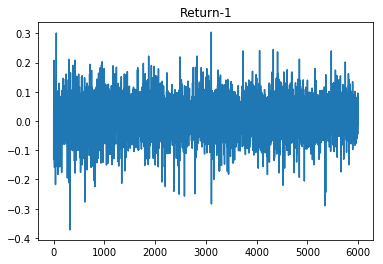

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

ep,return_ = zip(*total_returns_list)
return_ = [y_i-1 for y_i in return_]
return_ = pd.DataFrame(return_)
return_ = return_[return_<=25]

plt.plot(ep,return_)
plt.title('Return-1')
plt.show()

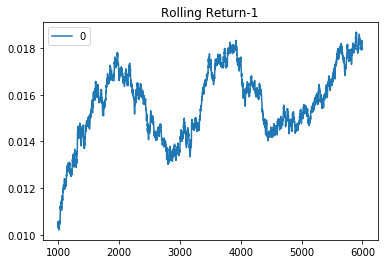

In [96]:
rolling_return = return_.rolling(1000).mean()
rolling_plot = rolling_return.plot(title='Rolling Return-1')

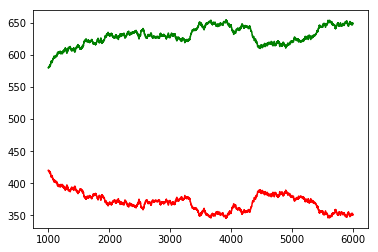

In [97]:
winning_trades = return_.applymap(lambda x: 1 if x>0 else 0)
winning_trades_1000 = winning_trades.rolling(1000).sum()
losing_trades = return_.applymap(lambda x: 1 if x<=0 else 0)
losing_trades_1000 = losing_trades.rolling(1000).sum()

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(winning_trades_1000.index,winning_trades_1000,color='green')
plt.plot(losing_trades_1000.index,losing_trades_1000,color='red')
plt.show()

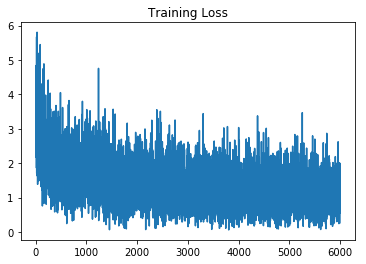

In [98]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

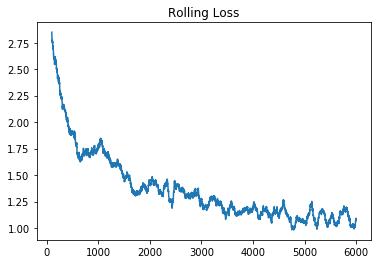

In [99]:
ep,reward = zip(*loss_list)
loss = pd.DataFrame(list(loss))
plt.plot(ep[:],loss.rolling(100).mean())
plt.title('Rolling Loss')
plt.show()

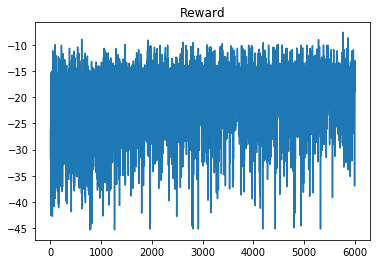

In [100]:
ep,reward = zip(*rewards_list)
plt.plot(ep[:],reward[:])
plt.title('Reward')
plt.show()

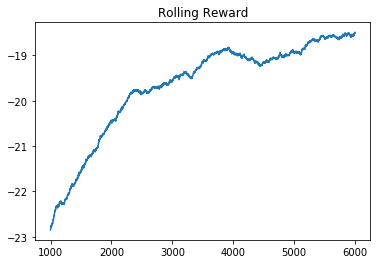

In [101]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
rolling_reward = reward.rolling(1000).mean()
plt.plot(ep[:],rolling_reward)
plt.title('Rolling Reward')
plt.show()

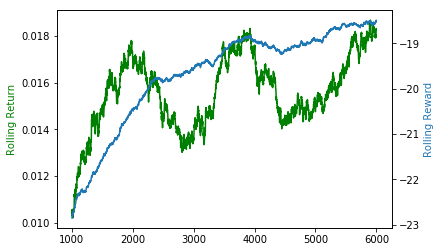

In [102]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ep[:], rolling_return, 'g-',label='Rolling return')
ax2.plot(ep[:], rolling_reward, label='Rolling reward')

ax1.set_ylabel('Rolling Return', color='g')
ax2.set_ylabel('Rolling Reward', color='C0')

plt.show()

### Testing

Function to run episode with random actions:

In [103]:
def run_random(prices,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres):
    
    actions = np.random.randint(0,3,size=len(prices))
    action_encoding = {0: 0, 1: 1, 2: -1}
    actions = [action_encoding[action] for action in actions]
    
    pos_log = []
    trade_log = []
    
    stop_loss = False
    take_profit = False
    day_pos=0
    
    pos = 0
    window_counter = 0
    
    for action in actions:
        if action*pos>=0 and stop_loss==False and take_profit==False:
            if abs(pos) < pos_limit:
                trade_log.append(action)
                pos += action #increase existing position or apply action if flat or hold
            else:
                trade_log.append(0) 
        else:
            #trade_log.append(action*(abs(pos)+0))
            trade_log.append(-pos)
            pos = 0 #action #close all existing positions and apply current action          
            
        pos_log.append(pos)
        
        #Store day when last position was openned (for stop_loss & take_profit calc)
        if (pos_log[window_counter]!=0) and (pos_log[window_counter-1]==0):        
            day_pos = window_counter
        
        #Calculate next day's open over all previous days' open (for stop_loss & take_profit trigger)
        if window_counter < trading_window-1:
            open_open_return = prices.iloc[window_counter+1]['Open'] / prices.iloc[:window_counter+1]['Open']
        else:
            open_open_return = prices.iloc[window_counter]['Close'] / prices.iloc[:window_counter+1]['Open']
        #Calculate active return (marked at Open_t+1)
        if pos != 0:
            today_return = [1+trade_log[i]*(open_open_return[i]-1) for i in range(day_pos,window_counter+1)]
            active_return = np.prod(today_return)
        else:
            active_return = 1   
        
        
        #Check stop_loss and take_profit
        stop_loss = True if active_return < stop_loss_thres else False
        take_profit = True if active_return > take_prof_thres else False
        
        
        window_counter += trading_freq
    
    close_open_returns = prices.iloc[-1]['Close'] / prices.iloc[:window_counter+1]['Open']
    close_returns = [1+trade_log[i]*(close_open_returns[i]-1) for i in range(len(close_open_returns))]
                
    total_return = np.prod(close_returns)
    
    return total_return
    

Function to run episode with trained model and random model:

In [104]:
def run_episode(env,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres,raw_data,verbose=1): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()
    i=0

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            #print('Day {:.0f} Open_day = {:.2f}, Close_epi = {:.2f}, Close_epi/Open_day = {:2f}, Trade = {:.0f}, Daily Return = {:.2f}'.format(i,info_log['prices'].iloc[i]['Open'],info_log['prices'].iloc[-1]['Close'],info_log['close_open_returns'][i],info_log['trades'][i],info_log['daily_return']))
            i += 1
            if done:
                break

    #run episode with random actions
    random_return = run_random(info_log['prices'],pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres)
                
    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    stop_loss_log = info_log['stop_loss_log']
    
    
    if verbose == 1 : #and info_log['total_return'] <= 1:
        print('Return: {:.3f}'.format(info_log['total_return']))
        print('Random return: {:.3f}'.format(random_return))
    
        %matplotlib inline
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(15,3))
        #Plot Prices
        plt.xticks(rotation=90)
        plt.grid(color='k', linestyle='--', linewidth=0.1)
        
        start_date = pd.to_datetime(plt_df.index[0]).strftime('%Y-%m-%d')
        end_date = pd.to_datetime(plt_df.index[-1]).strftime('%Y-%m-%d')
        
        #Plot some days before the start of the episode to see recent trends             
        start_index = np.where((raw_data.Open==plt_df.iloc[0].Open)&(raw_data.Close==plt_df.iloc[0].Close)&(raw_data.Volume==plt_df.iloc[0].Volume))[0][0]
        end_index = np.where((raw_data.Open==plt_df.iloc[-1].Open)&(raw_data.Close==plt_df.iloc[-1].Close)&(raw_data.Volume==plt_df.iloc[-1].Volume))[0][0]
        
        plt.plot(raw_data.iloc[max(start_index-10,0):start_index+1].index,raw_data.iloc[max(start_index-10,0):start_index+1].Open,'--',color='gray')
        plt.plot(raw_data.iloc[start_index:end_index+1].index,raw_data.iloc[start_index:end_index+1].Open,color='black')
        
        plt.ylim(min(raw_data.iloc[max(start_index-10,0):end_index].Open)*0.95, max(raw_data.iloc[max(start_index-10,0):end_index].Open)*1.05)
        plt.ylabel('Open Price')
        
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Open,
                    color='green',marker='^',s=100,zorder=3)
        #Plot Sells
        plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Open,
                    color='red',marker='v',s=100,zorder=3)

        for i, txt in enumerate(plt_df.Trades):
            if stop_loss_log[i]:
                    txt = str(txt) + ' (S)'
            if txt !=0:
                plt.annotate(txt, (plt_df.index[i], plt_df.Open[i]+0.02*plt_df.Open[i]))
                plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Open[i]-0.02*plt_df.Open[i]))

        plt.show()
    return info_log['total_return'], random_return

Set up environment for testing:

In [105]:
import gym
import gym_market
import numpy as np
import imp

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features_test, 
                  'raw_data':raw_data_test}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


Run tests:

Return: 0.992
Random return: 0.997


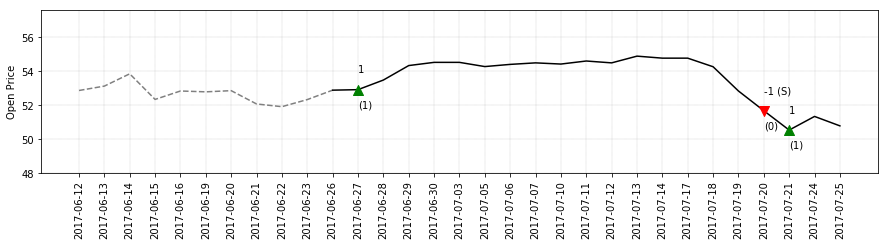

Return: 1.036
Random return: 1.023


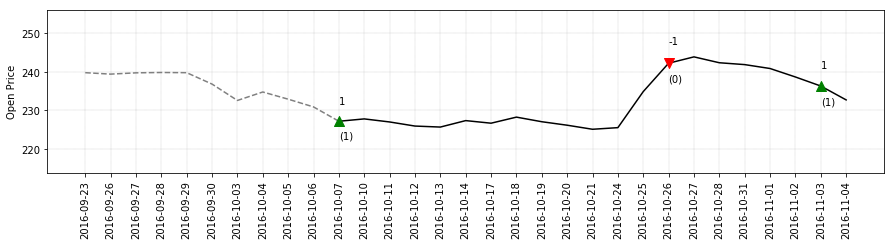

Return: 0.983
Random return: 0.964


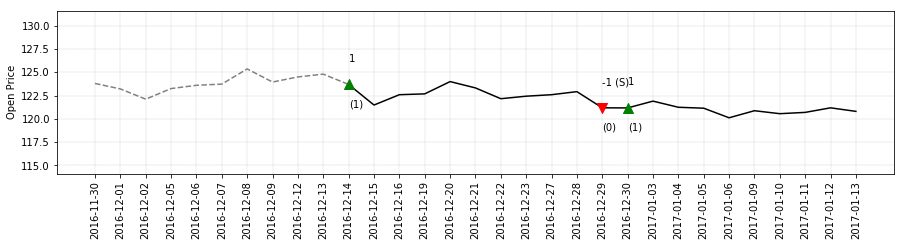

Return: 1.003
Random return: 0.970


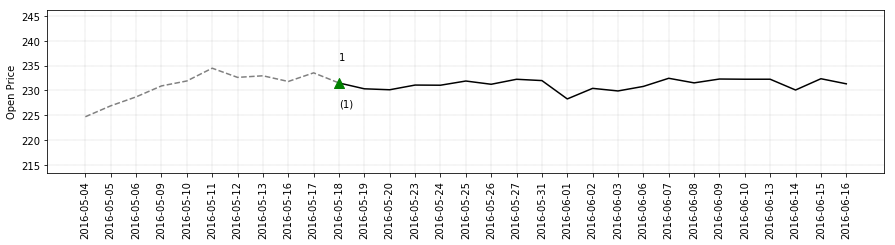

Return: 1.037
Random return: 1.054


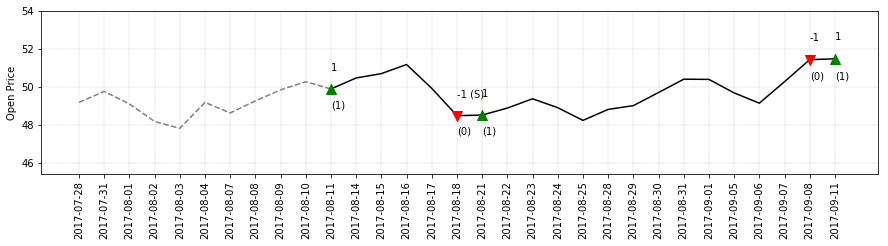

Return: 0.942
Random return: 0.976


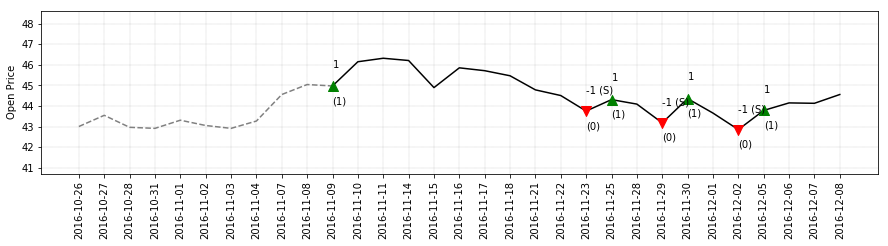

Return: 1.095
Random return: 0.896


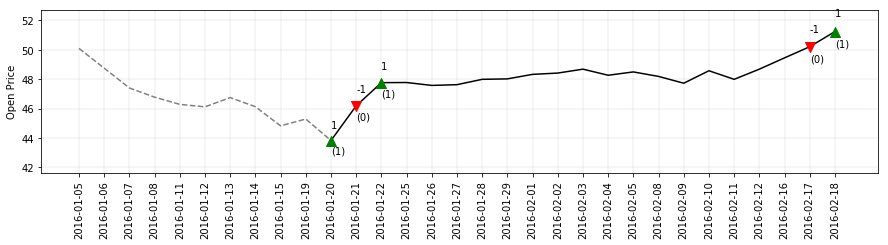

Return: 0.997
Random return: 1.155


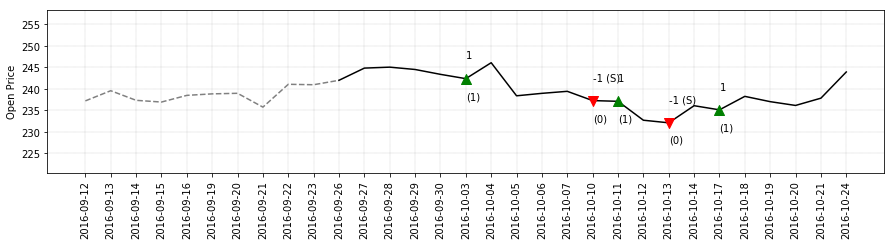

Return: 1.020
Random return: 0.964


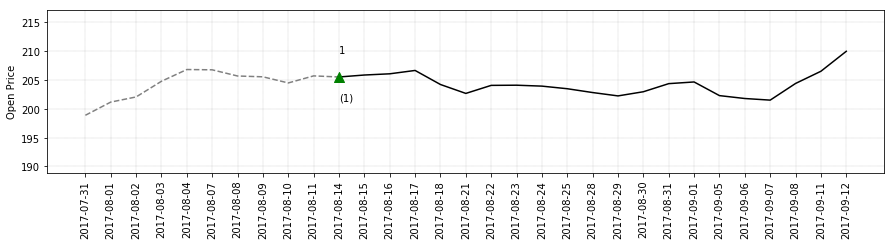

Return: 1.041
Random return: 0.949


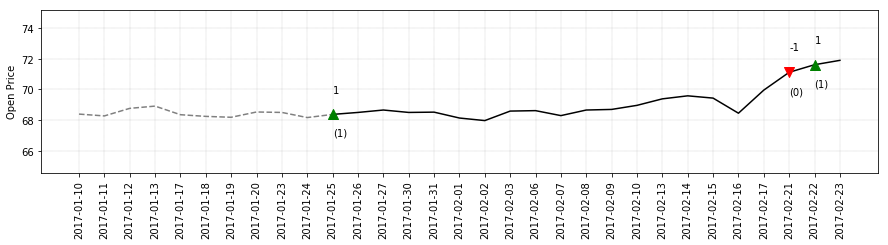

Return: 1.033
Random return: 0.956


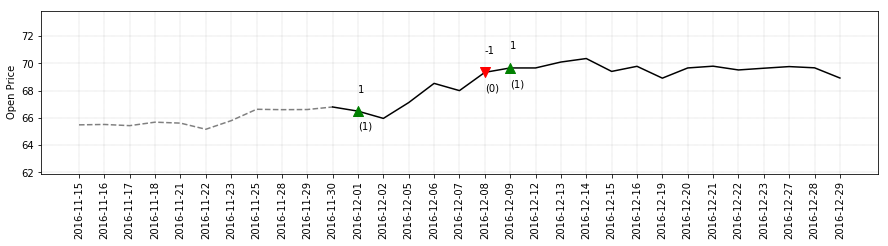

Return: 1.008
Random return: 1.026


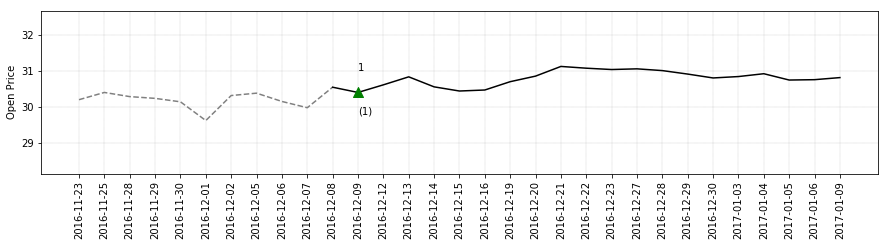

Return: 1.037
Random return: 1.091


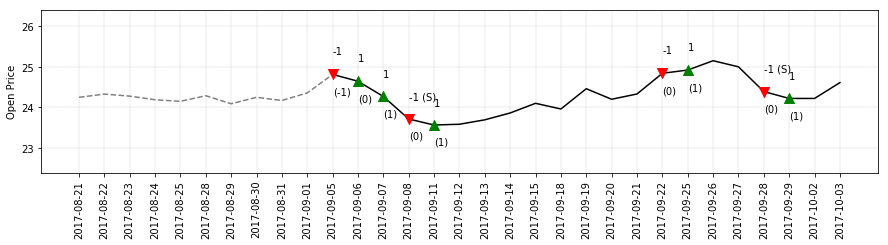

Return: 1.027
Random return: 1.039


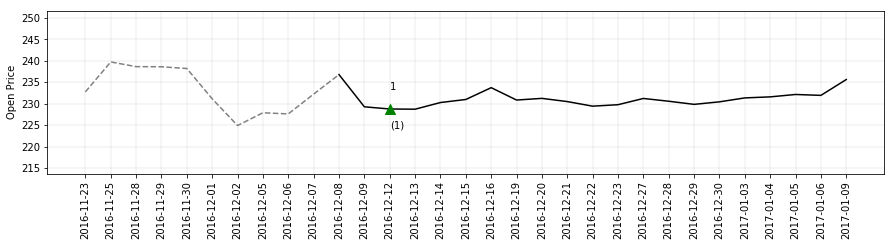

Return: 1.140
Random return: 0.999


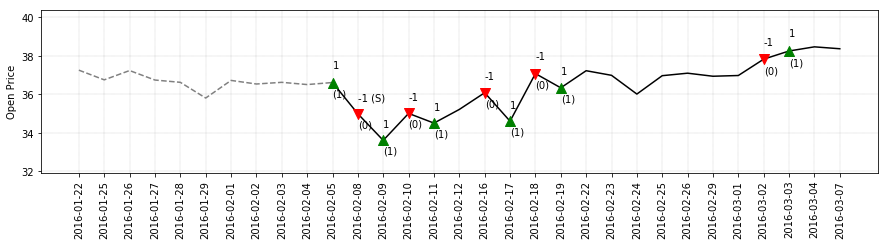

Return: 0.988
Random return: 1.022


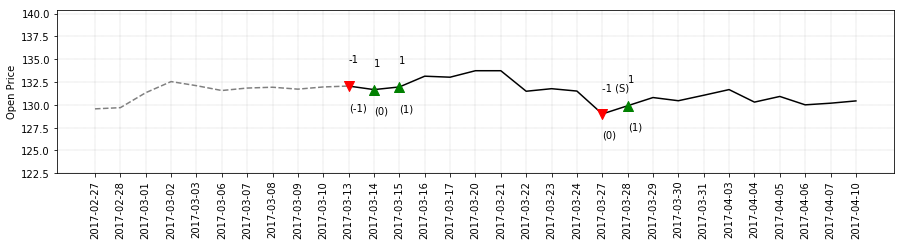

Return: 0.940
Random return: 0.897


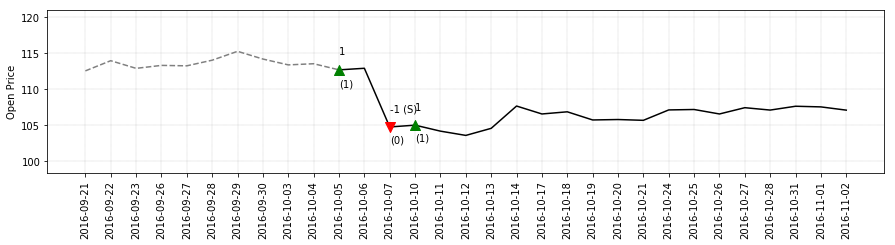

Return: 1.024
Random return: 0.982


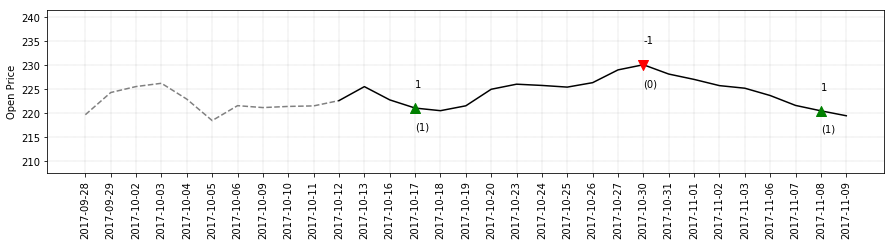

Return: 1.012
Random return: 0.948


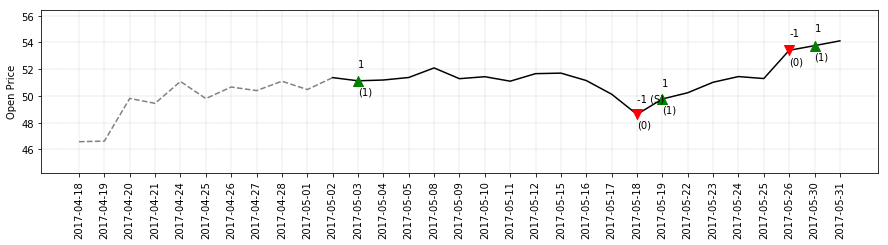

Return: 1.021
Random return: 0.994


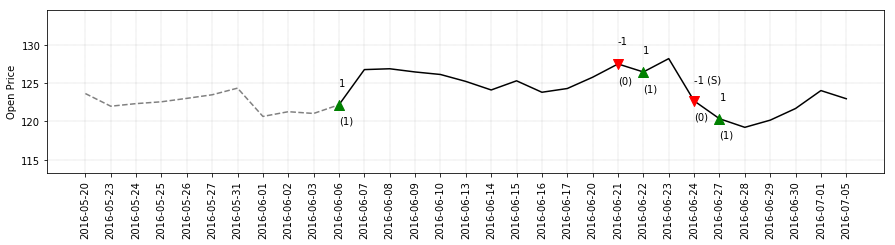

Return: 1.050
Random return: 0.948


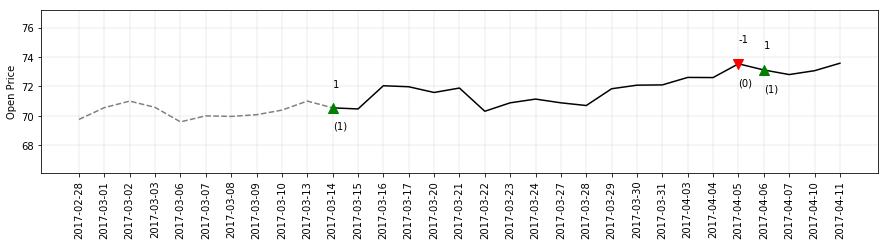

Return: 0.976
Random return: 1.032


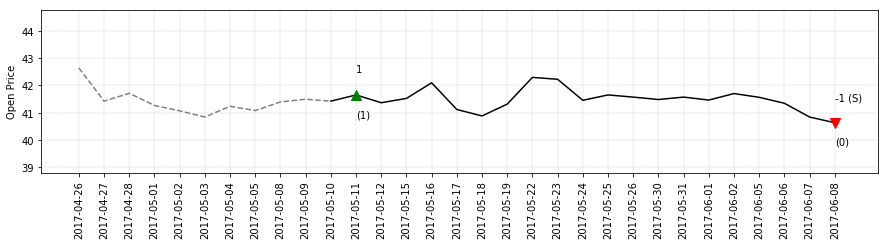

Return: 1.020
Random return: 0.994


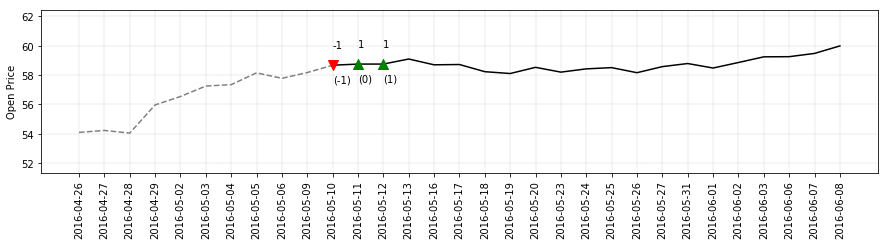

Return: 1.001
Random return: 0.943


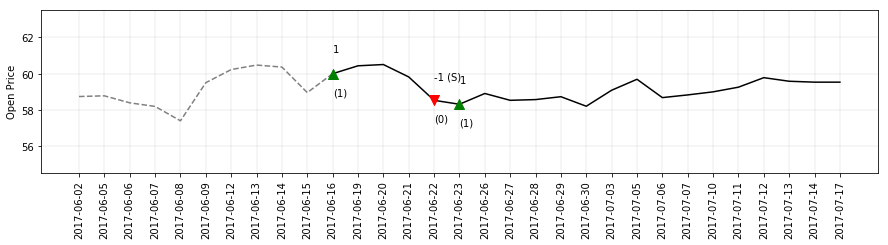

Return: 1.006
Random return: 1.030


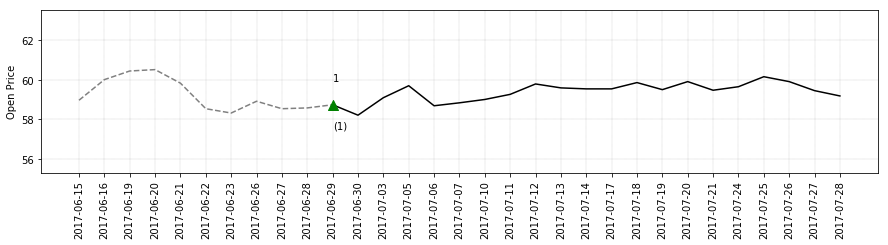

Return: 1.012
Random return: 1.032


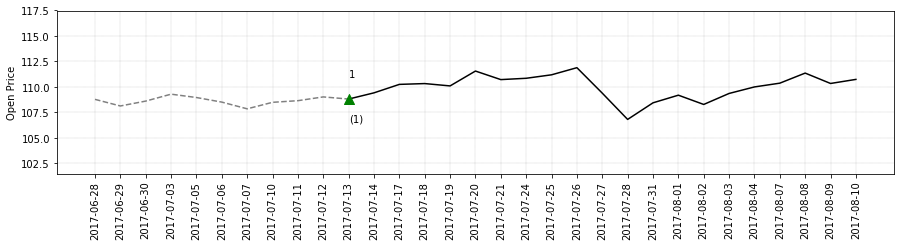

Return: 1.047
Random return: 1.026


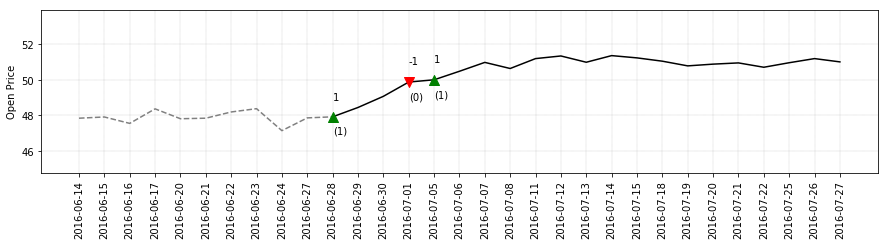

Return: 1.029
Random return: 0.952


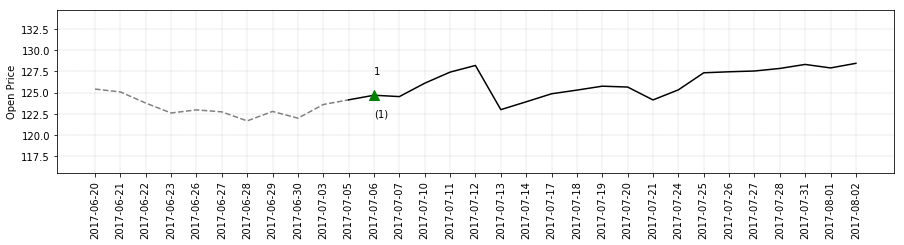

Return: 0.974
Random return: 1.007


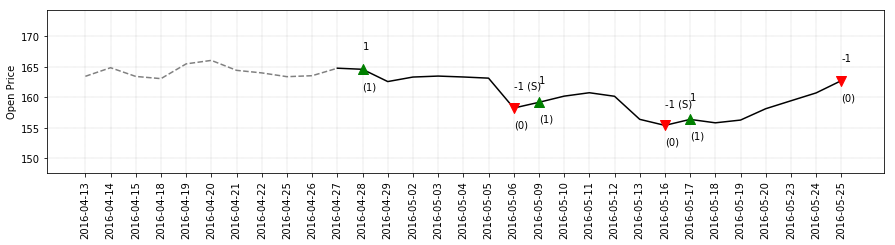

Return: 1.102
Random return: 1.022


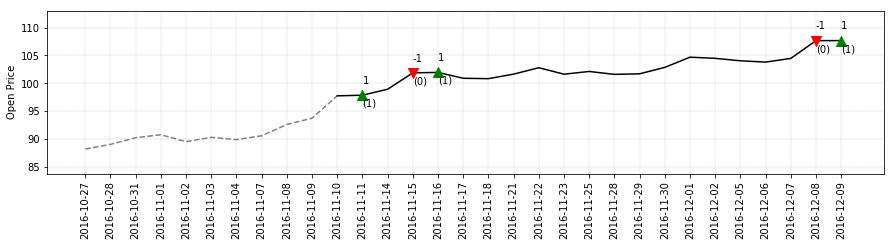

Return: 1.044
Random return: 1.005


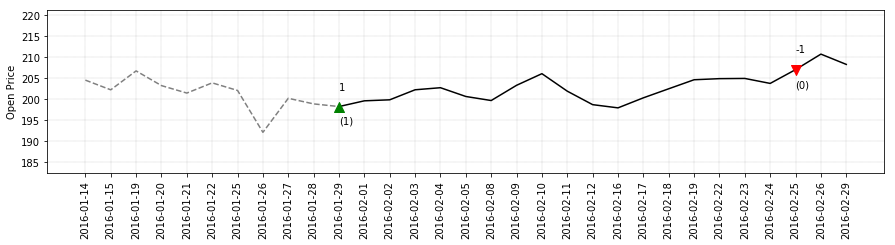

Return: 1.012
Random return: 1.029


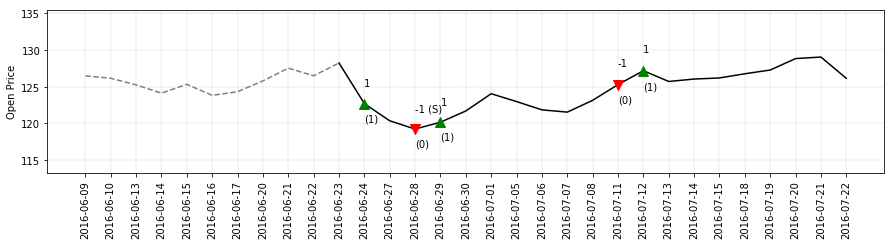

Return: 1.013
Random return: 0.969


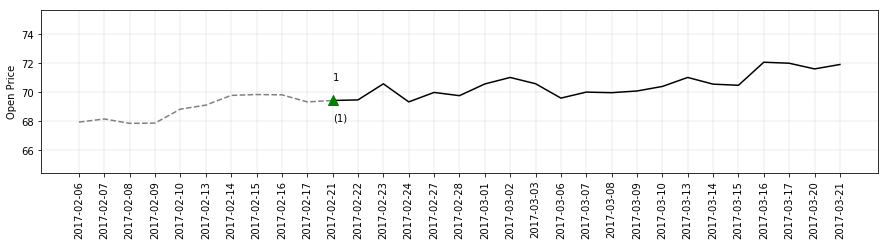

Return: 1.003
Random return: 0.944


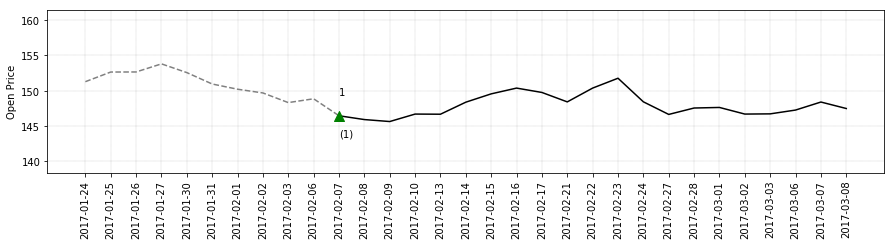

Return: 1.071
Random return: 1.019


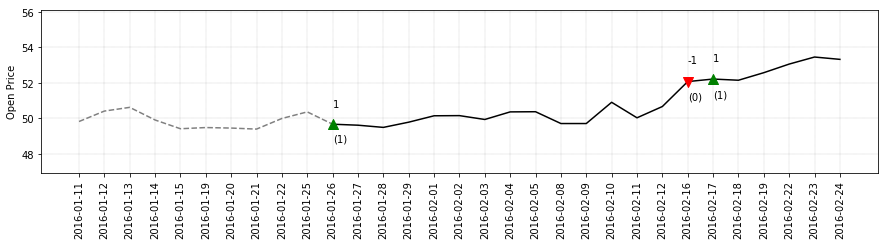

Return: 1.101
Random return: 1.018


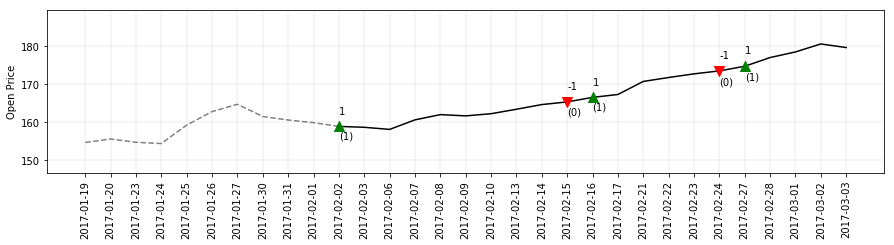

Return: 1.027
Random return: 0.980


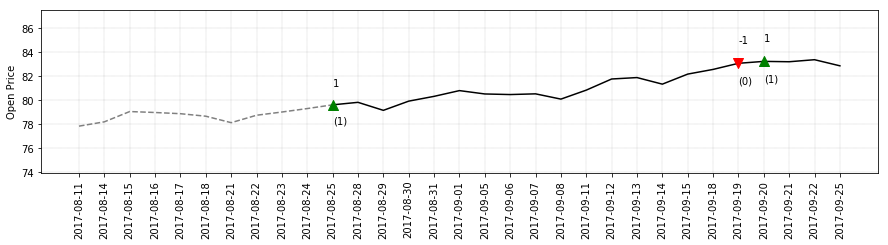

Return: 1.030
Random return: 0.949


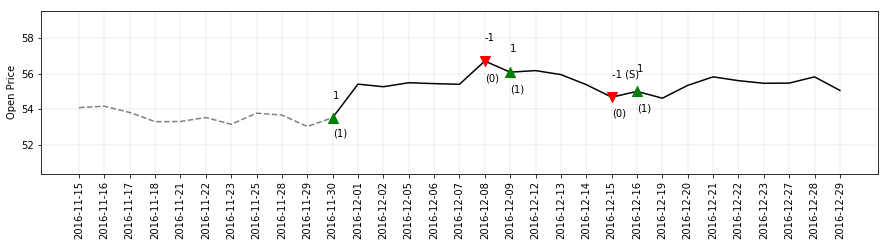

Return: 1.000
Random return: 1.023


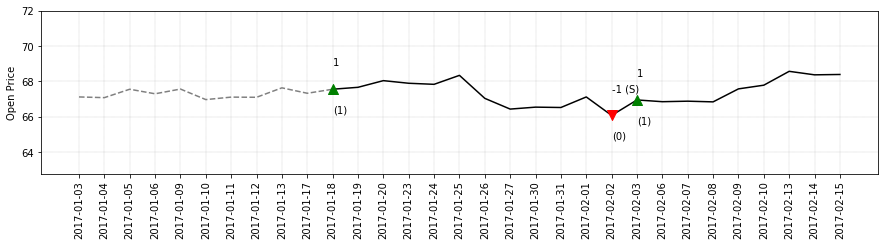

Return: 0.998
Random return: 1.035


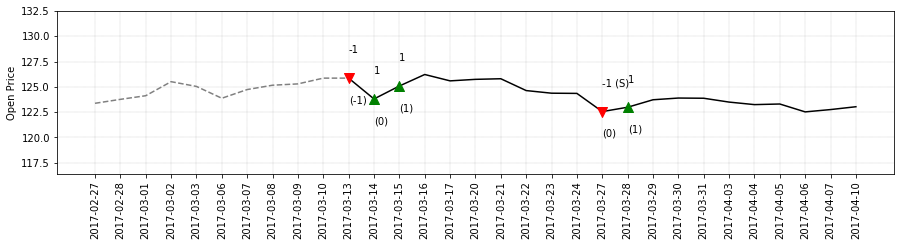

Return: 0.993
Random return: 0.917


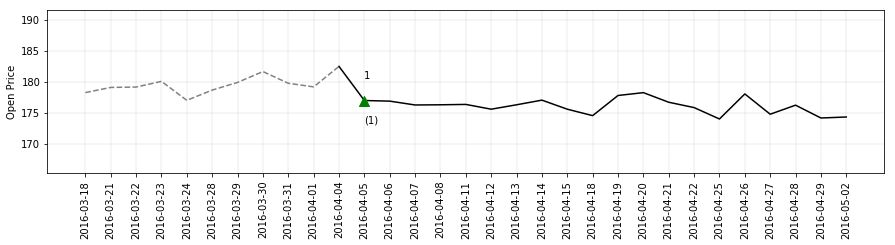

Return: 0.978
Random return: 0.984


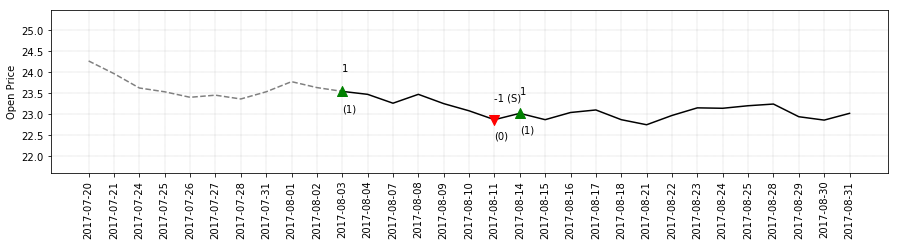

Return: 0.960
Random return: 1.064


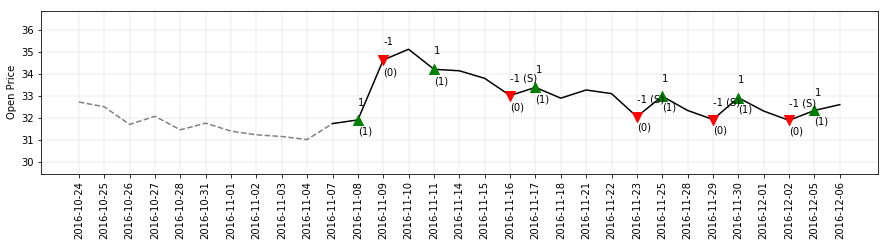

Return: 0.991
Random return: 1.079


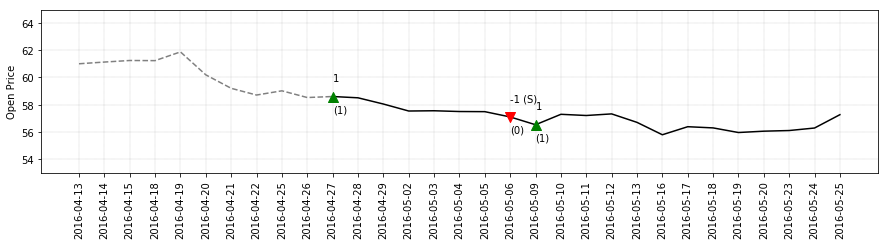

Return: 0.963
Random return: 1.090


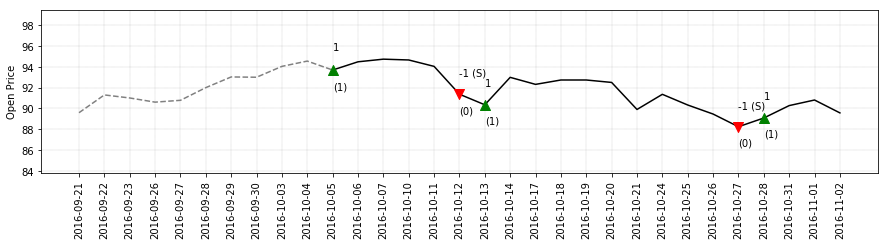

Return: 1.026
Random return: 1.079


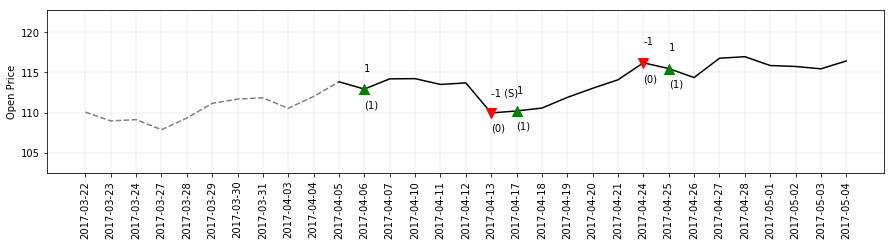

Return: 1.052
Random return: 0.991


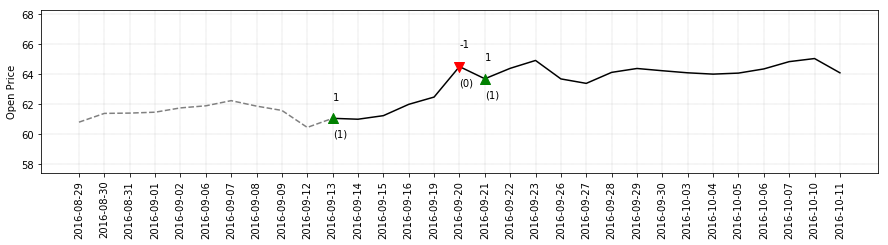

Return: 1.045
Random return: 0.992


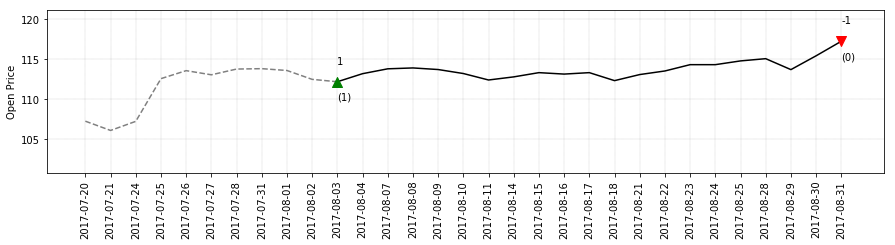

Return: 1.079
Random return: 1.014


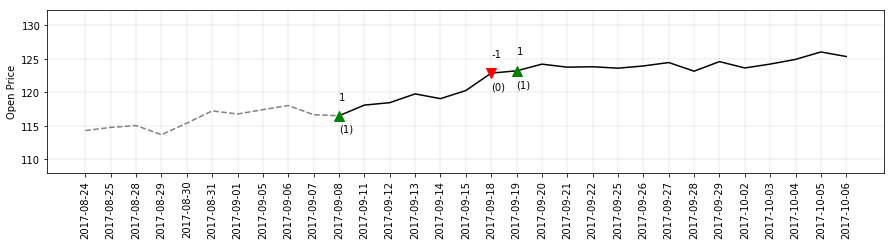

Return: 0.844
Random return: 0.898


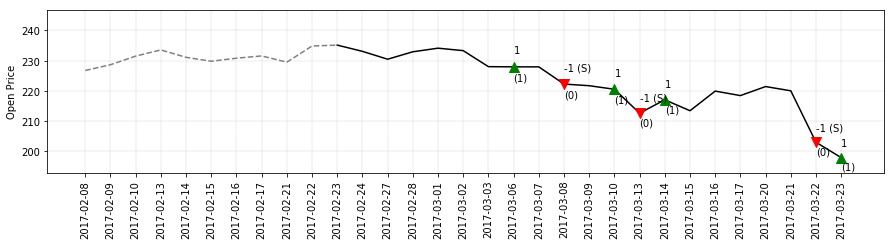

Return: 1.016
Random return: 0.905


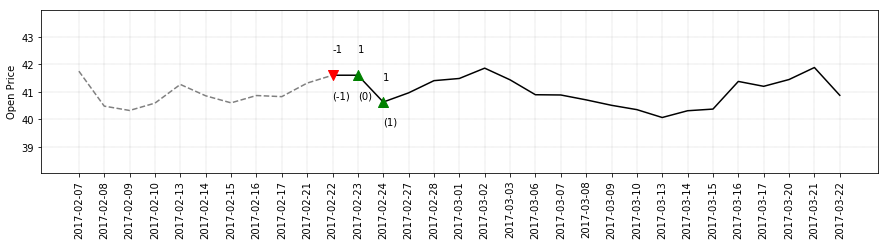

Return: 1.023
Random return: 0.976


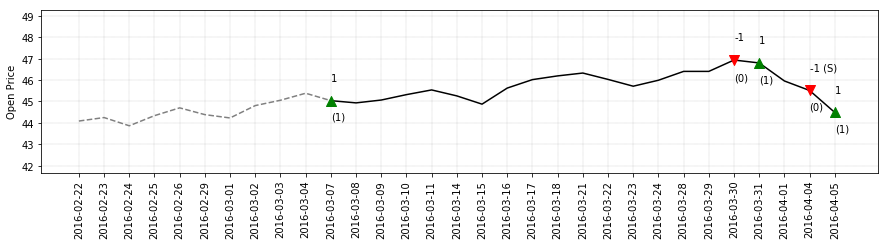

Return: 1.003
Random return: 1.012


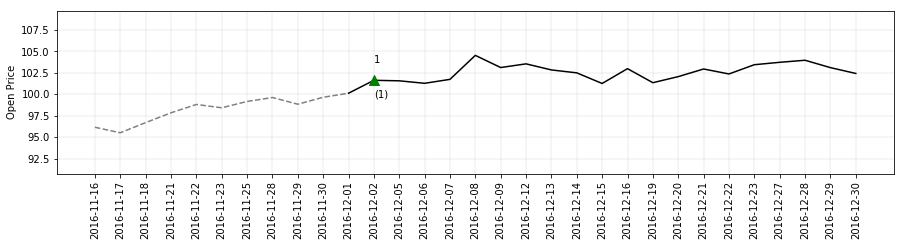

Return: 1.023
Random return: 1.044


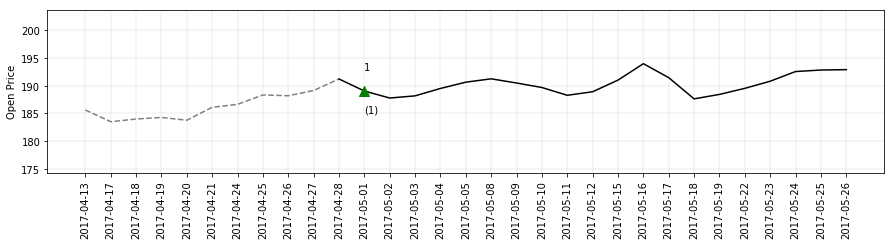

Return: 0.999
Random return: 1.024


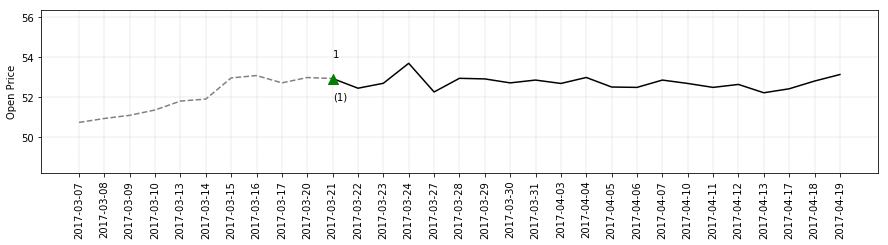

Return: 0.998
Random return: 1.085


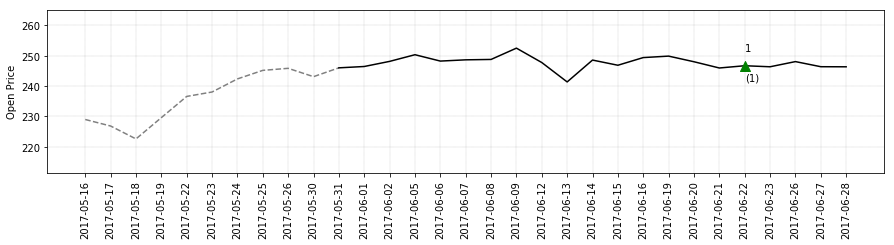

Return: 1.044
Random return: 1.217


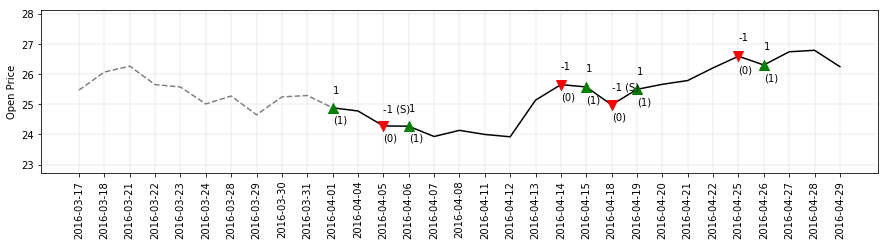

Return: 1.045
Random return: 0.964


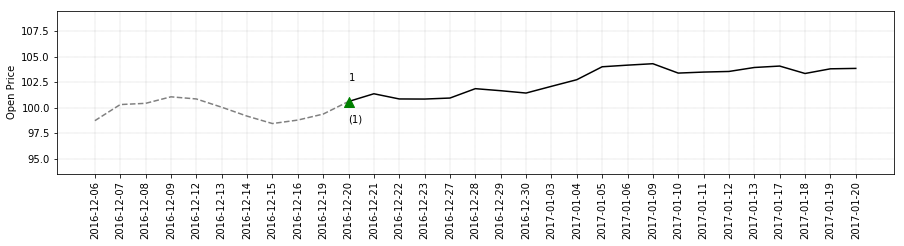

Return: 1.061
Random return: 0.984


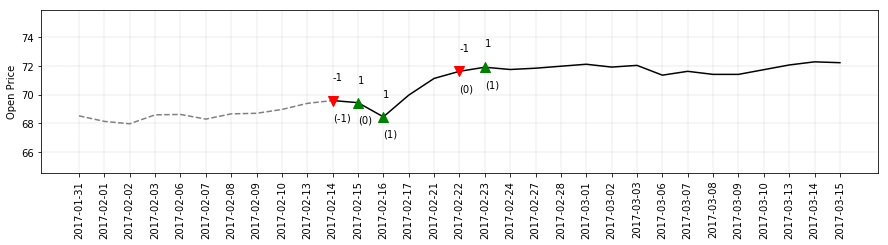

Return: 1.044
Random return: 0.910


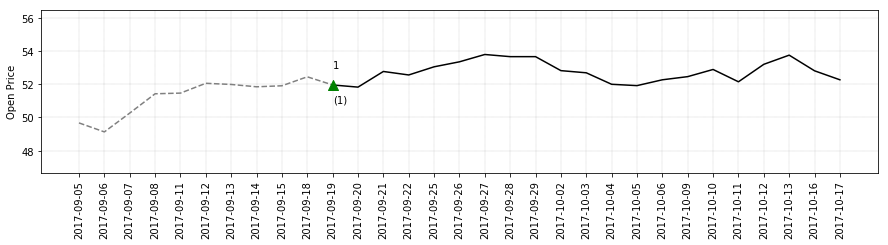

Return: 1.098
Random return: 1.055


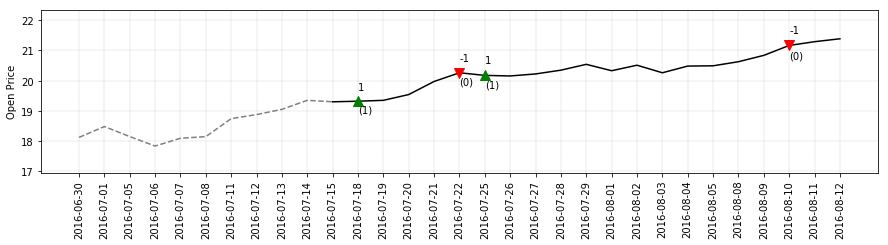

Return: 1.039
Random return: 0.893


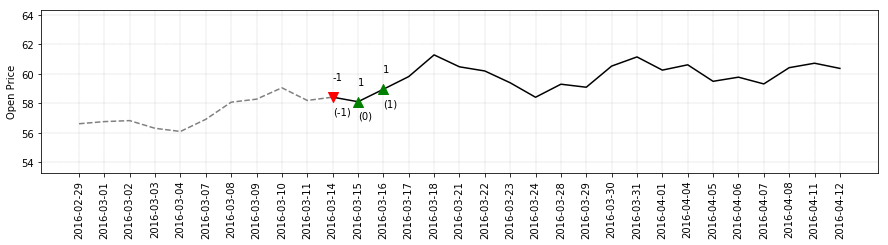

Return: 1.013
Random return: 0.878


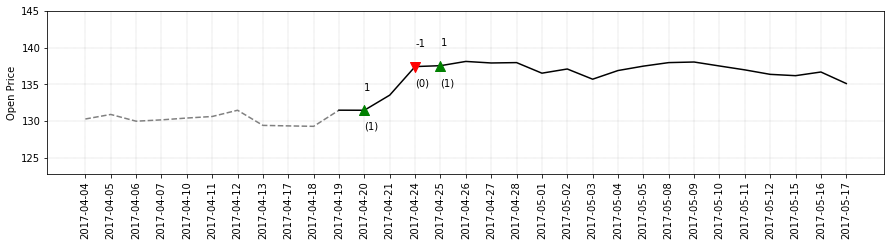

Return: 1.042
Random return: 1.036


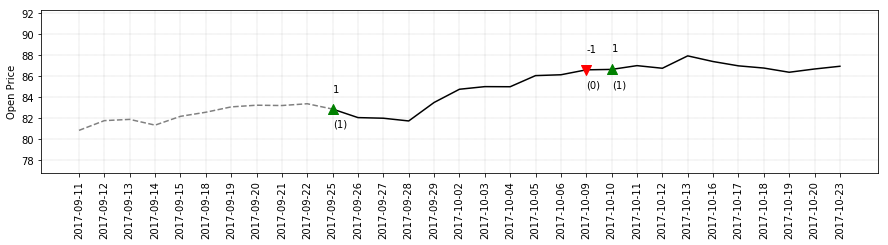

Return: 1.009
Random return: 1.050


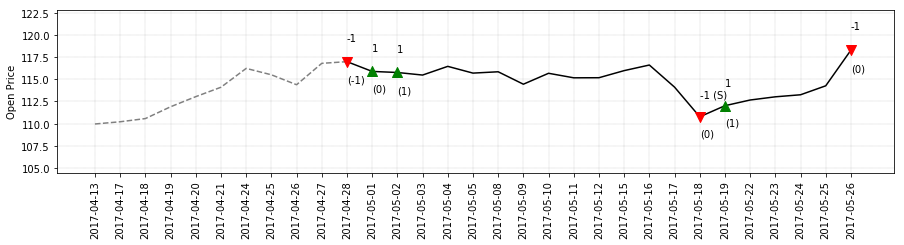

Return: 1.048
Random return: 0.902


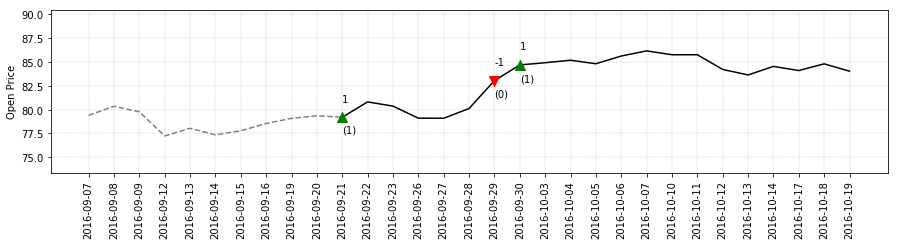

Return: 1.029
Random return: 0.954


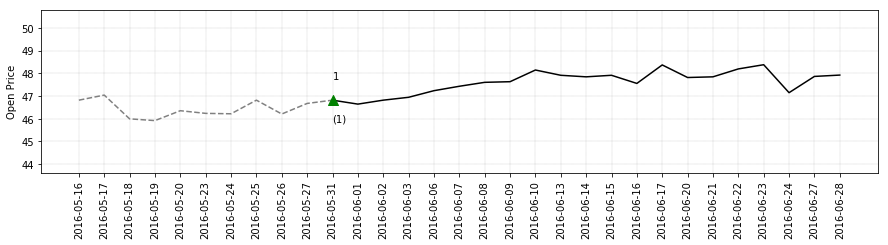

Return: 1.016
Random return: 0.939


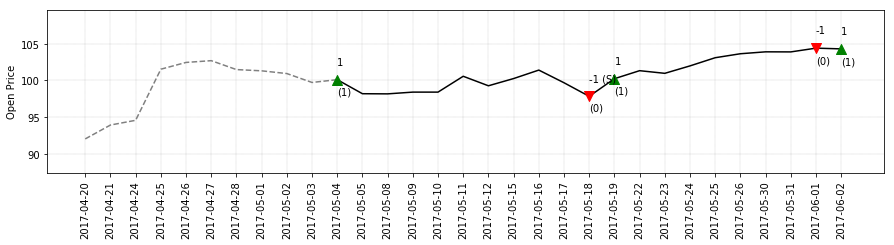

Return: 1.028
Random return: 1.004


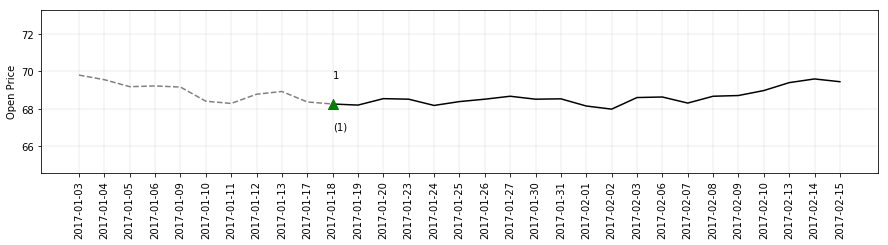

Return: 0.993
Random return: 1.029


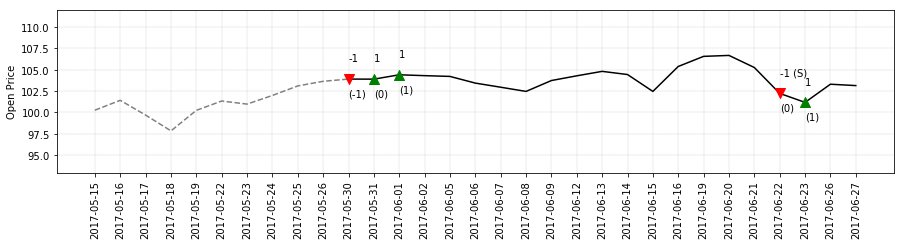

Return: 1.020
Random return: 0.931


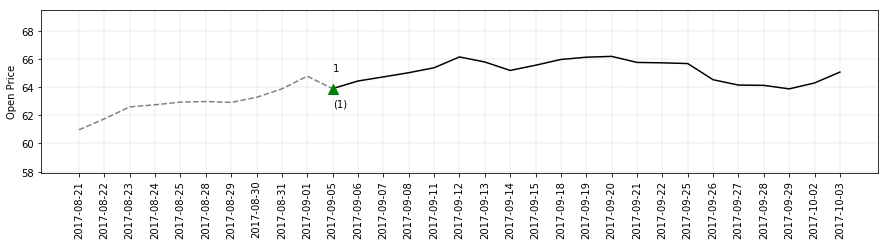

Return: 1.075
Random return: 0.972


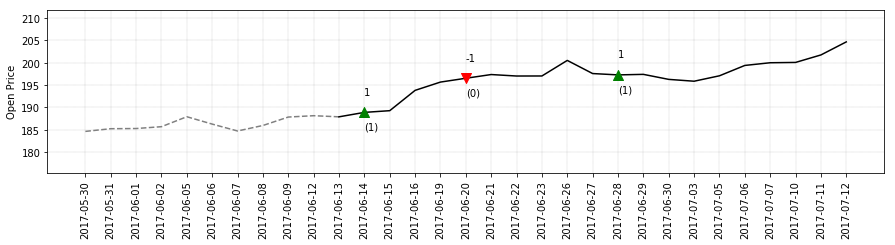

Return: 0.954
Random return: 0.923


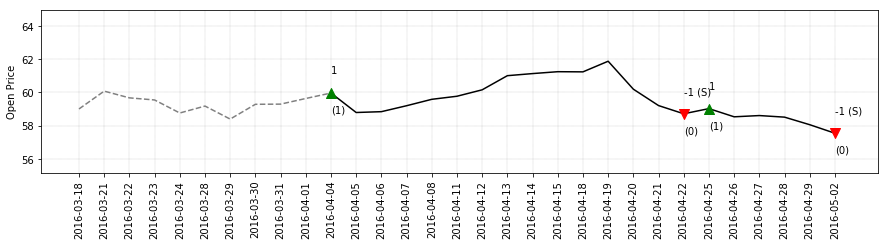

Return: 1.000
Random return: 0.987


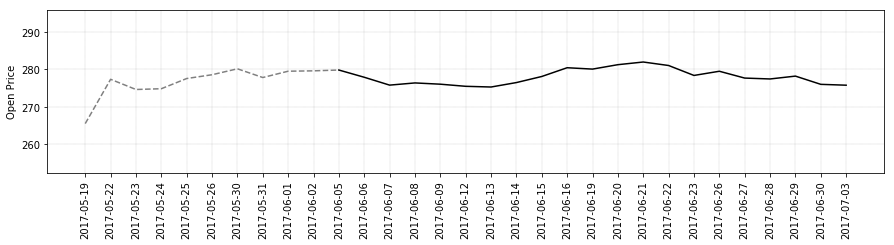

Return: 1.035
Random return: 0.961


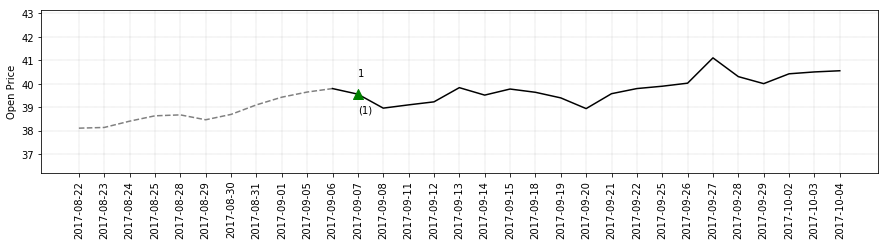

Return: 1.017
Random return: 1.014


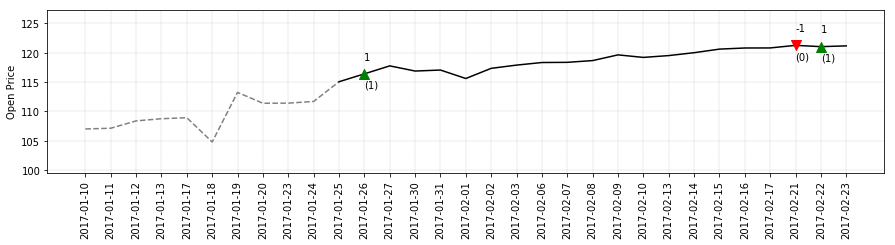

Return: 0.961
Random return: 0.948


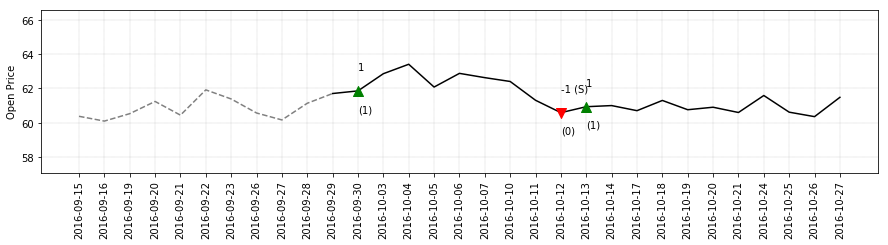

Return: 0.987
Random return: 0.962


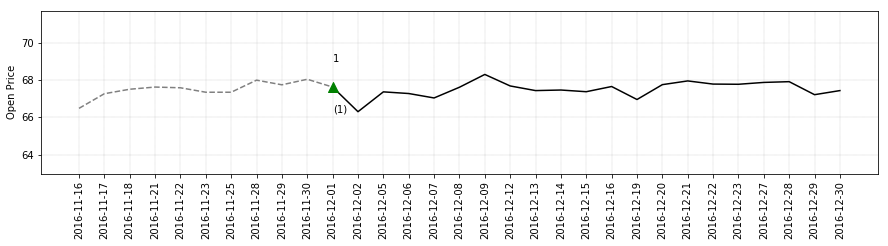

Return: 1.030
Random return: 0.984


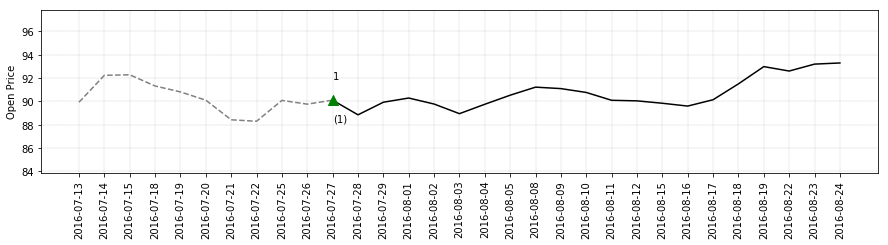

Return: 1.011
Random return: 1.062


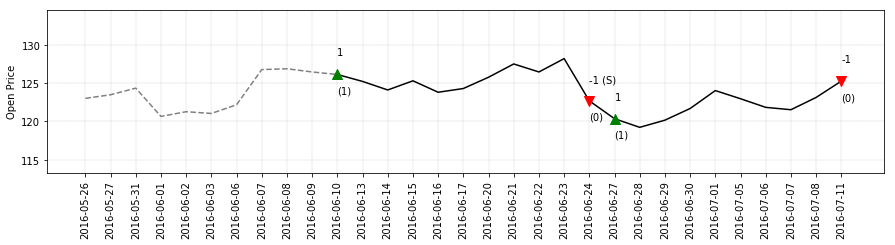

Return: 0.978
Random return: 1.084


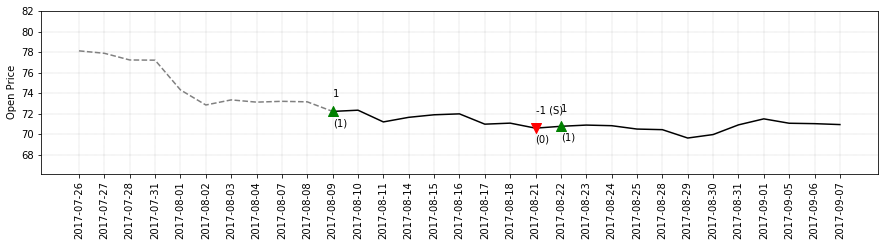

Return: 1.074
Random return: 0.974


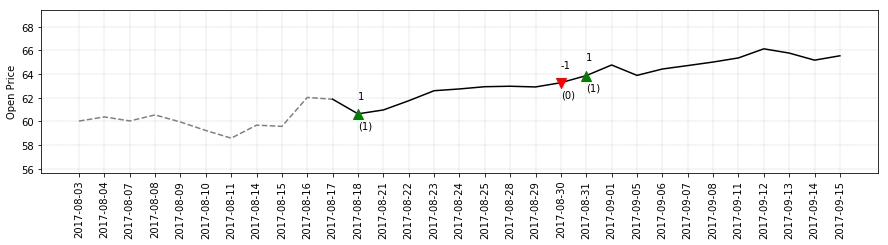

Return: 1.000
Random return: 1.007


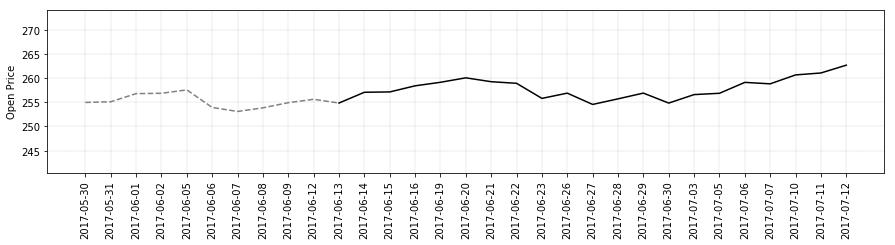

Return: 1.044
Random return: 0.973


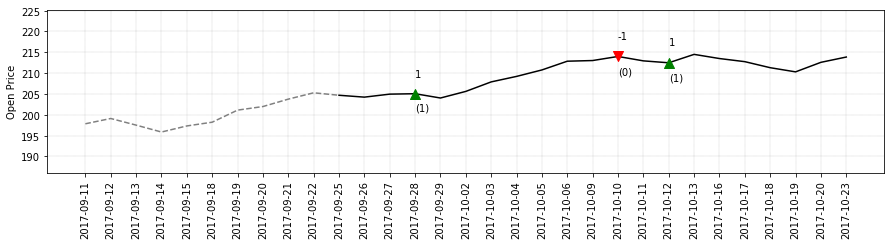

Return: 0.995
Random return: 1.003


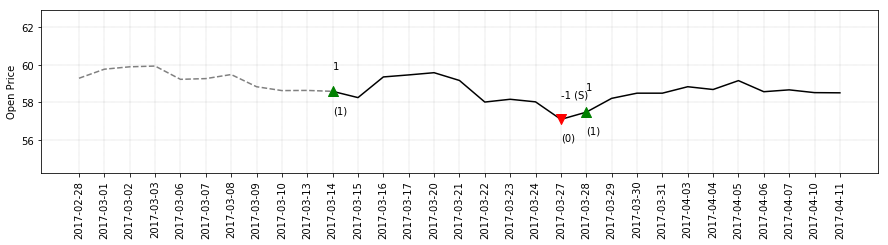

Return: 0.983
Random return: 0.951


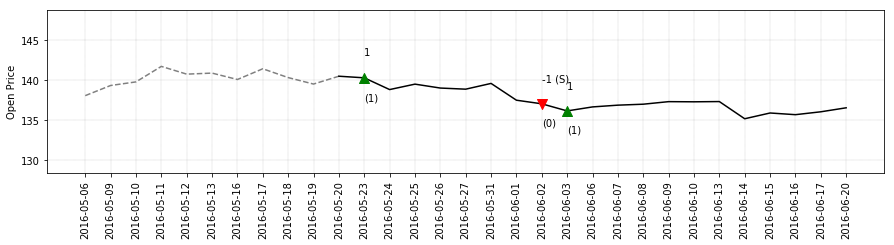

Return: 0.957
Random return: 0.895


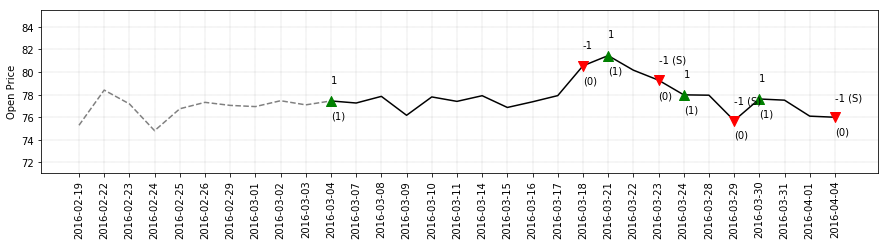

Return: 1.003
Random return: 1.045


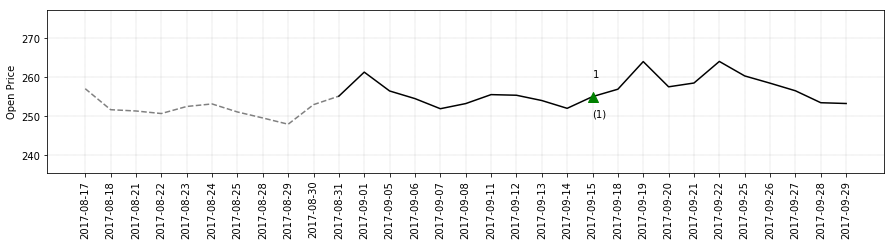

Return: 1.074
Random return: 0.982


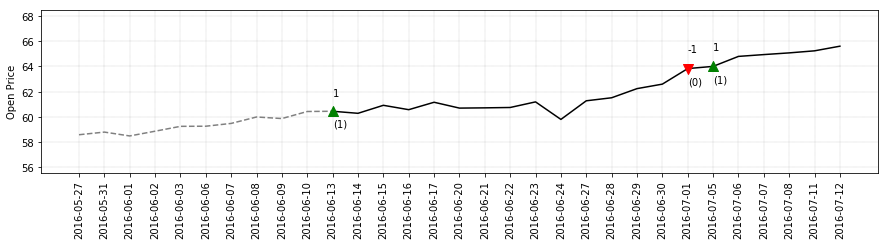

Return: 1.002
Random return: 1.005


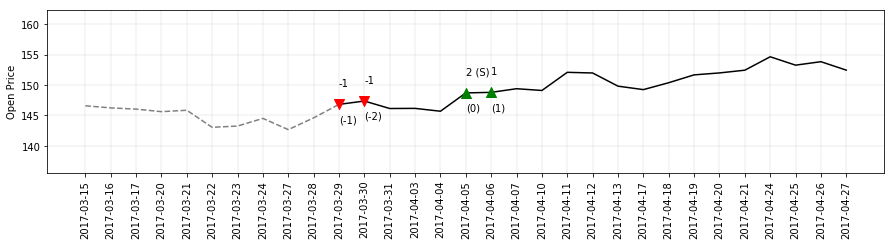

Return: 1.000
Random return: 1.047


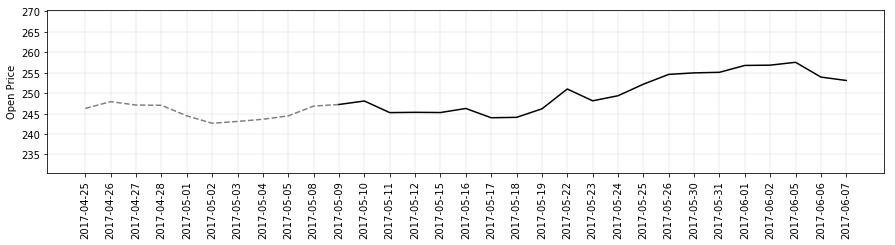

Return: 1.006
Random return: 1.015


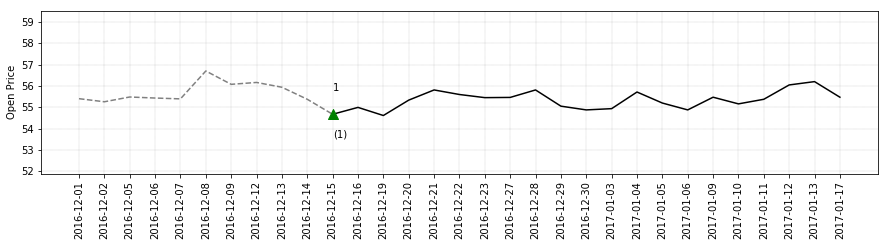

Return: 1.053
Random return: 0.794


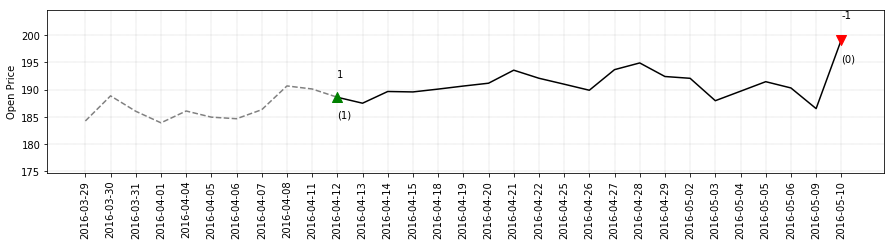

Return: 1.000
Random return: 1.008


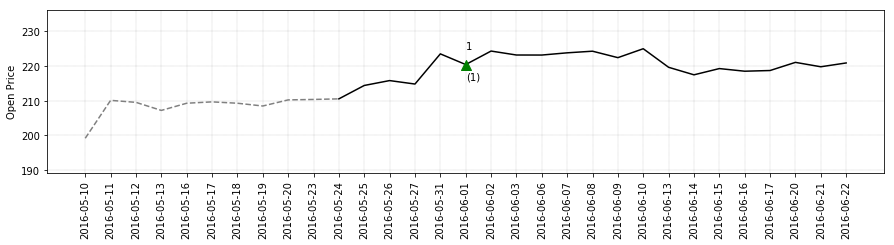

Return: 1.000
Random return: 0.923


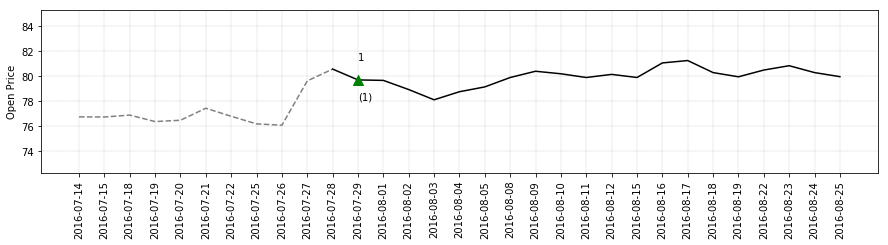

Return: 0.928
Random return: 1.065


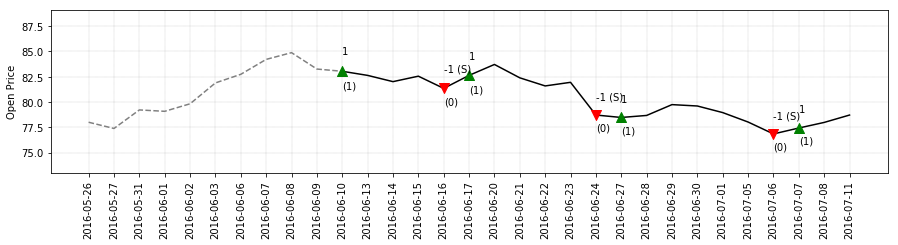

Return: 1.018
Random return: 1.018


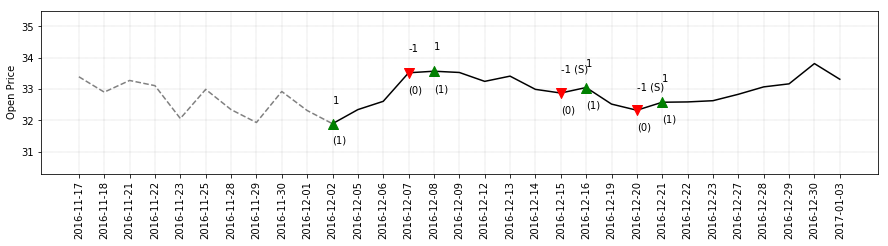

Return: 1.028
Random return: 0.953


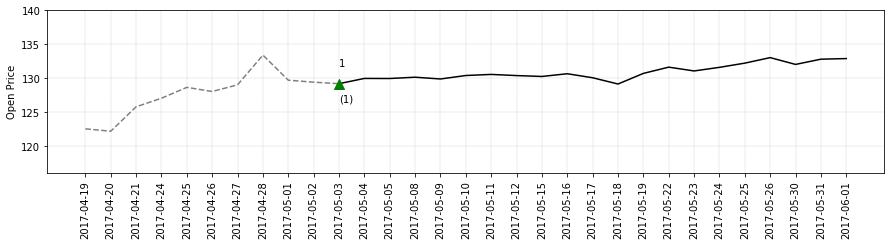

Return: 1.019
Random return: 1.065


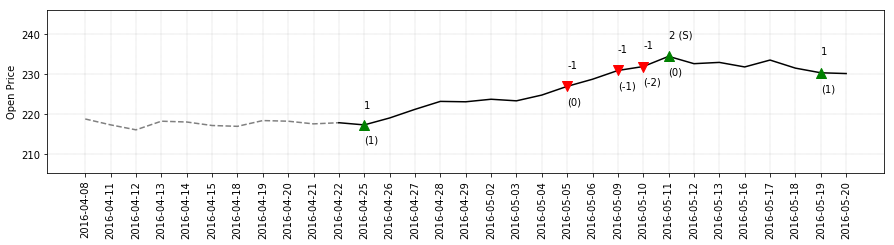

Return: 1.066
Random return: 0.939


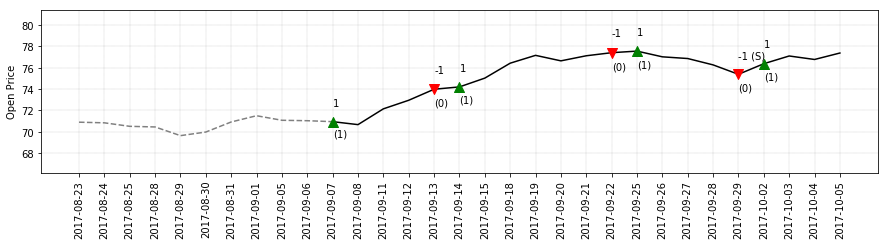

Return: 1.240
Random return: 0.995


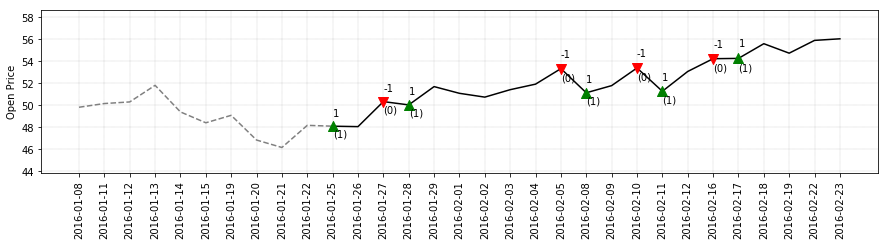

Return: 1.048
Random return: 1.010


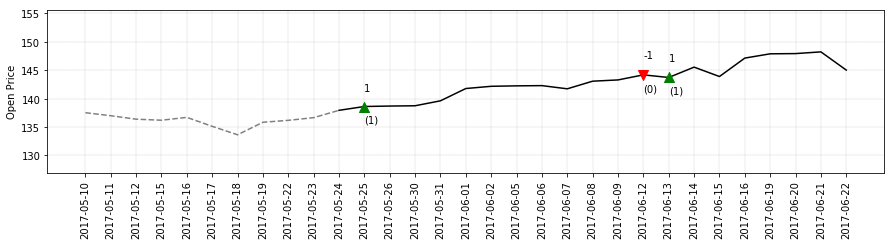

Return: 0.969
Random return: 0.950


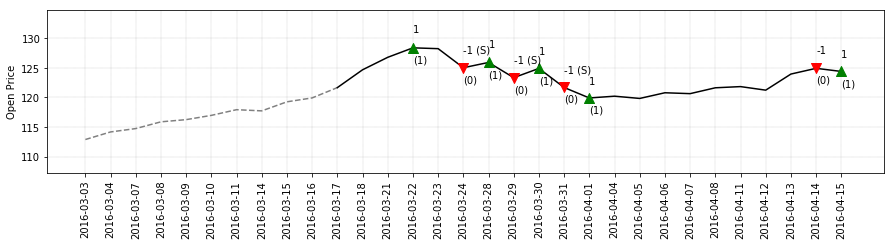

Return: 0.956
Random return: 1.059


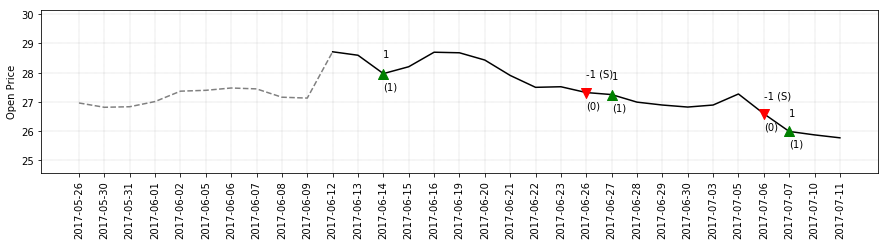

Return: 1.044
Random return: 1.049


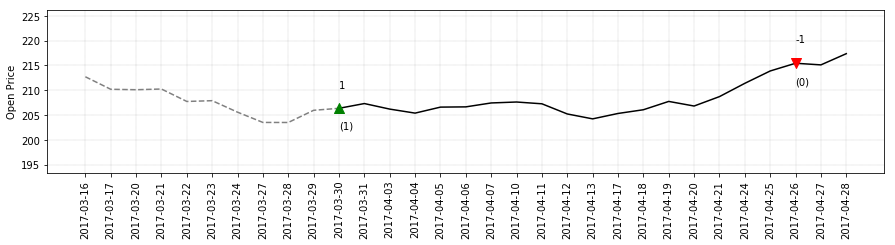

Return: 0.980
Random return: 1.062


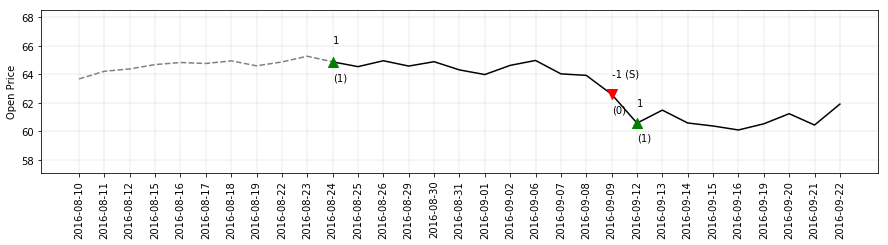

Return: 0.987
Random return: 1.024


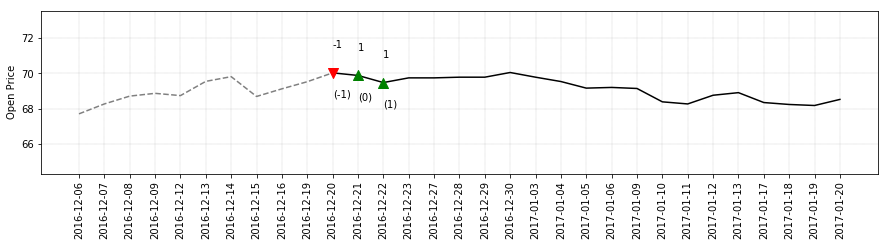

Return: 0.994
Random return: 0.961


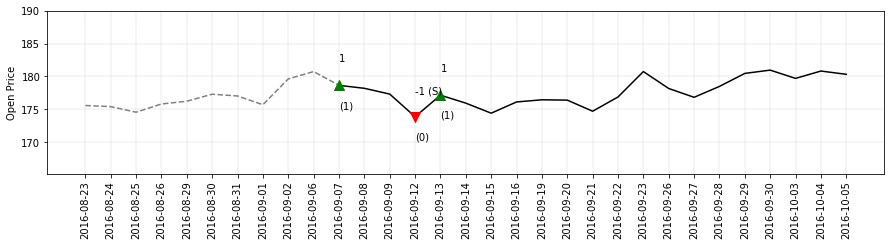

Return: 0.931
Random return: 0.859


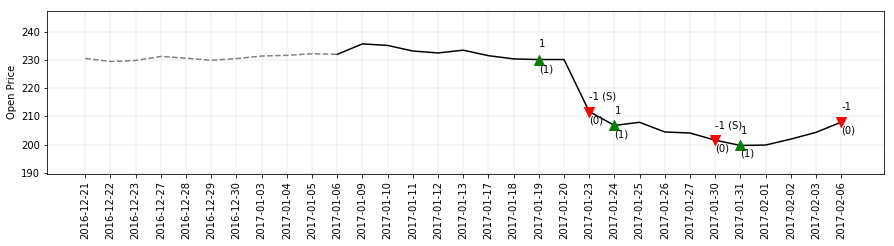

Return: 0.998
Random return: 1.040


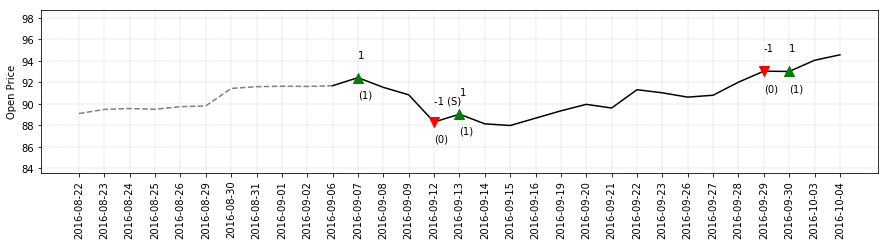

Return: 1.011
Random return: 0.899


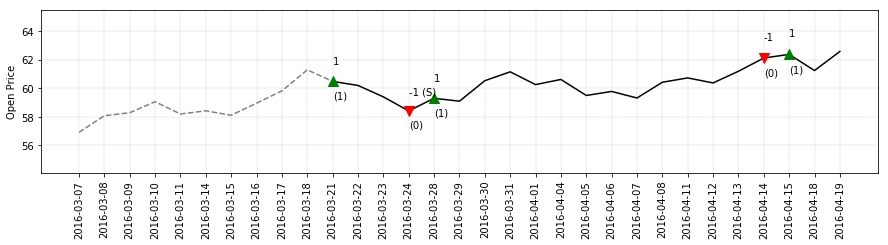

Return: 0.941
Random return: 1.019


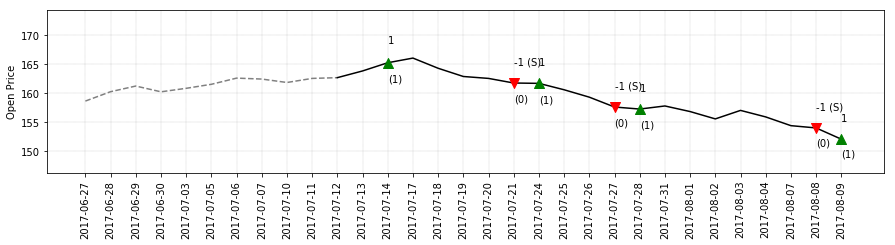

Return: 0.994
Random return: 1.002


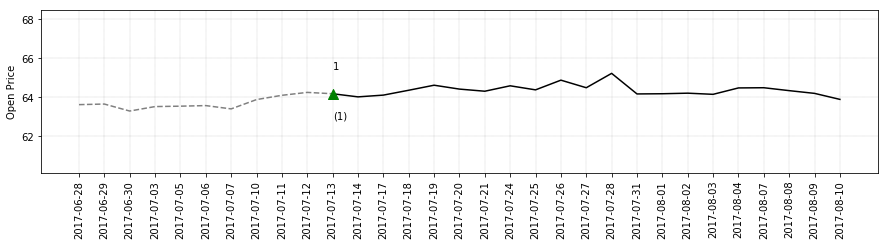

Return: 1.056
Random return: 1.068


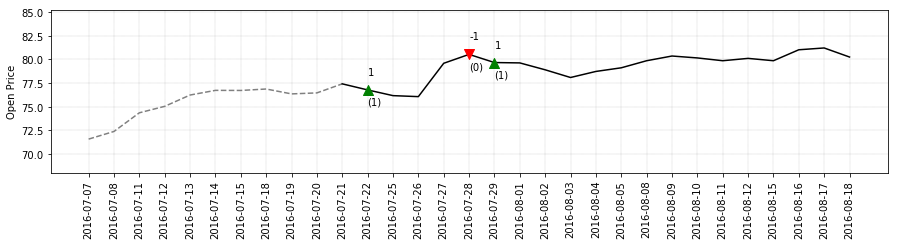

Return: 1.057
Random return: 1.024


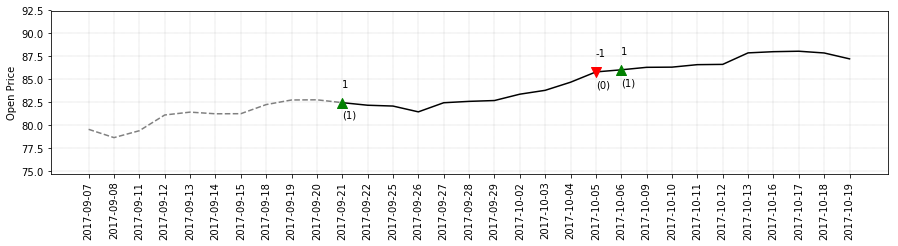

Return: 0.955
Random return: 0.990


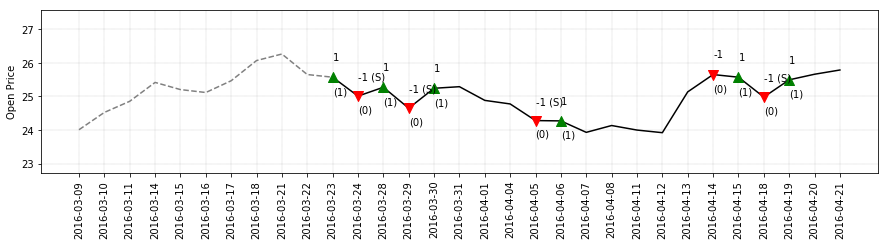

Return: 1.027
Random return: 0.974


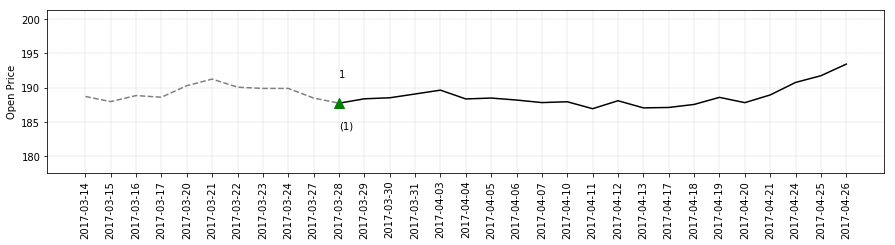

Return: 0.980
Random return: 1.020


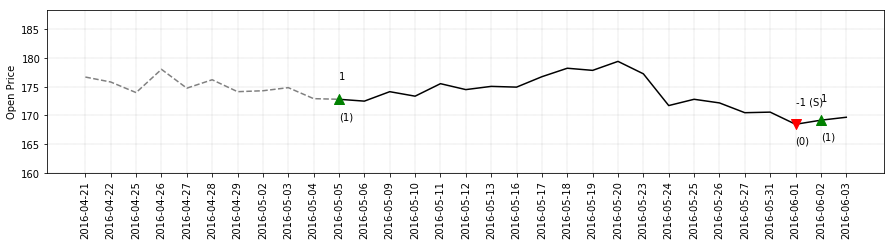

Return: 0.958
Random return: 0.969


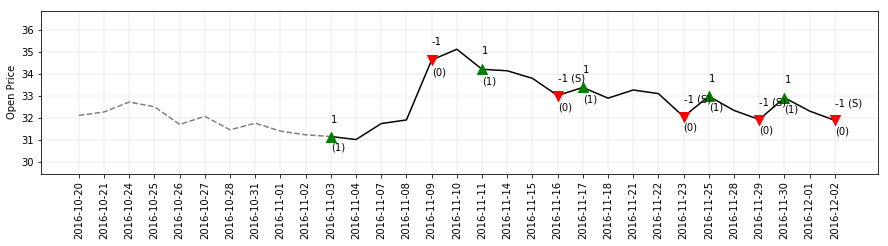

Return: 1.033
Random return: 0.985


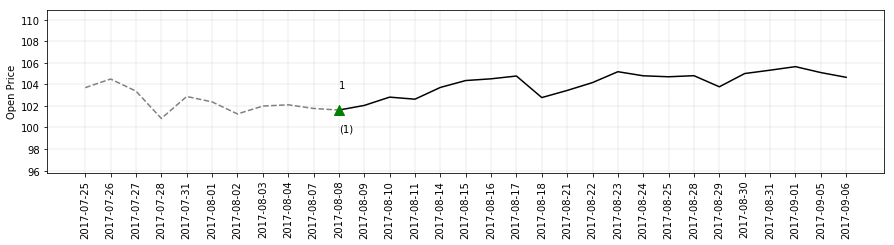

Return: 1.000
Random return: 0.972


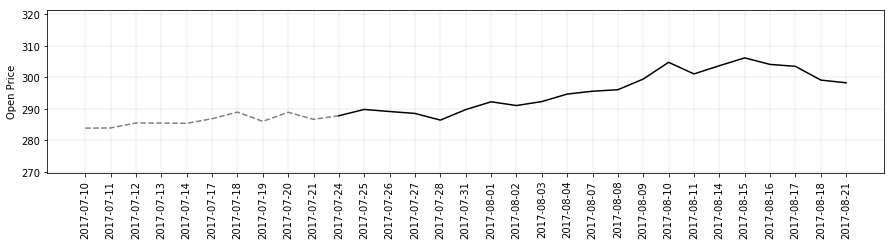

Return: 0.865
Random return: 1.047


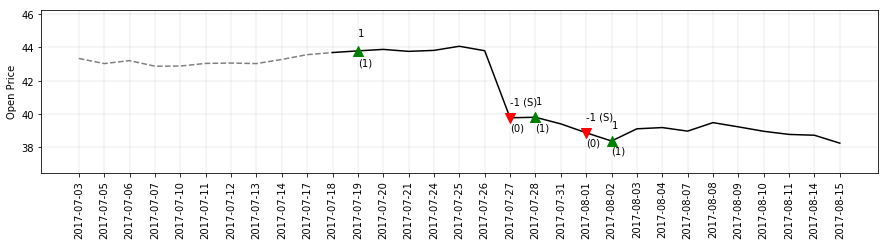

Return: 0.983
Random return: 1.145


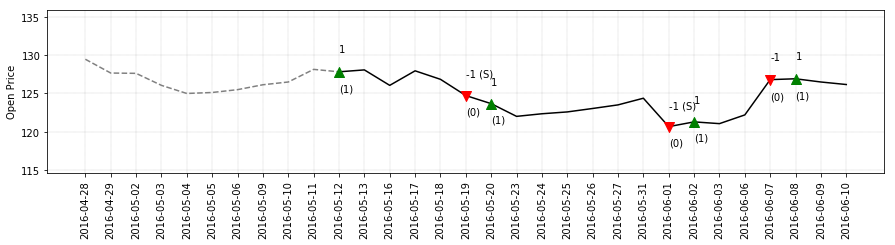

Return: 1.022
Random return: 0.961


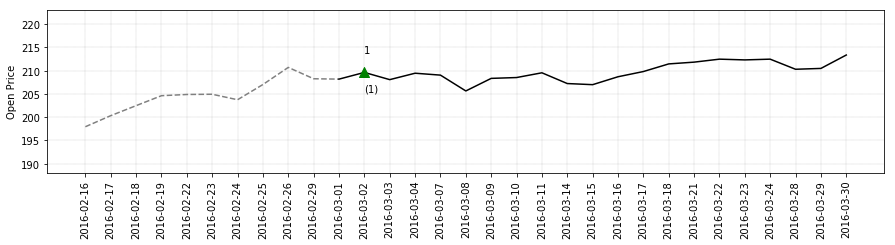

Return: 0.929
Random return: 0.932


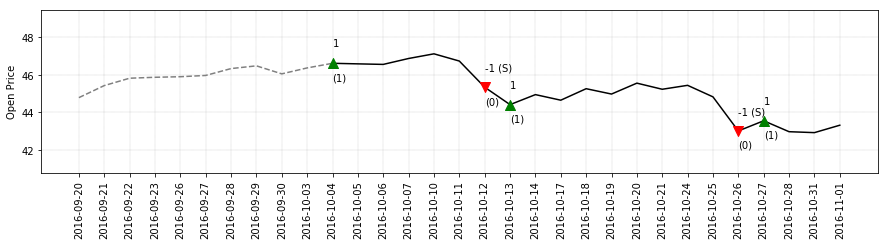

Return: 0.855
Random return: 1.013


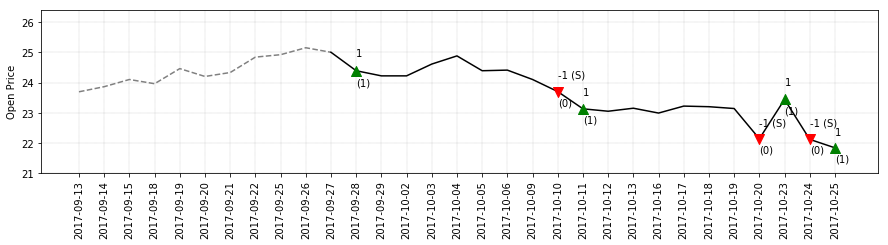

Return: 0.932
Random return: 1.003


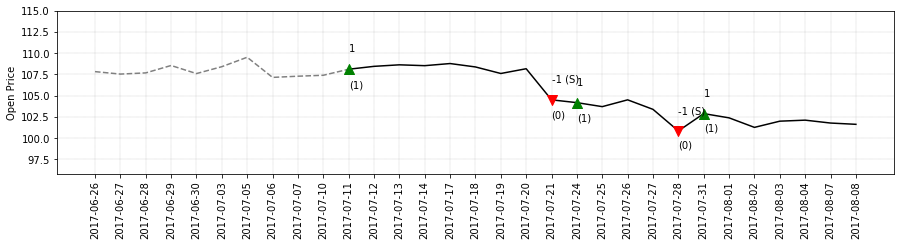

Return: 1.037
Random return: 0.940


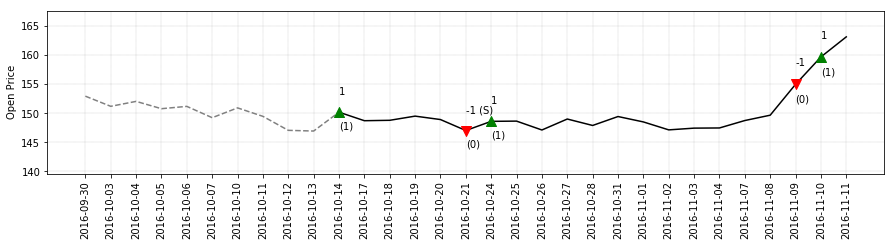

Return: 0.964
Random return: 1.123


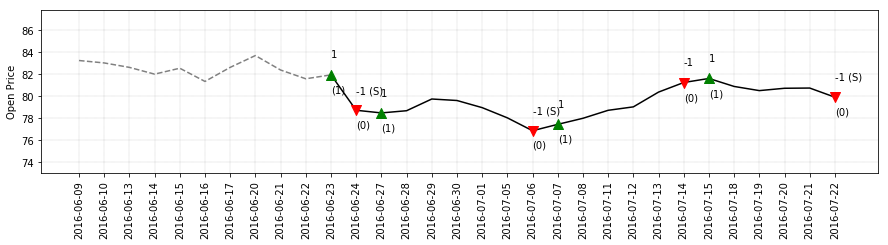

Return: 1.064
Random return: 0.938


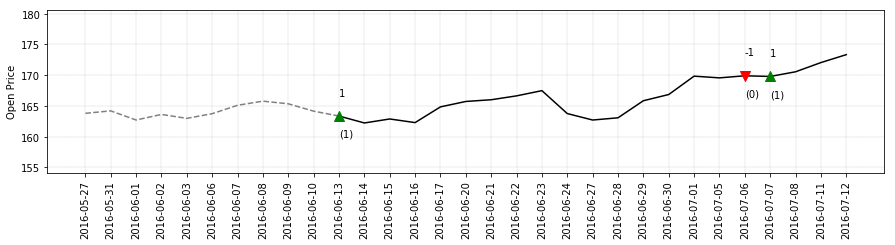

Return: 0.976
Random return: 1.033


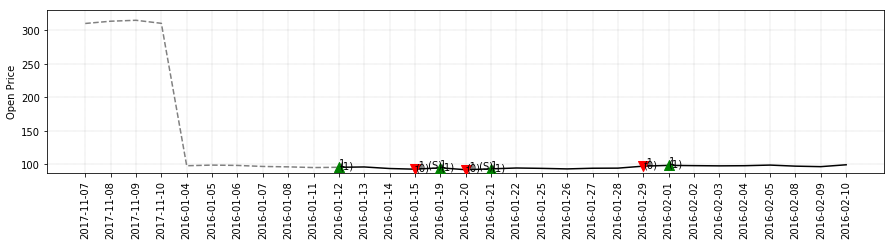

Return: 0.979
Random return: 0.913


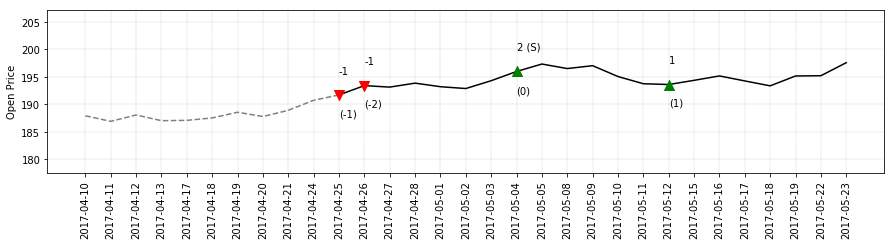

Return: 0.978
Random return: 0.884


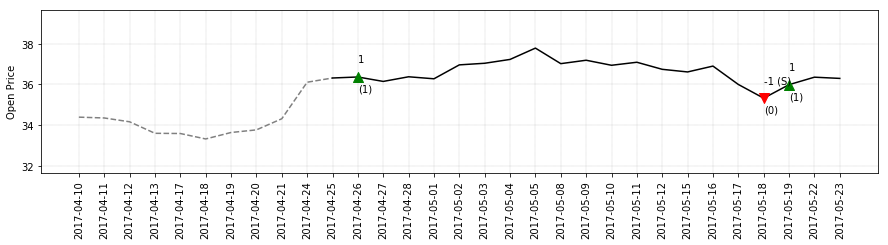

Return: 1.025
Random return: 0.977


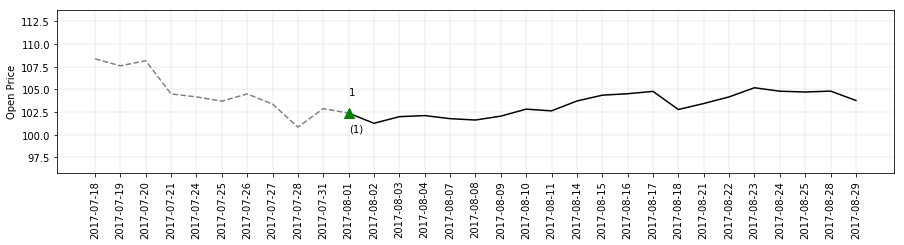

Return: 1.033
Random return: 0.900


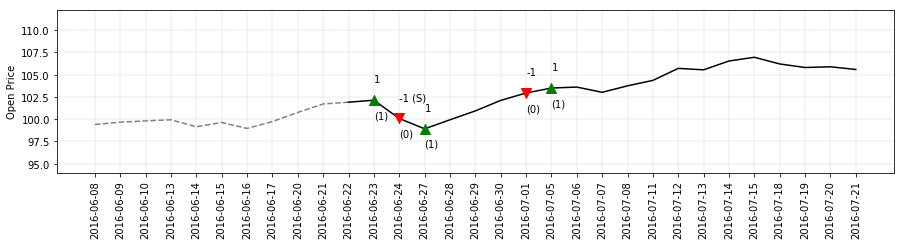

Return: 1.014
Random return: 0.961


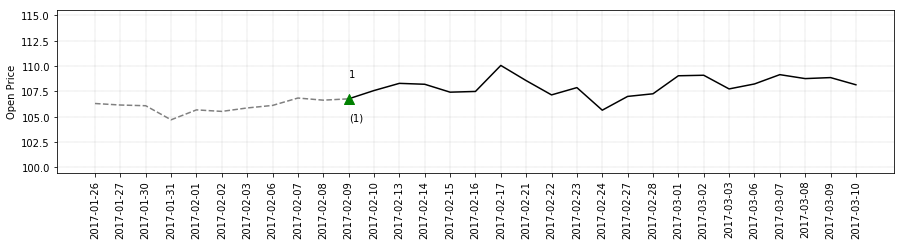

Return: 0.923
Random return: 0.979


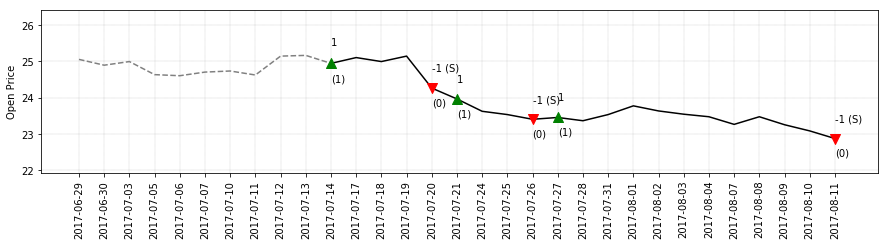

Return: 1.129
Random return: 0.959


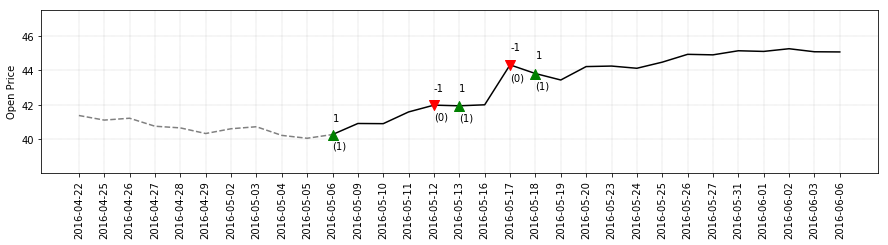

Return: 1.139
Random return: 1.038


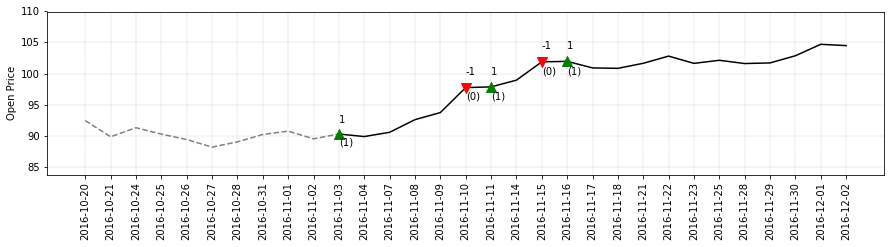

Return: 0.987
Random return: 1.019


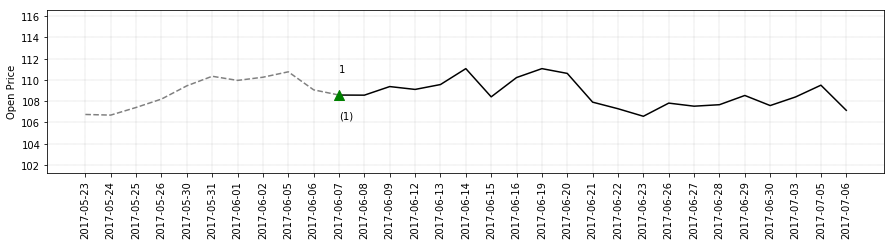

Return: 0.973
Random return: 0.993


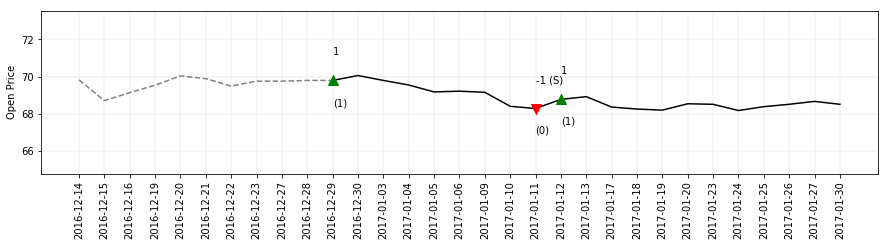

Return: 1.036
Random return: 0.887


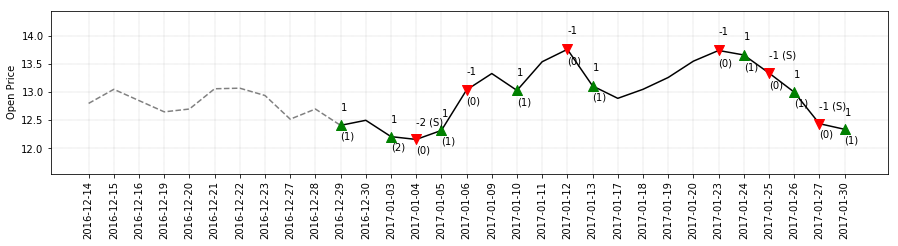

Return: 1.098
Random return: 1.094


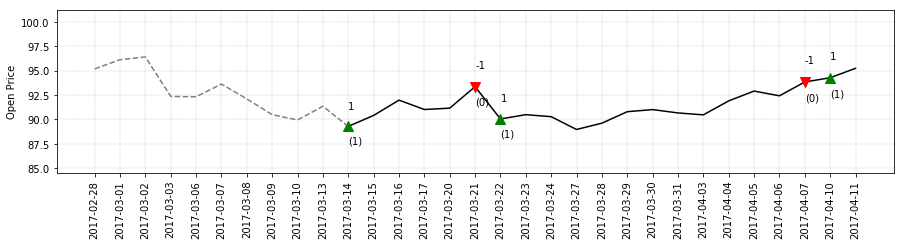

Return: 1.041
Random return: 1.007


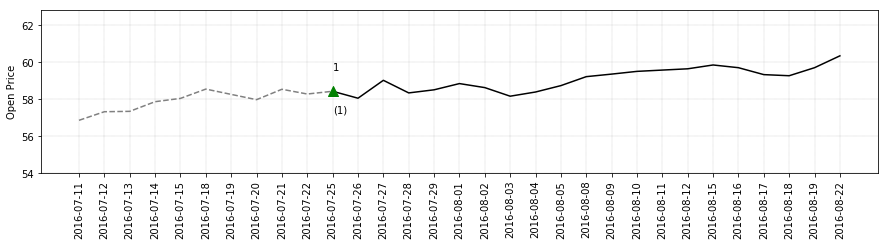

Return: 1.010
Random return: 0.876


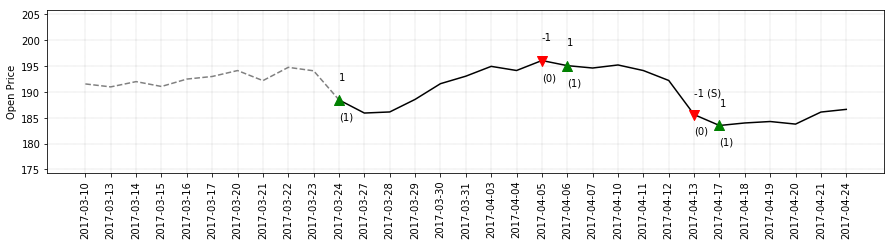

Return: 1.050
Random return: 0.959


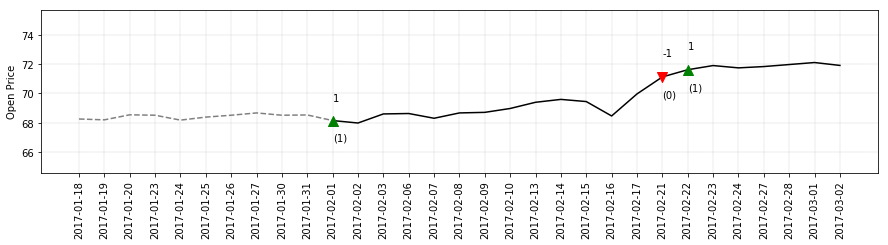

Return: 0.973
Random return: 1.060


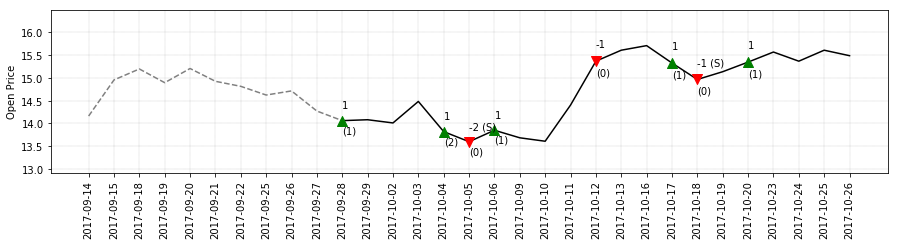

Return: 0.921
Random return: 1.001


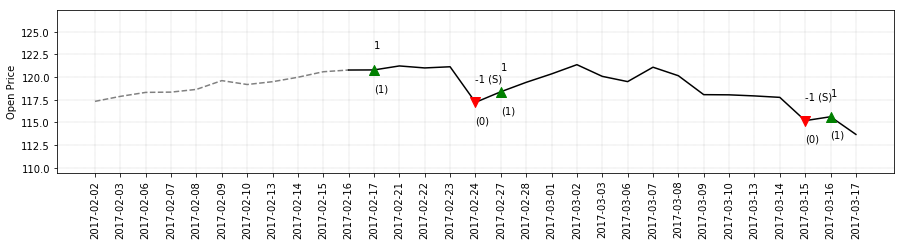

Return: 0.928
Random return: 0.571


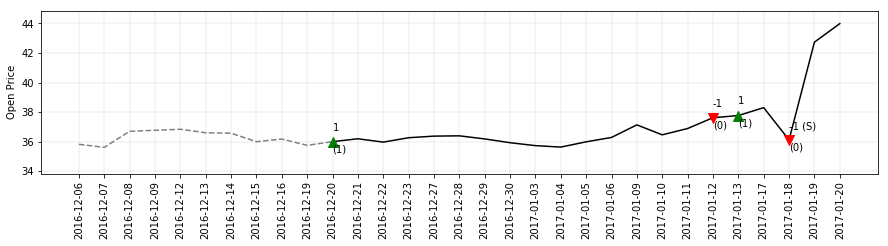

Return: 1.059
Random return: 1.015


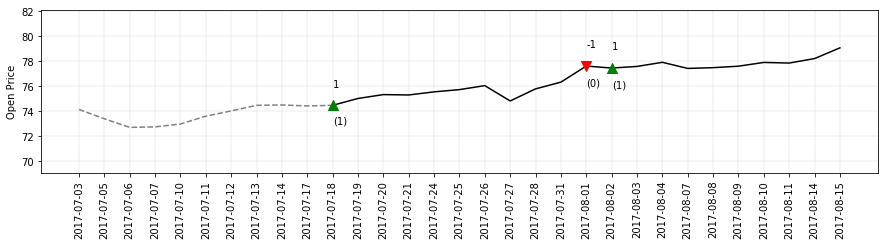

In [115]:
episode_count = 150

returns = []
random_returns = []

for i in range(episode_count):
    return_, random_return = run_episode(env,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres,raw_data_test,verbose=1)
    returns.append(return_)
    random_returns.append(random_return)

In [116]:
print('Average RL return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(returns)))
print('Average random return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(random_returns)))

Average RL return (150 episodes): 1.012
Average random return (150 episodes): 0.990
